## Цель работы

Есть небольшой тестовый датасет с данными о машинах, их признаках и стоимости. Необходимо проанализировать датасет, а также собрать данные для обучения, провести разведывательный анализ и построить модель для предсказания стоимости на тестовом датасете. Качество модели предлагается измерять с помощью метрики MAPE. Данная задача является задачей регрессии.

## Импорт библиотек

Импортируем библиотеки, которые понадобятся в ходе анализа данных. Остальные будут добавляться по мере надобности, в зависимости от результатов анализа.

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import warnings
import json
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

%matplotlib inline

## Вспомогательные функции

In [216]:
# функция для нахождения значимых различий для признака по тесту Стьюдента
def get_stat_dif(column):
    cols = df_train.loc[:, column].value_counts().index[:10]
    has_importance = False
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'price'],
                     df_train.loc[df_train.loc[:, column] == comb[1], 'price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            has_importance = True
            print('Найдены статистически значимые различия для колонки', column)
            break
    if not has_importance:
        print('Статистически значимых различий для колонки {} не найдено'.format(column))


# функция отрисовки боксплота для конкретной колонки
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='price',
                data=df_train.loc[df_train.loc[:, column].isin(
                    df_train.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# функция для проверки на выбросы
def check_for_outliers(column, bins_number):
    median = df_train[column].median()
    IQR = df_train[column].quantile(0.75) - df_train[column].quantile(0.25)
    perc25 = df_train[column].quantile(0.25)
    perc75 = df_train[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df_train[column].loc[df_train[column].between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=bins_number, label='IQR')
    plt.legend()

## Изучение датасетов, вычищение данных и приведение их к единому формату

Датасет для обучения был взят с kaggle по ссылке https://www.kaggle.com/macsunmood/autoru-parsed-0603-1304

In [217]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109080 entries, 0 to 109079
Data columns (total 22 columns):
Unnamed: 0              109080 non-null int64
bodyType                109079 non-null object
brand                   109080 non-null object
color                   109080 non-null object
fuelType                109080 non-null object
modelDate               109079 non-null float64
name                    109079 non-null object
numberOfDoors           109079 non-null float64
productionDate          109080 non-null int64
vehicleConfiguration    109079 non-null object
engineDisplacement      109079 non-null object
enginePower             109079 non-null float64
description             105829 non-null object
mileage                 109080 non-null int64
Комплектация            109080 non-null object
Привод                  109079 non-null object
Руль                    109080 non-null object
Владельцы               109073 non-null float64
ПТС                     109078 non-null ob

Посмотрим, сколько пропусков в столбцах.

In [218]:
df_train.isna().sum().sort_values(ascending=False)

Владение                69191
description              3251
Владельцы                   7
ПТС                         2
engineDisplacement          1
name                        1
bodyType                    1
Привод                      1
enginePower                 1
vehicleConfiguration        1
modelDate                   1
numberOfDoors               1
brand                       0
color                       0
fuelType                    0
Price                       0
productionDate              0
mileage                     0
Комплектация                0
Руль                        0
Таможня                     0
Unnamed: 0                  0
dtype: int64

Больше всего у нас пропусков в признаках "Владение", "description". В остальных столбцах пропусков совсем немного или вовсе нет.

In [219]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
bodyType                3837 non-null object
brand                   3837 non-null object
color                   3837 non-null object
fuelType                3837 non-null object
modelDate               3837 non-null float64
name                    3837 non-null object
numberOfDoors           3837 non-null float64
productionDate          3837 non-null float64
vehicleConfiguration    3837 non-null object
vehicleTransmission     3837 non-null object
engineDisplacement      3837 non-null object
enginePower             3837 non-null object
description             3837 non-null object
mileage                 3837 non-null float64
Комплектация            3837 non-null object
Привод                  3837 non-null object
Руль                    3837 non-null object
Состояние               3837 non-null object
Владельцы               3837 non-null object
ПТС                     3837 non-n

In [220]:
df_test.isna().sum().sort_values(ascending=False)

Владение                2084
id                         0
engineDisplacement         0
brand                      0
color                      0
fuelType                   0
modelDate                  0
name                       0
numberOfDoors              0
productionDate             0
vehicleConfiguration       0
vehicleTransmission        0
enginePower                0
description                0
mileage                    0
Комплектация               0
Привод                     0
Руль                       0
Состояние                  0
Владельцы                  0
ПТС                        0
Таможня                    0
bodyType                   0
dtype: int64

В тестовом датасете у нас всего 1 столбец с пропусками. Пропусков больше половины, и скорее всего, этот столбец не будет нам нужен.

Далее приведем названия колонок в обоих датасетах к единообразному виду.

In [221]:
df_train.columns = ['id', 'body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
                    'doors_number', 'production_date', 'vehicle_configuration',
                    'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation',
                    'drive_type', 'steering_wheel', 'owners', 'technical_passport',
                    'customs', 'ownership', 'price']

df_test.columns = ['body_type', 'brand', 'color', 'fuel_type', 'model_date', 'name',
                   'doors_number', 'production_date', 'vehicle_configuration', 'vehicle_transmission',
                   'engine_displacement', 'engine_power', 'description', 'mileage', 'complectation',
                   'drive_type', 'steering_wheel', 'condition', 'owners', 'technical_passport',
                   'customs', 'ownership', 'id']

Сразу удалим столбцы ownership (как имеющий множество пропусков) и description (не несет в себе особой смысловой нагрузки).

In [222]:
df_train = df_train.drop(columns=['ownership', 'description'], axis=1)
df_test = df_test.drop(columns=['ownership', 'description'], axis=1)

Сразу отметим, что в тренировочном датасете есть целевая переменная **price**, которой нет в тестовом датасете. В тестовом датасете также есть признаки **condition и vehicle_transmission**, которых нет в тренировочном датасете.

In [223]:
display(df_train.head(1))
display(df_test.head(1))

,id,body_type,brand,color,fuel_type,model_date,name,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,owners,technical_passport,customs,price
0,0,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,MECHANICAL,2.3,133.0,10000,{'id': '0'},передний,LEFT,3.0,ORIGINAL,True,135000


,body_type,brand,color,fuel_type,model_date,name,doors_number,production_date,vehicle_configuration,vehicle_transmission,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,condition,owners,technical_passport,customs,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,0


Видно, что в тестовом датасете vehicle_transmission - это то, что находится в тренировочном датасете в столбце vehicle_configuration. Поэтому сразу заменим значения на соответствующие тренировочному датасету и удалим заведомо лишние столбцы.

In [224]:
df_test['vehicle_configuration'] = df_test['vehicle_transmission']

df_test.drop(columns=['vehicle_transmission',
                      'condition', 'id'], axis=1, inplace=True)
df_train.drop(columns=['id'], axis=1, inplace=True)

Теперь у нас одинаковая структура в обоих датасетах. Добавим столбец price, заполненный нулями, в тестовый датасет.

In [225]:
df_test['price'] = 0

Посмотрим на количество уникальных значений в тестовых данных.

In [226]:
df_test.nunique()

body_type                  11
brand                       1
color                      15
fuel_type                   4
model_date                 31
name                      384
doors_number                4
production_date            37
vehicle_configuration       3
engine_displacement        22
engine_power               75
mileage                  1942
complectation            3295
drive_type                  3
steering_wheel              1
owners                      3
technical_passport          2
customs                     1
price                       1
dtype: int64

Видно, что в тестовом датасете представлены данные всего лишь по одному бренду. Посмотрим, что это за бренд, и сколько данных по этому бренду в обучающем датасете.

In [227]:
df_test['brand'].unique()

array(['BMW'], dtype=object)

In [228]:
df_train[df_train['brand'] == 'BMW'].shape

(14390, 19)

Получилось 14390 значений, скорее всего, этого будет вполне достаточно. Отфильтруем обучающий датасет, оставив данные только о бренде BMW.

In [229]:
df_train = df_train[df_train['brand'] == 'BMW']

Теперь объединим датасеты для удобства работы с данными. Столбец brand теперь мы можем также удалить.

In [230]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.shape

(18227, 19)

In [231]:
df = df.drop(columns=['brand'], axis=1)

### Работа с полем body_type

In [232]:
df['body_type'].value_counts(dropna=False)

Внедорожник 5 дв.         5842
Седан                     5687
внедорожник 5 дв.         1626
седан                     1594
Купе                       707
Седан Long                 664
Хэтчбек 5 дв.              583
Лифтбек Gran Turismo       342
купе                       214
Универсал 5 дв.            164
хэтчбек 5 дв.              163
Хэтчбек 3 дв.              154
лифтбек                    125
Кабриолет                   70
Седан Gran Coupe            50
универсал 5 дв.             46
хэтчбек 3 дв.               36
Родстер                     33
Лифтбек Gran Coupe          32
Хэтчбек 3 дв. Compact       25
кабриолет                   19
Компактвэн Gran Tourer      15
Седан 2 дв.                 12
родстер                     10
Родстер Roadster             4
Компактвэн                   4
компактвэн                   3
Купе-хардтоп                 2
седан 2 дв.                  1
Name: body_type, dtype: int64

Это категориальный (номинативный) признак. Так как количество дверей прописано отдельно, оставим только первое слово, обозначающее базовую классификацию, и приведем все к единому виду (lowercase).

In [233]:
# функция для вычищения данных по признаку body_type
def clean_body_type(value):
    if value == value:
        index_space = value.find(' ')
        index_def = value.find('-')
        if index_space == -1 and index_def == -1:
            return value.lower()
        if index_space != -1 and index_def == -1:
            return value[:index_space].lower()
        if index_def != -1 and index_space == -1:
            return value[:index_def].lower()
        if index_def != -1 and index_space != -1:
            return value[:min(index_def, index_space)].lower()
    else:
        return value


df['body_type'] = df['body_type'].apply(clean_body_type)
display(df['body_type'].value_counts(dropna=False))

седан          8008
внедорожник    7468
хэтчбек         961
купе            923
лифтбек         499
универсал       210
кабриолет        89
родстер          47
компактвэн       22
Name: body_type, dtype: int64

Далее объединим минивэн, компактвэн и микровэн в один класс, так как это внутренние разновидности минивэна. Также объединим хэтчбэк и лифтбэк в один класс. И также объединим открытые типы кузова (кабриолет, родстер, тарга) в класс "открытый", для сокращения количества значений.

Выводы по объединению данных о кузове были сделаны на основе статьи Википедии https://ru.wikipedia.org/wiki/%D0%A2%D0%B8%D0%BF%D1%8B_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%BA%D1%83%D0%B7%D0%BE%D0%B2%D0%BE%D0%B2

In [234]:
def replace_body_type(value):
    if value in ['минивэн', 'компактвэн', 'микровэн']:
        return 'минивэн'
    if value in ['хэтчбек', 'лифтбек']:
        return 'хэтчбек'
    if value in ['родстер', 'кабриолет', 'тарга']:
        return 'открытый'
    return value


df['body_type'] = df['body_type'].apply(replace_body_type)
df['body_type'].value_counts(dropna=False)

седан          8008
внедорожник    7468
хэтчбек        1460
купе            923
универсал       210
открытый        136
минивэн          22
Name: body_type, dtype: int64

Теперь посмотрим на распределение значений признака на тренировочном датасете, а также проверим признак на наличие значимых статистических различий по тесту Стьюдента.

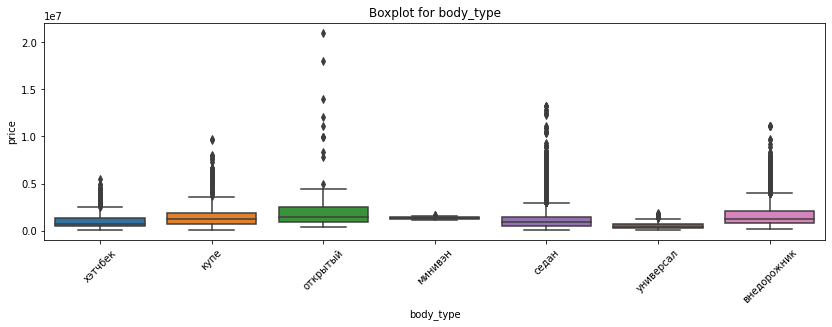

Найдены статистически значимые различия для колонки body_type


In [235]:
df_train = df[df.price != 0]
get_boxplot('body_type')
get_stat_dif('body_type')

### Работа с полем color

In [236]:
df['color'].value_counts(dropna=False)

040001         5560
FAFBFB         2656
0000CC         1858
97948F         1587
чёрный         1395
CACECB          855
белый           767
200204          747
синий           510
серый           453
EE1D19          419
коричневый      216
серебристый     191
007F00          168
C49648          163
22A0F8          156
красный         115
660099           72
FF8649           53
DEA522           48
бежевый          46
голубой          35
зелёный          33
4A2197           32
оранжевый        27
золотистый       23
пурпурный        20
FFD600           16
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

В признаке цвета машины пропусков тоже нет, это категориальный (номинативный) признак. Всего здесь 30 значений. Составим словарь отображения цветов на русском в кода, а потом единообразно обработаем цветовые кода и приведем их к английским цветам. Для определения названия цвета кода будем использовать цветовую палитру matplotlib.colors.

In [237]:
import matplotlib.colors as mc
# используем палитру цветов matplotlib
mycss4list = mc.CSS4_COLORS

# коды для встречающихся русскоязычных названий цветов взяты из Википедии
colors = {
    'чёрный': '000000', 'белый': 'FFFFFF', 'синий': '0000FF', 'серый': '808080',
    'коричневый': 'A52A2A', 'серебристый': 'C0C0C0', 'красный': 'FF0000', 'бежевый': 'F5F5DC',
    'голубой': '75BBFD', 'зелёный': '008000', 'оранжевый': 'FFA500', 'золотистый': 'FFD700',
    'пурпурный': '800080', 'фиолетовый': '8B00FF', 'жёлтый': 'FFFF00'
}


def hex_to_rgb(value):
    # в словаре matplotlib первый символ - решетка, поэтому его не обрабатываем
    if value[0] == '#':
        return tuple(int(value[i:i+2], 16) for i in (1, 3, 5))
    # в нашем датасете решетки в названиях нет
    else:
        return tuple(int(value[i:i+2], 16) for i in (0, 2, 4))


# получение имени ближайшего цвета
def closest_colour(requested_colour):
    min_colours = {}
    # вычисление Евклидовых расстояний между искомым цветом и палитрой matplotlib
    for name, key in mycss4list.items():
        red, green, blue = hex_to_rgb(key)
        rd = (red - requested_colour[0]) ** 2
        gd = (green - requested_colour[1]) ** 2
        bd = (blue - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    # возвращаем название цвета с наименьшим расстоянием до искомого
    return min_colours[min(min_colours.keys())]


def get_colour_name(value):
    if value == value:
        hex_value = value
        if value in colors.keys():
            hex_value = colors[value]
        rgb_value = hex_to_rgb(hex_value)
        closest_name = closest_colour(rgb_value)
        return closest_name
    else:
        return value


unique_colors = df['color'].unique()

color_dict = {}

for color in unique_colors:
    color_dict[color] = get_colour_name(color)

df['color'] = df['color'].apply(lambda x: color_dict[x])

In [238]:
df['color'].value_counts(dropna=False)

black            7702
snow             2656
grey             2040
mediumblue       1858
lightgrey         855
white             767
blue              510
crimson           419
brown             216
green             201
silver            191
peru              163
dodgerblue        156
red               115
indigo             72
coral              53
goldenrod          48
beige              46
gold               39
lightskyblue       35
darkslateblue      32
orange             27
purple             20
darkviolet          5
yellow              1
Name: color, dtype: int64

В результате приведения к одному формату количество значений сократилось с 30 до 25. Соберем оттенки цветов в базовые (информация о цветах была взята также из Википедии).

In [239]:
def convert_color_to_base(value):
    if value in ['mediumblue', 'blue', 'dodgerblue', 'lightskyblue', 'indigo', 'darkslateblue']:
        return 'blue'
    if value in ['snow', 'white', 'beige']:
        return 'white'
    if value in ['grey', 'lightgrey', 'silver']:
        return 'grey'
    if value in ['crimson', 'red', 'brown', 'pink']:
        return 'red'
    if value in ['peru', 'goldenrod', 'gold', 'orange', 'yellow', 'coral']:
        return 'orange'
    if value in ['purple', 'darkviolet']:
        return 'purple'
    return value


df['color'] = df['color'].apply(convert_color_to_base)
df['color'].value_counts(dropna=False)

black     7702
white     3469
grey      3086
blue      2663
red        750
orange     331
green      201
purple      25
Name: color, dtype: int64

Осталось всего 8 значений, теперь посмотрим на их распределение и значимость признака на тренировочном датасете.

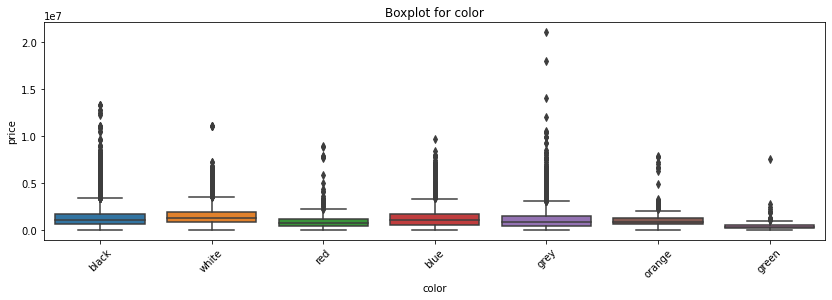

Найдены статистически значимые различия для колонки color


In [240]:
df_train = df[df.price != 0]
get_boxplot('color')
get_stat_dif('color')

### Работа с полем fuel_type

In [241]:
df['fuel_type'].value_counts(dropna=False)

бензин     12008
дизель      6185
гибрид        30
электро        4
Name: fuel_type, dtype: int64

Это также категориальный (номинативный) признак. Ситуация со значениями поля тоже выглядит хорошо, пропусков нет, формат значений единый. Построим распределение значений и проверим признак на статистическую значимость.

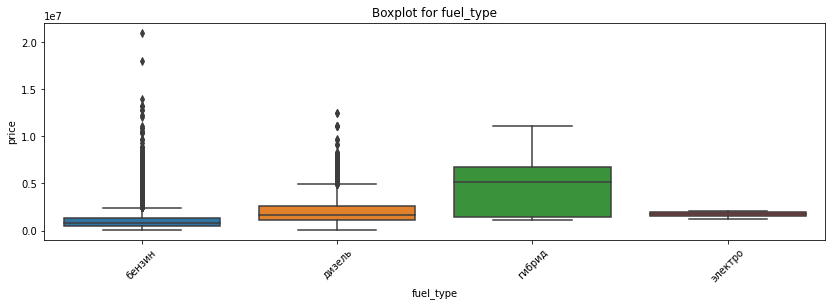

Найдены статистически значимые различия для колонки fuel_type


In [242]:
get_boxplot('fuel_type')
get_stat_dif('fuel_type')

### Работа с полем model_date

In [243]:
df['model_date'].unique()

array([2007., 2017., 2011., 2015., 2004., 2014., 2018., 1965., 2005.,
       2008., 2001., 1998., 1990., 1975., 1982., 1937., 1936., 1949.,
       2013., 2009., 2000., 2016., 1995., 2002., 1987., 1981., 1972.,
       2003., 1957., 2012., 1994., 2019., 1986., 1977., 1989., 1999.,
       1992., 1988., 2010., 2006., 1976.])

Это либо числовой, либо категориальный (порядковый) признак (в дальнейшем мы проведем анализ данного признака и в рамках числового, и категориального). Приведем его к целочисленному типу данных и посмотрим на распеделение значений.

In [244]:
df['model_date'] = df['model_date'].apply(lambda x: int(x))
df['model_date'].unique()

array([2007, 2017, 2011, 2015, 2004, 2014, 2018, 1965, 2005, 2008, 2001,
       1998, 1990, 1975, 1982, 1937, 1936, 1949, 2013, 2009, 2000, 2016,
       1995, 2002, 1987, 1981, 1972, 2003, 1957, 2012, 1994, 2019, 1986,
       1977, 1989, 1999, 1992, 1988, 2010, 2006, 1976], dtype=int64)

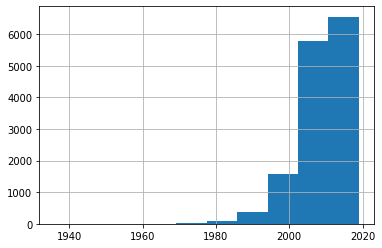

In [245]:
df_train = df[df.price != 0]
df_train['model_date'].hist()

Из графика видно, что в основном дата производства модели не более 20-25 лет назад. Посмотрим, есть ли выбросы.

25-й перцентиль: 2006.0, 75-й перцентиль: 2013.0, IQR: 7.0,  Границы выбросов: [1995.5, 2023.5].


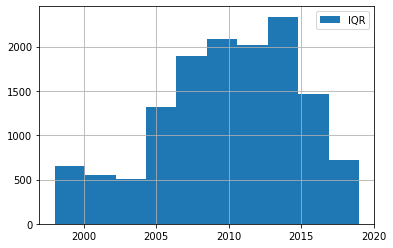

In [246]:
check_for_outliers('model_date', 10)

In [247]:
df['model_date'].value_counts(dropna=False, bins=5)

(2002.4, 2019.0]      15879
(1985.8, 2002.4]       2232
(1969.2, 1985.8]        103
(1935.916, 1952.6]       10
(1952.6, 1969.2]          3
Name: model_date, dtype: int64

По формуле получилось слишком много выбросов (все модели, выпущенные более 25 лет назад), но так как год выпуска - это важная составляющая (старые модели могут иметь меньшую стоимость, раритетно старые - наоборот, большую), то оставим все значения как есть.

### Работа с полем name

In [248]:
df['name'].unique()

array(['116i 1.6 AT (115 л.с.)', '118i 1.5 AT (136 л.с.)',
       '116i 1.6 AT (136 л.с.)', '118i 2.0 AT (136 л.с.)',
       '118i 2.0 AT (129 л.с.)', '118i 1.6 AT (170 л.с.)',
       '120i 2.0 AT (150 л.с.)', '120d 2.0d AT (177 л.с.)',
       '118i 1.6 AT (136 л.с.)', '118d 2.0d MT (122 л.с.)',
       'M135i xDrive 3.0 AT (320 л.с.) 4WD', '118i 1.6 MT (170 л.с.)',
       '135i 3.0 AMT (306 л.с.)', '120d 2.0d AT (184 л.с.)',
       '125i 3.0 AT (218 л.с.)', 'M140i 3.0 AT (340 л.с.)',
       '120d 2.0d MT (184 л.с.) 4WD', '116i 1.6 MT (122 л.с.)',
       '116i 1.6 MT (115 л.с.)', '120i 2.0 MT (156 л.с.)',
       '130i 3.0 MT (265 л.с.)', '120d 2.0d MT (177 л.с.)',
       '120i 2.0 AT (156 л.с.)', '130i 3.0 AT (265 л.с.)',
       '120i 2.0 AT (184 л.с.)', '116i 1.6 MT (136 л.с.)',
       '116i 1.6 AT (122 л.с.)', '135i 3.0 AT (306 л.с.)',
       '118i 2.0 MT (143 л.с.)', '118d 2.0d AT (143 л.с.)',
       '2.0d AT (190 л.с.) 4WD', '1.5 AT (136 л.с.)',
       '3.0 AT (340 л.с.) 4WD', '220i

Признак name объединяет в себе несколько других признаков (тип управления, мощность мотора, литраж), поэтому его можно удалить.

In [249]:
df.drop(columns=['name'], axis=1, inplace=True)

### Работа с полем doors_number

In [250]:
df['doors_number'].unique()

array([5., 3., 2., 4.])

Ситуация со значениями выглядит хорошо (нет пропусков, формат единый), приведем их к целочисленному типу и посмотрим на распределение значений. Это - категориальный (ординарный) признак.

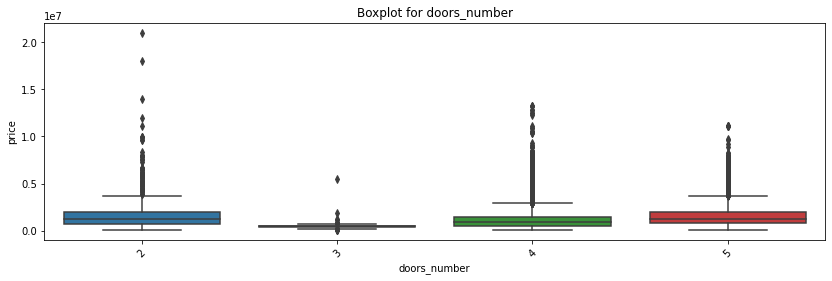

Найдены статистически значимые различия для колонки doors_number


In [251]:
df['doors_number'] = df['doors_number'].apply(lambda x: int(x))
df_train = df[df.price != 0]
get_boxplot('doors_number')
get_stat_dif('doors_number')

### Работа с полем production_date

Это так же, как и год выпуска модели, либо числовой, либо категориальный (порядковый) признак. Приведем его к целочисленному типу данных и посмотрим на распеделение значений.

In [252]:
df['production_date'].unique()

array([2008., 2011., 2017., 2014., 2013., 2009., 2012., 2006., 2005.,
       2018., 2019., 2010., 2015., 2016., 2007., 2004., 1968., 2003.,
       2002., 2001., 2000., 2020., 1999., 1998., 1996., 1992., 1979.,
       1985., 1991., 1988., 1993., 1994., 1997., 1984., 1986., 1982.,
       1995., 1981., 1990., 1989., 1983., 1987., 1937., 1949., 1947.,
       1948., 1950., 1975., 1958., 1980., 1977.])

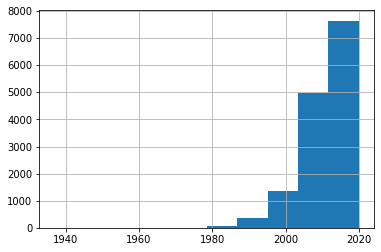

In [253]:
df['production_date'] = df['production_date'].apply(lambda x: int(x))
df_train = df[df.price != 0]
df_train['production_date'].hist()

Распределение значений очень похоже на то, которое наблюдалось у признака model_date.

25-й перцентиль: 2008.0, 75-й перцентиль: 2015.0, IQR: 7.0,  Границы выбросов: [1997.5, 2025.5].


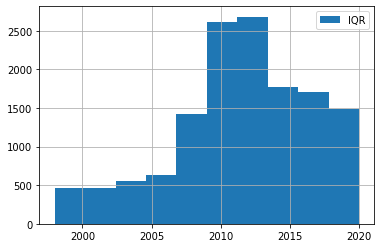

In [254]:
check_for_outliers('production_date', 10)

Границы выбросов получились тоже похожими на границы у model_date, но оставим данные как есть, так как год производства машины вероятно будет сильно влиять на цену, из соображений логики. Также есть подозрение, что корреляция между этими двумя признаками будет очень сильной (проверим это предположение чуть позже).

### Работа с полем vehicle_cofiguration

In [255]:
df['vehicle_configuration'].value_counts(dropna=False)

AUTOMATIC           13458
автоматическая       3677
MECHANICAL            791
ROBOT                 141
механическая          111
роботизированная       49
Name: vehicle_configuration, dtype: int64

Это категориальный (номинативный) признак. По факту у нас есть всего 4 значения - вариатор (в расширенной версии датасета), автоматическая, роботизированная или механическая коробка передач. Уберем дубликаты.

In [256]:
configurations = {
    'AUTOMATIC': 'автоматическая',
    'MECHANICAL': 'механическая',
    'VARIATOR': 'вариатор',
    'ROBOT': 'роботизированная'
}


def clean_vehicle_configuration(value):
    if value in configurations.keys():
        return configurations[value]
    else:
        return value


df['vehicle_configuration'] = df['vehicle_configuration'].apply(
    clean_vehicle_configuration)
df['vehicle_configuration'].value_counts(dropna=False)

автоматическая      17135
механическая          902
роботизированная      190
Name: vehicle_configuration, dtype: int64

Посмотрим на распределение значений, а также на важность признака.

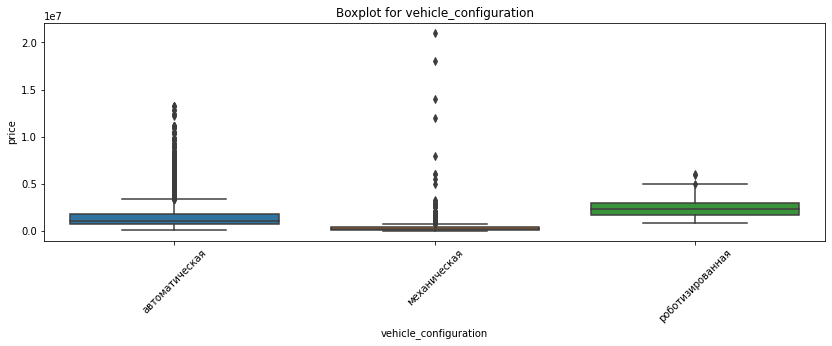

Найдены статистически значимые различия для колонки vehicle_configuration


In [257]:
df_train = df[df.price != 0]
get_boxplot('vehicle_configuration')
get_stat_dif('vehicle_configuration')

### Работа с полем engine_displacement

In [258]:
df['engine_displacement'].unique()

array(['116i', '118i', '120i', '120d', '118d', 'M135i', '135i', '125i',
       'M140i', '130i', '2.0d', '1.5', '3.0', '220i', '220d', 'M235i',
       '218i', '216d', '218d', 'CS', '320d', '320i', '325xi', '325i',
       '316i', '318i', '328i', '330i', 'M340i', '335i', '316', '323i',
       '318d', '330xi', '330d', '320xd', '335xi', '335d', 'N42', '340i',
       '315', 'N46', '316d', '325d', '2.0', '420d', '420i', '428i',
       '435i', '430i', '440i', '528i', '540i', '535i', '530i', '530d',
       '525d', '520i', 'M550d', '525i', '523i', '520d', '550i', '530xi',
       '525xi', '535d', '530Li', 'M550i', '525xd', '545i', '528Li',
       '520Li', '518i', '530xd', '535xi', '518', '524d', '520', '525E',
       '535Li', '640d', '630i', '640i', '630d', '650i', '620d', '645i',
       '0.6', '750d', '750i', '730d', 'M760Li', '750Ld', '730Ld', '750Li',
       '730Li', '740d', '740Li', '740Ld', '740i', '730i', '745i', '735i',
       '725Ld', '760Li', '728i', '760i', '745Li', '735Li', '725d',
   

Напишем функцию для вычистки значений данного признака.

In [259]:
import re

# регулярное выражение для поиска чисел
NUM_RE = re.compile(r'\d*[.,]?\d+', re.I)


def clean_engine_displacement(value):
    # обработка мусорных данных
    garbage_data = ['undefined LTR', '30', 'CS', 'Electro',
                    'N46', 'N42', 'Competition', 'ActiveHybrid', '94Ah']
    if value in garbage_data:
        return None

    # обработка значений вида N LTR
    if value.find('LTR') != -1:
        result = value.replace(' LTR', '')
        result = (float(result)) * 1000  # перевод в мл
        return int(result)

    # обработка константных значений
    values = ['M550d', 'M550i', '750d', '730d', '750Ld', '730Ld', '740Ld', '640i', '635i', '630d', '740d',
              '840i', '840d', '35i', '30i', '30d', '35d', 'M40i', 'M40d', 'M50d', '25d', '35is', '23i',
              '23d', '40i', '40d']
    if value in values:
        result = int(3000)
        return result
    values = ['750i', '745i', '650i', '645i',
              'M850i', '850i', 'M50i', '50i', '48i']
    if value in values:
        result = int(4400)
        return result
    values = ['725Ld', '730i', '620d', '725d', '30i', '18i',
              '18d', '20i', '25i', '20d', '28i', 'I30', '123d']
    if value in values:
        result = int(2000)
        return result
    values = ['M760Li', '760Li', '750Li', '745Li', '740Li', '730Li' '735Li', '728Li',
              '728i', '735i', '733i', '760i', '740i', '116i', '118i', '120i', '120d',
              '118d', 'M135i', '135i', '125i', 'M140i', '130i', '220i', '220d', 'M235i', '218i', '216d', '218d',
              '320d', '320i', '325xi', '325i', '316i', '318i', '328i', '330i', 'M340i', '335i', '316', '323i',
              '318d', '330xi', '330d', '320xd', '335xi', '335d', '340i']
    if value in values:
        result = int(NUM_RE.findall(value)[0])
        result = (result - ((result // 100) * 100)) * 100
        return result
    values = ['sDrive18i', 'xDrive20d', 'xDrive18d', 'xDrive20i', 'sDrive20i']
    if value in values:
        result = int(NUM_RE.findall(value)[0])
        result = result * 100
        return result

    result = float(NUM_RE.findall(value)[0])
    values = ['140', '150', '160', '170', '180', '200', '220', '230', '240', '250', '260', '270', '280', '290',
              '300', '320', '350', '380', '400', '450', '460', '470', '500', '560', '570']
    if result in values:
        result = int(result)
        result = result * 10
        return result

    if result == '' or result != result:
        return None

    if result >= 0.1 and result <= 9.9:
        result = result * 1000
        result = int(result)
        return result
    if result >= 100 and result <= 999:
        result = (result - ((result // 100) * 100)) * 100
    return int(result)

In [260]:
df['engine_displacement'] = df['engine_displacement'].apply(
    clean_engine_displacement)
df['engine_displacement'].unique()

array([1600., 1800., 2000., 3500., 2500., 4000., 3000., 1500.,   nan,
       2800., 2300., 5000., 4500., 2400., 4400.,  600., 6000., 3300.,
        700., 3800., 4900., 4800., 4600., 1900., 2200., 6600., 3600.,
       5400., 2900., 3400.])

In [261]:
df[df['engine_displacement'] != df['engine_displacement']
   ]['engine_displacement'].value_counts(dropna=False)

NaN    65
Name: engine_displacement, dtype: int64

У нас получилось всего 65 пропусков, которые мы заполним медианным значением.

In [262]:
engine_median = int(df['engine_displacement'].median())
df['engine_displacement'] = df['engine_displacement'].apply(
    lambda x: int(x) if x == x else engine_median)
df['engine_displacement'].unique()

array([1600, 1800, 2000, 3500, 2500, 4000, 3000, 1500, 2800, 2300, 5000,
       4500, 2400, 4400,  600, 6000, 3300,  700, 3800, 4900, 4800, 4600,
       1900, 2200, 6600, 3600, 5400, 2900, 3400], dtype=int64)

Посмотрим на распределение значений. На данный момент непонятно, числовой это признак или категориальный, но скорее всего, категориальный.

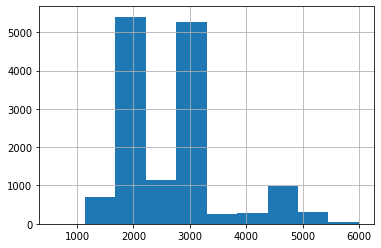

In [263]:
df_train = df[df.price != 0]
df_train['engine_displacement'].hist()

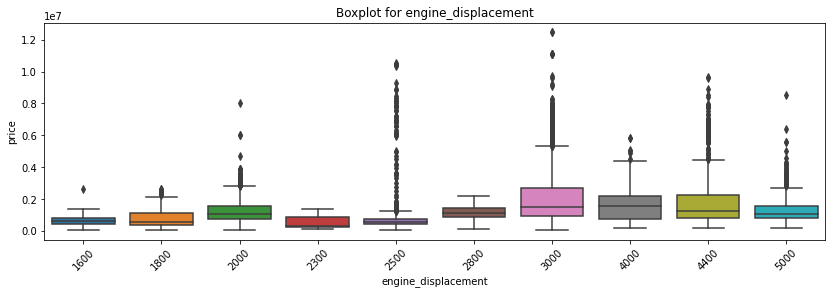

Найдены статистически значимые различия для колонки engine_displacement


In [264]:
get_boxplot('engine_displacement')
get_stat_dif('engine_displacement')

### Работа с полем engine_power

In [265]:
df['engine_power'].unique()

array([115.0, 136.0, 129.0, 170.0, 150.0, 177.0, 122.0, 320.0, 306.0,
       184.0, 218.0, 340.0, 156.0, 265.0, 143.0, 190.0, 326.0, 140.0,
       116.0, 245.0, 249.0, 387.0, 258.0, 105.0, 233.0, 192.0, 118.0,
       102.0, 163.0, 90.0, 125.0, 231.0, 113.0, 272.0, 100.0, 171.0,
       193.0, 286.0, 75.0, 234.0, 46.0, 51.0, 400.0, 204.0, 381.0, 407.0,
       252.0, 367.0, 197.0, 313.0, 300.0, 235.0, 462.0, 211.0, 333.0,
       230.0, 188.0, 450.0, 19.0, 610.0, 609.0, 445.0, 530.0, 544.0,
       410.0, 370.0, 420.0, 343.0, 431.0, 460.0, 507.0, 625.0, 560.0,
       600.0, 575.0, 360.0, 264.0, 355.0, 329.0, 269.0, 347.0, 555.0,
       449.0, 238.0, 243.0, 585.0, '190 N12', '150 N12', '407 N12',
       '249 N12', '381 N12', '245 N12', '177 N12', '184 N12', '115 N12',
       '231 N12', '156 N12', '306 N12', '218 N12', '136 N12', '235 N12',
       '286 N12', '122 N12', '265 N12', '258 N12', '340 N12', '355 N12',
       '170 N12', '333 N12', '192 N12', '610 N12', '264 N12', '555 N12',
       '

Так как мощность мотора может иметь большое множество значений, скорее всего можно считать данный признак числовым (но возможно, он является категориальным). Приведем данные к единому формату, а затем посмотрим на распределение данных.

In [266]:
def clean_engine_power(value):
    value = str(value)
    value = value.replace(' N12', '')
    return (int(float(value)))


df['engine_power'] = df['engine_power'].apply(clean_engine_power)
df['engine_power'].unique()

array([115, 136, 129, 170, 150, 177, 122, 320, 306, 184, 218, 340, 156,
       265, 143, 190, 326, 140, 116, 245, 249, 387, 258, 105, 233, 192,
       118, 102, 163,  90, 125, 231, 113, 272, 100, 171, 193, 286,  75,
       234,  46,  51, 400, 204, 381, 407, 252, 367, 197, 313, 300, 235,
       462, 211, 333, 230, 188, 450,  19, 610, 609, 445, 530, 544, 410,
       370, 420, 343, 431, 460, 507, 625, 560, 600, 575, 360, 264, 355,
       329, 269, 347, 555, 449, 238, 243, 585, 374], dtype=int64)

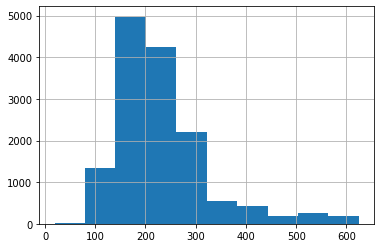

In [267]:
df_train = df[df.price != 0]
df_train['engine_power'].hist()

Распределение данных напоминает нормальное. Проверим данные на выбросы.

25-й перцентиль: 184.0, 75-й перцентиль: 272.0, IQR: 88.0,  Границы выбросов: [52.0, 404.0].


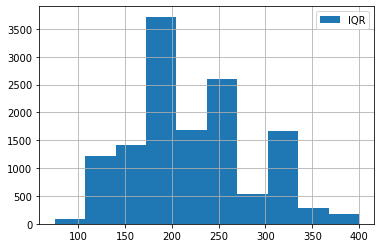

In [268]:
check_for_outliers('engine_power', 10)

Формула предлагает нам выкинуть данные о мощных моторах, но этого делать мы не будем, так как мощность мотора, по первичным предположениям, может влиять на цену.

### Работа с полем mileage

In [269]:
df['mileage'].value_counts().sort_values(ascending=False)

200000.0    179
140000.0    177
300000.0    164
160000.0    152
130000.0    146
           ... 
63242.0       1
421325.0      1
27356.0       1
23143.0       1
190800.0      1
Name: mileage, Length: 4843, dtype: int64

Это числовой признак. Посмотрим на его распределение.

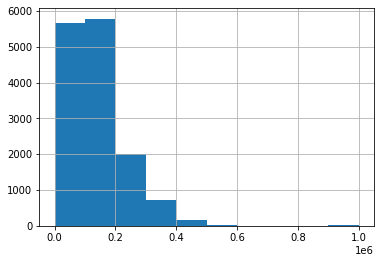

In [270]:
df_train = df[df.price != 0]
df_train['mileage'].hist()

25-й перцентиль: 70045.25, 75-й перцентиль: 185000.0, IQR: 114954.75,  Границы выбросов: [-102386.875, 357432.125].


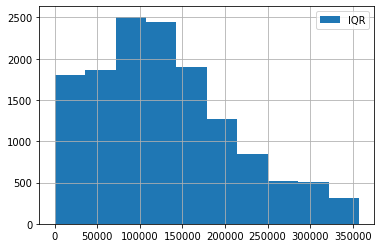

In [271]:
check_for_outliers('mileage', 10)

Приведем признак к целочисленному виду.

In [272]:
df['mileage'] = df['mileage'].apply(lambda x: int(x))

### Работа с полем drive_type

In [273]:
df['drive_type'].value_counts(dropna=False)

полный      10880
задний       7279
передний       68
Name: drive_type, dtype: int64

Признак категориальный (номинативный). Пропусков нет, и значения уже приведены к единому формату.

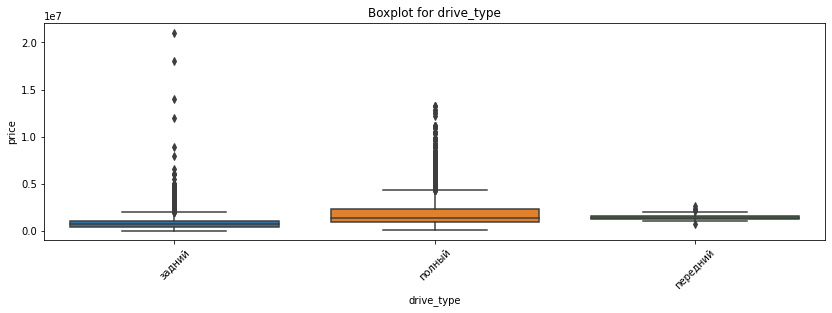

Найдены статистически значимые различия для колонки drive_type


In [274]:
df_train = df[df.price != 0]
get_boxplot('drive_type')
get_stat_dif('drive_type')

### Работа с полем steering_wheel

In [275]:
df['steering_wheel'].value_counts(dropna=False)

LEFT     14386
Левый     3837
RIGHT        4
Name: steering_wheel, dtype: int64

Это бинарный признак. Приведем значения к единому формату - 1 ("Левый") и 0 ("Правый").

In [276]:
def clean_steering_wheel(value):
    if value == 'LEFT' or value == 'Левый':
        return 1
    if value == 'RIGHT':
        return 0
    return value


df['steering_wheel'] = df['steering_wheel'].apply(clean_steering_wheel)
df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,steering_wheel,owners,technical_passport,customs,price
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,{'id': '0'},задний,1,2,ORIGINAL,True,436000
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,1,1,ORIGINAL,True,595000
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1800,136,41000,{'id': '0'},задний,1,2,ORIGINAL,True,1150000


Посмотрим на распределение значений, а также на значимость данного признака.

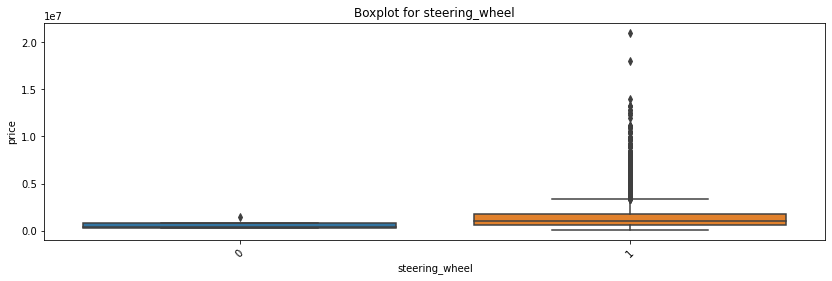

Статистически значимых различий для колонки steering_wheel не найдено


In [277]:
df_train = df[df.price != 0]
get_boxplot('steering_wheel')
get_stat_dif('steering_wheel')

Так как статистически значимых различий для данного признака не найдено (наблюдается почти стопроцентный перекос данных в сторону леворульных машин), можем его удалить из нашего датасета.

In [278]:
df = df.drop(columns=['steering_wheel'], axis=1)

### Работа с полем owners

In [279]:
df['owners'].value_counts(dropna=False)

3.0            6323
1.0            4075
2.0            3990
3 или более    1516
1 владелец     1309
2 владельца    1012
NaN               2
Name: owners, dtype: int64

Это категориальный (порядковый) признак. Также приведем все значения к единому формату.

In [280]:
def clean_owners(value):
    if value != value or pd.isnull(value):
        return value
    else:
        return int(str(value)[0])


df['owners'] = df['owners'].apply(clean_owners)
df['owners'].value_counts(dropna=False)

3.0    7839
1.0    5384
2.0    5002
NaN       2
Name: owners, dtype: int64

Заполним пропуски медианным значением.

In [281]:
owners_median = int(df['owners'].median())
df['owners'] = df['owners'].apply(
    lambda x: int(x) if x == x else owners_median)

Теперь посмотрим на распределение данных и значимость признака.

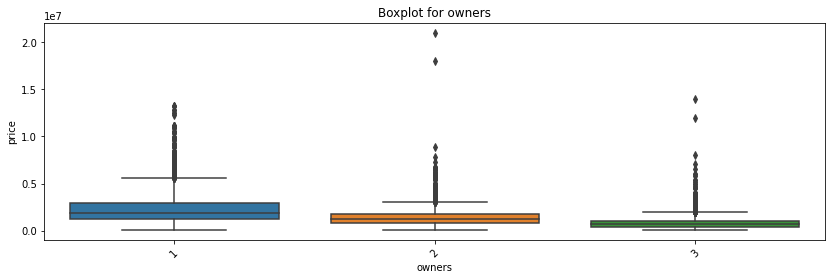

Найдены статистически значимые различия для колонки owners


In [282]:
df_train = df[df.price != 0]
get_boxplot('owners')
get_stat_dif('owners')

### Работа с полем technical_passport

In [283]:
df['technical_passport'].value_counts(dropna=False)

ORIGINAL     12521
Оригинал      3463
DUPLICATE     1869
Дубликат       374
Name: technical_passport, dtype: int64

Это бинарный признак. Также приведем значения к единому формату, а затем заполним пропуски модой.

In [284]:
def clean_technical_passport(value):
    if value == 'ORIGINAL' or value == 'Оригинал':
        return 1
    if value == 'DUPLICATE' or value == 'Дубликат':
        return 0
    return value


df['technical_passport'] = df['technical_passport'].apply(
    clean_technical_passport)
passport_mode = df['technical_passport'].mode()[0]
df['technical_passport'] = df['technical_passport'].apply(
    lambda x: x if x == x else passport_mode)
df['technical_passport'].value_counts(dropna=False)

1    15984
0     2243
Name: technical_passport, dtype: int64

Теперь также посмотрим, как распределены значения, и на важность признака.

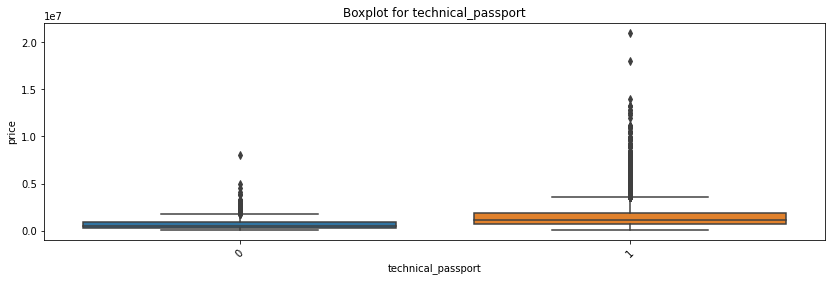

Найдены статистически значимые различия для колонки technical_passport


In [285]:
df_train = df[df.price != 0]
get_boxplot('technical_passport')
get_stat_dif('technical_passport')

### Работа с полем customs

In [286]:
df['customs'].value_counts(dropna=False)

True          14390
Растаможен     3837
Name: customs, dtype: int64

Если привести значения к одному формату, в данном признаке у нас всего одно значение - "Растаможен", а значит, данный признак бесполезен, и его можно удалить.

In [287]:
df.drop(columns=['customs'], axis=1, inplace=True)
df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,{'id': '0'},задний,2,1,436000
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"{'id': '2430196', 'name': '116', 'available_op...",задний,1,1,595000
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1800,136,41000,{'id': '0'},задний,2,1,1150000


### Работа с полем complectation

In [288]:
df['complectation'].unique()

array(["{'id': '0'}",
       "{'id': '2430196', 'name': '116', 'available_options': ['airbag-passenger', 'lock', 'electro-mirrors', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'esp', 'audiopreparation', 'electro-window-back', 'airbag-driver', 'electro-window-front', 'audiosystem-cd', 'wheel-configuration2', 'wheel-configuration1', 'immo']}",
       "{'id': '7707468', 'name': '116i', 'available_options': ['sport-seats', 'multi-wheel', 'xenon', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'esp', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'combo-interior', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'electro-window-front', 'airbag-curtain', 'paint-metallic', 'start-button', 'ptf

Для тестового и тренировочного датасета слишком разный набор значений, обработаем датасеты по отдельности.

In [289]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

#### Обработка тренировочного датасета

In [290]:
def parse_train_complectation(value):
    if value != value or pd.isnull(value):
        return []
    result = value.replace(' ', '')
    result = result.replace("'", '')
    first_bracket = result.find('[')
    second_bracket = result.find(']')
    if first_bracket != -1 and second_bracket != -1:
        return result[first_bracket+1:second_bracket].split(',')
    else:
        return []


df_train['complectation'] = df_train['complectation'].apply(
    parse_train_complectation)

In [291]:
# соберем все уникальные названия в признаке комплектации
from collections import defaultdict

complectation = defaultdict(int)

for value in df_train['complectation']:
    if value == value and value != None:
        for item in value:
            complectation[item] += 1

In [292]:
len(complectation.keys())

141

У нас 141 уникальное значение для тренировочного датасета. Если генерировать по всем ним столбцы с помощью get_dummies, то получится слишком много признаков, так что оставим N наиболее часто встречающихся.

In [293]:
MOST_FREQUENT_NUM = 80
sort_complectation = sorted(complectation.items(),
                            key=lambda x: x[1], reverse=True)
most_frequent_items = []
for item in sort_complectation[:MOST_FREQUENT_NUM]:
    most_frequent_items.append(item[0])

# удалим из списка самых часто встречающихся значений те, которым не нашлось сопоставления на русском языке
# нет данных по: dha,power-latching-doors,reduce-spare-wheel,laminated-safety-glass,drl,sport-pedals,wheel-configuration2
# windcleaner-heat, door-sill-panel,heated-wash-system, music-super, servo, fabric-seats, hcc, wheel-configuration1,
not_existing_items = ['dha', 'power-latching-doors', 'reduce-spare-wheel', 'laminated-safety-glass', 'drl',
                      'sport-pedals', 'wheel-configuration2', 'windcleaner-heat', 'door-sill-panel', 'heated-wash-system',
                      'music-super', 'servo', 'fabric-seats', 'hcc', 'wheel-configuration1']
for item in not_existing_items:
    if item in most_frequent_items:
        most_frequent_items.remove(item)


def fill_complectation_train_item(value):
    if item in value:
        return 1
    else:
        return 0


for item in most_frequent_items:
    df_train[item] = df_train['complectation'].apply(
        fill_complectation_train_item)

df_train.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,...,tyre-pressure,auto-mirrors,alarm,led-lights,sport-seats,17-inch-wheels,navigation,seat-memory,high-beam-assist,18-inch-wheels,adaptive-light,rear-camera,combo-interior,steering-wheel-gear-shift-paddles,keyless-entry,roof-rails,leather-gear-stick,19-inch-wheels,bas,asr,glonass,volume-sensor,decorative-interior-lighting,passenger-seat-updown,power-child-locks-rear-doors
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,[],задний,2,1,436000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"[airbag-passenger, lock, electro-mirrors, comp...",задний,1,1,595000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1800,136,41000,[],задний,2,1,1150000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,хэтчбек,red,бензин,2011,5,2014,автоматическая,1600,136,87284,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,660000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,хэтчбек,white,бензин,2011,5,2013,автоматическая,1600,136,124000,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,575000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Обработка тестового датасета

In [294]:
import json


def parse_test_complectation(value):
    if value != value or pd.isnull(value):
        return []
    value = value.replace("['", '')
    value = value.replace("']", '')
    values = json.loads(value)
    result = []
    for item in values:
        if 'values' in item.keys():
            result.extend(item['values'])
    return result


df_test['complectation'] = df_test['complectation'].apply(
    parse_test_complectation)
df_test.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price
14390,седан,black,дизель,2016,4,2017,автоматическая,2000,190,158836,"[Антипробуксовочная система (ASR), Система ста...",задний,1,1,0
14391,седан,white,дизель,2018,4,2019,автоматическая,2000,150,10,"[Круиз-контроль, Мультифункциональное рулевое ...",задний,1,1,0
14392,седан,blue,бензин,2009,4,2012,автоматическая,4400,407,120000,"[Круиз-контроль, Мультифункциональное рулевое ...",полный,2,1,0
14393,внедорожник,white,дизель,2014,5,2015,автоматическая,3000,249,111466,"[Круиз-контроль, Система «старт-стоп», Электро...",полный,2,1,0
14394,внедорожник,blue,дизель,2014,5,2019,автоматическая,3000,381,11891,"[Круиз-контроль, Электрорегулировка руля, Муль...",полный,1,1,0


In [295]:
# соберем все уникальные названия в признаке комплектации
from collections import defaultdict

complectation_test = defaultdict(int)

for value in df_test['complectation']:
    if value == value and value != None:
        for item in value:
            complectation_test[item] += 1

In [296]:
len(complectation_test.keys())

169

Теперь необходимо сопоставить те признаки, которые мы отобрали в тренировочном датасете - необходимо найти их аналоги в русском датасете.

In [297]:
# Сопоставление данных на английском (df_train) и русском (df_test) языке
train_to_test_complectation = {
    'airbag-driver': 'Подушка безопасности водителя', 'electro-window-front': 'Электростеклоподъёмники передние',
    'lock': 'Центральный замок', 'immo': 'Иммобилайзер', 'abs': 'Антиблокировочная система (ABS)',
    'airbag-passenger': 'Подушка безопасности пассажира', 'electro-mirrors': 'Электроскладывание зеркал',
    'mirrors-heat': 'Электрообогрев боковых зеркал', 'audiopreparation': 'Аудиоподготовка', 'audiosystem-cd': 'Аудиосистема',
    'computer': 'Бортовой компьютер', 'electro-window-back': 'Электростеклоподъёмники задние',
    'airbag-side': 'Подушки безопасности боковые', 'esp': 'Система стабилизации (ESP)',
    'front-seats-heat': 'Подогрев передних сидений', 'seat-transformation': 'Складывающееся заднее сиденье',
    'climate-control-1': 'Климат-контроль 1-зонный', 'condition': 'Кондиционер', 'night-vision': 'Система ночного видения',
    'vsm': 'Система стабилизации рулевого управления (VSM)', 'alcantara': 'Алькантара (Материал салона)',
    'audiosystem-tv': 'Аудиосистема с TV', 'ya-auto': 'Яндекс.Авто', 'massage-seats': 'Сиденья с массажем',
    'dual-xenon': 'Ксеноновые/Биксеноновые фары', 'xenon': 'Ксеноновые/Биксеноновые фары',
    '14-inch-wheels': 'Диски 14', '220v-socket': 'Розетка 220V',
    'isofix-front': 'Крепление детского кресла (передний ряд) ISOFIX',
    'remote-engine-start': 'Дистанционный запуск двигателя', 'front-camera': 'Камера передняя',
    'e-adjustment-wheel': 'Электрорегулировка руля', 'laser-lights': 'Лазерные фары',
    'driver-seat-electric': 'Электрорегулировка сиденья водителя', 'eco-leather': 'Искусственная кожа (Материал салона)',
    '22-inch-wheels': 'Диски 22', 'sport-suspension': 'Спортивная подвеска', 'air-suspension': 'Пневмоподвеска',
    'wheel-memory': 'Рулевая колонка с памятью положения', 'projection-display': 'Проекционный дисплей',
    'android-auto': 'Android Auto', 'rear-seat-heat-vent': 'Вентиляция задних сидений',
    'wireless-charger': 'Беспроводная зарядка для смартфона', '21-inch-wheels': 'Диски 21',
    'activ-suspension': 'Активная подвеска', 'easy-trunk-opening': 'Открытие багажника без помощи рук',
    'programmed-block-heater': 'Программируемый предпусковой отопитель',
    'folding-tables-rear': 'Складной столик на спинках передних сидений',
    'folding-front-passenger-seat': 'Функция складывания спинки сиденья пассажира',
    'entertainment-system-for-rear-seat-passengers': 'Мультимедиа система для задних пассажиров',
    'driver-seat-memory': 'Память сиденья водителя', 'multizone-climate-control': 'Климат-контроль многозонный',
    'body-kit': 'Обвес кузова', 'electronic-gage-panel': 'Электронная приборная панель',
    'driver-seat-updown': 'Регулировка сиденья водителя по высоте', 'spare-wheel': 'Полноразмерное запасное колесо',
    '15-inch-wheels': 'Диски 15', 'apple-carplay': 'CarPlay', 'climate-control-2': 'Климат-контроль 2-зонный',
    'decorative-interior-lighting': 'Декоративная подсветка салона', 'auto-cruise': 'Адаптивный круиз-контроль',
    'passenger-seat-updown': 'Регулировка передних сидений по высоте',
    'roller-blind-for-rear-window': 'Солнцезащитная шторка на заднем стекле',
    'panorama-roof': 'Панорамная крыша / лобовое стекло', 'voice-recognition': 'Голосовое управление',
    '20-inch-wheels': 'Диски 20', 'lane-keeping-assist': 'Система контроля за полосой движения',
    'blind-spot': 'Система контроля слепых зон', 'bas': 'Система помощи при торможении (BAS, EBD)',
    'asr': 'Антипробуксовочная система (ASR)', 'third-row-seats': 'Третий ряд сидений',
    '19-inch-wheels': 'Диски 19', 'glonass': 'ЭРА-ГЛОНАСС', 'airbag-rear-side': 'Подушки безопасности боковые задние',
    '360-camera': 'Камера 360°', 'front-seats-heat-vent': 'Вентиляция передних сидений',
    'combo-interior': 'Комбинированный (Материал салона)', 'auto-park': 'Система автоматической парковки',
    'steel-wheels': 'Стальные диски', '16-inch-wheels': 'Диски 16', 'sport-seats': 'Спортивные передние сиденья',
    'windscreen-heat': 'Электрообогрев лобового стекла', 'collision-prevention-assist': 'Система предотвращения столкновения',
    'drowsy-driver-alert-system': 'Датчик усталости водителя', 'adaptive-light': 'Система адаптивного освещения',
    'high-beam-assist': 'Система управления дальним светом', 'tinted-glass': 'Тонированные стекла',
    'hatch': 'Люк', 'rear-seats-heat': 'Подогрев задних сидений', 
    'knee-airbag': 'Подушка безопасности для защиты коленей водителя',
    'steering-wheel-gear-shift-paddles': 'Подрулевые лепестки переключения передач',
    '18-inch-wheels': 'Диски 18', 'volume-sensor': 'Датчик проникновения в салон (датчик объема)',
    'electro-trunk': 'Электропривод крышки багажника', '17-inch-wheels': 'Диски 17',
    'seat-memory': 'Память передних сидений', 'wheel-heat': 'Обогрев рулевого колеса',
    'led-lights': 'Светодиодные фары', 'keyless-entry': 'Система доступа без ключа',
    'navigation': 'Навигационная система', 'rear-camera': 'Камера задняя',
    'roof-rails': 'Рейлинги на крыше', 'start-stop-function': 'Система «старт-стоп»',
    'start-button': 'Запуск двигателя с кнопки', 'automatic-lighting-control': 'Автоматический корректор фар',
    'tyre-pressure': 'Датчик давления в шинах', 'leather-gear-stick': 'Отделка кожей рычага КПП',
    'ashtray-and-cigarette-lighter': 'Прикуриватель и пепельница',
    'park-assist-f': 'Парктроник передний', 'paint-metallic': 'Металлик', 'auto-mirrors': 'Электропривод зеркал',
    'alarm': 'Сигнализация', 'leather': 'Кожа (Материал салона)', 'park-assist-r': 'Парктроник задний',
    'passenger-seat-electric': 'Электрорегулировка передних сидений', 'light-cleaner': 'Омыватель фар',
    'bluetooth': 'Bluetooth', 'usb': 'USB', '12v-socket': 'Розетка 12V', 'light-sensor': 'Датчик света',
    'rain-sensor': 'Датчик дождя', 'front-centre-armrest': 'Передний центральный подлокотник',
    'wheel-power': 'Усилитель руля', 'third-rear-headrest': 'Третий задний подголовник', 'aux': 'AUX',
    'cruise-control': 'Круиз-контроль', 'airbag-curtain': 'Подушки безопасности оконные (шторки)',
    'multi-wheel': 'Мультифункциональное рулевое колесо', 'wheel-leather': 'Отделка кожей рулевого колеса',
    'isofix': 'Крепление детского кресла (задний ряд) ISOFIX', 'ptf': 'Противотуманные фары',
    'body-mouldings': 'Декоративные молдинги', 'black-roof': 'Отделка потолка чёрной тканью',
    'drive-mode-sys': 'Система выбора режима движения',
    'power-child-locks-rear-doors': 'Блокировка замков задних дверей',
    'cooling-box': 'Охлаждаемый перчаточный ящик', 'electro-rear-seat': 'Электрорегулировка задних сидений'
}

In [298]:
def fill_complectation_test_item(value):
    if train_to_test_complectation[item] in value:
        return 1
    else:
        return 0


for item in most_frequent_items:
    df_test[item] = df_test['complectation'].apply(fill_complectation_test_item)

df_test.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,...,tyre-pressure,auto-mirrors,alarm,led-lights,sport-seats,17-inch-wheels,navigation,seat-memory,high-beam-assist,18-inch-wheels,adaptive-light,rear-camera,combo-interior,steering-wheel-gear-shift-paddles,keyless-entry,roof-rails,leather-gear-stick,19-inch-wheels,bas,asr,glonass,volume-sensor,decorative-interior-lighting,passenger-seat-updown,power-child-locks-rear-doors
14390,седан,black,дизель,2016,4,2017,автоматическая,2000,190,158836,"[Антипробуксовочная система (ASR), Система ста...",задний,1,1,0,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
14391,седан,white,дизель,2018,4,2019,автоматическая,2000,150,10,"[Круиз-контроль, Мультифункциональное рулевое ...",задний,1,1,0,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,1,1,1,0,1,1,0
14392,седан,blue,бензин,2009,4,2012,автоматическая,4400,407,120000,"[Круиз-контроль, Мультифункциональное рулевое ...",полный,2,1,0,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
14393,внедорожник,white,дизель,2014,5,2015,автоматическая,3000,249,111466,"[Круиз-контроль, Система «старт-стоп», Электро...",полный,2,1,0,1,1,1,1,1,1,1,1,1,0,...,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
14394,внедорожник,blue,дизель,2014,5,2019,автоматическая,3000,381,11891,"[Круиз-контроль, Электрорегулировка руля, Муль...",полный,1,1,0,0,1,0,1,1,0,1,1,1,1,...,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1


Теперь мы извлекли дополнительную информацию по наиболее часто встречающимся значениям из комплектации, сформировали новые признаки и привели оба датасета к единому набору признаков. Снова объединим их для удобства обработки данных.

In [299]:
df = pd.concat([df_train, df_test], ignore_index=True)

for col in most_frequent_items:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки airbag-passenger
Найдены статистически значимые различия для колонки abs
Найдены статистически значимые различия для колонки airbag-driver
Найдены статистически значимые различия для колонки lock
Найдены статистически значимые различия для колонки computer
Найдены статистически значимые различия для колонки airbag-side
Найдены статистически значимые различия для колонки esp
Найдены статистически значимые различия для колонки electro-window-front
Найдены статистически значимые различия для колонки immo
Найдены статистически значимые различия для колонки electro-mirrors
Найдены статистически значимые различия для колонки mirrors-heat
Найдены статистически значимые различия для колонки electro-window-back
Найдены статистически значимые различия для колонки ptf
Найдены статистически значимые различия для колонки audiosystem-cd
Найдены статистически значимые различия для колонки audiopreparation
Найдены статистически значимые различия для 

Не найдено статистически значимых различий для признаков xenon и volume-sensor, поэтому можно их сразу удалить из датасета.

In [300]:
df = df.drop(columns=['xenon', 'volume-sensor'], axis=1)

df_train = df[df.price != 0]
df_test = df[df.price == 0]

## Корреляция признаков

### Корреляция числовых признаков

In [301]:
df.head()

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,complectation,drive_type,owners,technical_passport,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,...,electro-trunk,tyre-pressure,auto-mirrors,alarm,led-lights,sport-seats,17-inch-wheels,navigation,seat-memory,high-beam-assist,18-inch-wheels,adaptive-light,rear-camera,combo-interior,steering-wheel-gear-shift-paddles,keyless-entry,roof-rails,leather-gear-stick,19-inch-wheels,bas,asr,glonass,decorative-interior-lighting,passenger-seat-updown,power-child-locks-rear-doors
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,[],задний,2,1,436000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,"[airbag-passenger, lock, electro-mirrors, comp...",задний,1,1,595000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1800,136,41000,[],задний,2,1,1150000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,хэтчбек,red,бензин,2011,5,2014,автоматическая,1600,136,87284,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,660000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,хэтчбек,white,бензин,2011,5,2013,автоматическая,1600,136,124000,"[sport-seats, multi-wheel, xenon, airbag-passe...",задний,3,1,575000,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Для начала посмотрим на корреляцию числовых переменных. Для этого построим heatmap по (предположительно) числовым признакам. Так как нет полной уверенности, что model_date, production_date, engine_displacement и engine_power это числовые (а не ординарные) признаки, проанализируем их и в числовых, и в категориальных.

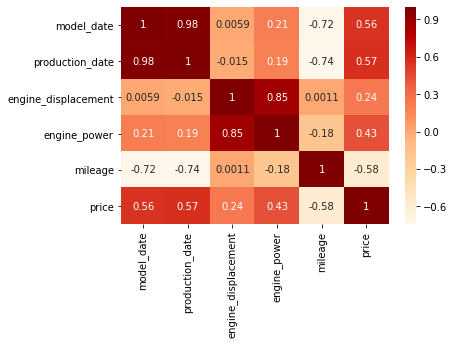

In [302]:
def heatmap(x,y,dataframe):
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()
    
dimension_col_list = ['model_date','production_date','engine_displacement','engine_power','mileage','price']

heatmap(10,10,df_train.filter(dimension_col_list))

Видна сильная корреляция данных между model_date и production_date. Также наблюдается сильная корреляция между engine_displacement и engine_power. Проанализируем эти признаки еще и в категориальных, а пока что удалим признак complectation, так как мы уже достали из него всю необходимую информацию.

In [303]:
df.drop(columns=['complectation'], axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

Посмотрим на важность оставшихся признаков.

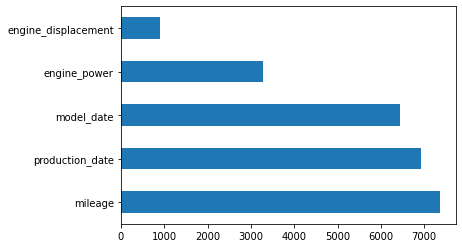

In [304]:
from sklearn.feature_selection import f_regression
from pandas import Series

num_columns = ['model_date', 'production_date',
               'engine_displacement', 'engine_power', 'mileage']
f_test, _ = f_regression(
    df_train[num_columns].values, df_train['price'].values)
imp_num = Series(f_test, index=num_columns)
imp_num.sort_values(ascending=False, inplace=True)
imp_num.plot(kind='barh')

### Корреляция бинарных признаков

Так как тест Стьюдента показал значимость практически на всех нечисловых признаках, попробуем посмотреть значимость признаков по другой метрике. Будем использовать mutual_info_regression из библиотеки sklearn.

In [305]:
import numpy as np

# сформируем список бинарных колонок
def get_binary_columns(datafame):
    binary_cols = []
    for column in datafame.columns:
        vals = datafame[column].unique()
        if len(vals) == 2 and 1 in vals and 0 in vals:
            binary_cols.append(column)
    return binary_cols


binary_columns = get_binary_columns(df_train)
print(binary_columns)

['technical_passport', 'airbag-passenger', 'abs', 'airbag-driver', 'lock', 'computer', 'airbag-side', 'esp', 'electro-window-front', 'immo', 'electro-mirrors', 'mirrors-heat', 'electro-window-back', 'ptf', 'audiosystem-cd', 'audiopreparation', 'airbag-curtain', 'wheel-leather', 'isofix', 'multi-wheel', 'climate-control-1', 'front-seats-heat', 'rain-sensor', 'front-centre-armrest', 'light-sensor', 'condition', 'park-assist-r', 'start-button', 'seat-transformation', 'start-stop-function', 'third-rear-headrest', 'automatic-lighting-control', 'aux', 'light-cleaner', 'cruise-control', 'park-assist-f', 'ashtray-and-cigarette-lighter', '12v-socket', 'usb', 'bluetooth', 'wheel-heat', 'leather', 'passenger-seat-electric', 'paint-metallic', 'wheel-power', 'electro-trunk', 'tyre-pressure', 'auto-mirrors', 'alarm', 'led-lights', 'sport-seats', '17-inch-wheels', 'navigation', 'seat-memory', 'high-beam-assist', '18-inch-wheels', 'adaptive-light', 'rear-camera', 'combo-interior', 'steering-wheel-gear

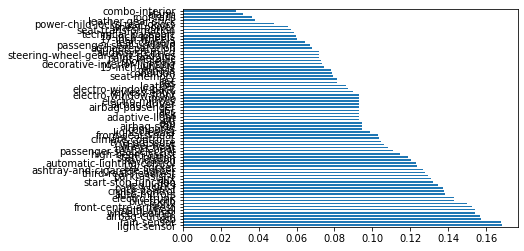

In [306]:
from pandas import Series
from sklearn.feature_selection import mutual_info_regression

imp_bin = Series(mutual_info_regression(
    X=df_train[binary_columns].values, y=df_train['price'].values, discrete_features=True), index=binary_columns)
imp_bin.sort_values(ascending=False, inplace=True)
imp_bin.plot(kind='barh')

Отберем бинарные признаки с важностью выше некоторого порога. Затем попробуем применить к ним корреляцию Мэтьюса для бинарных признаков.

In [307]:
IMPORTANCE = 0.06

print(imp_bin[imp_bin >= IMPORTANCE])

columns_to_delete = list(imp_bin[imp_bin < IMPORTANCE].index)

df.drop(columns=columns_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

light-sensor             0.168207
rain-sensor              0.167589
usb                      0.157268
airbag-curtain           0.156763
wheel-leather            0.154174
                           ...   
audiosystem-cd           0.071579
audiopreparation         0.068381
passenger-seat-updown    0.067158
rear-camera              0.064611
17-inch-wheels           0.060111
Length: 61, dtype: float64


Отберем по корреляции Мэтьюса те бинарные признаки, корреляция которых менее заданного порога.

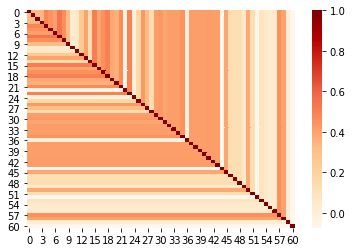

In [308]:
from sklearn.metrics import matthews_corrcoef

binary_columns = list(imp_bin[imp_bin >= IMPORTANCE].index)

# получение матрицы корреляции Мэттьюса
def get_mattiews_correlation(dataframe, columns):
    mattiews_corr = np.zeros((len(columns), len(columns)))
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if j >= i:  # получаем только для половины матрицы, так как она симметрична
                coef = matthews_corrcoef(df_train[col1], df_train[col2])
            mattiews_corr[i, j] = coef
            mattiews_corr[j, i] = coef
    return mattiews_corr


mattiews_corr = get_mattiews_correlation(df_train, binary_columns)
print()

sns.heatmap(mattiews_corr, cmap="OrRd")
plt.show()

In [309]:
binary_to_delete = []
binary_to_implement = []

CORR_VALUE = 0.6

for i, col1 in enumerate(binary_columns):
    if col1 not in binary_to_delete and col1 not in binary_to_implement:
        binary_to_implement.append(col1)
    for j, col2 in enumerate(binary_columns):
        if abs(mattiews_corr[i, j]) >= CORR_VALUE and abs(mattiews_corr[i, j]) != 1:
            if col2 not in binary_to_delete and col2 not in binary_to_implement:
                binary_to_delete.append(col2)

print('Всего отобранных по важности бинарных признаков: {}'.format(len(binary_columns)))
print('Количество бинарных признаков, которые можно оставить: {}'.format(
    len(binary_to_implement)))
print('Количество бинарных признаков, которые нужно убрать: {}'.format(
    len(binary_to_delete)))

Всего отобранных по важности бинарных признаков: 61
Количество бинарных признаков, которые можно оставить: 61
Количество бинарных признаков, которые нужно убрать: 0


In [310]:
df.drop(columns=binary_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,...,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,electro-trunk,tyre-pressure,auto-mirrors,led-lights,sport-seats,17-inch-wheels,navigation,seat-memory,high-beam-assist,adaptive-light,rear-camera,steering-wheel-gear-shift-paddles,keyless-entry,19-inch-wheels,bas,asr,glonass,decorative-interior-lighting,passenger-seat-updown
0,хэтчбек,black,бензин,2007,5,2008,автоматическая,1600,115,115000,задний,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,хэтчбек,black,бензин,2007,5,2011,автоматическая,1600,115,39728,задний,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,хэтчбек,white,бензин,2017,5,2017,автоматическая,1800,136,41000,задний,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Корреляция категориальных (ординарных) признаков

In [311]:
# определим колонки, которые надо переводить в численный вид (уже готовый вид - doors_number и owners)
categorical_columns = ['body_type', 'color',
                       'fuel_type', 'vehicle_configuration', 'drive_type']

for column in categorical_columns:
    if column in df.columns:
        df[column] = pd.Categorical(df[column]).codes

categorical_columns.append('doors_number')
categorical_columns.append('owners')
categorical_columns.append('production_date')
categorical_columns.append('model_date')
categorical_columns.append('engine_displacement')
categorical_columns.append('engine_power')

df.head(3)

,body_type,color,fuel_type,model_date,doors_number,production_date,vehicle_configuration,engine_displacement,engine_power,mileage,drive_type,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,...,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,electro-trunk,tyre-pressure,auto-mirrors,led-lights,sport-seats,17-inch-wheels,navigation,seat-memory,high-beam-assist,adaptive-light,rear-camera,steering-wheel-gear-shift-paddles,keyless-entry,19-inch-wheels,bas,asr,glonass,decorative-interior-lighting,passenger-seat-updown
0,6,0,0,2007,5,2008,0,1600,115,115000,0,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,0,0,2007,5,2011,0,1600,115,39728,0,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,7,0,2017,5,2017,0,1800,136,41000,0,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Теперь все категориальные признаки приведены к числовому формату, применим к ним корреляцию по Кендаллу.

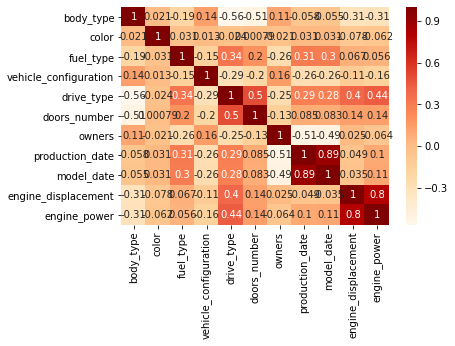

In [312]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

sns.heatmap(df_train.filter(categorical_columns).corr(
    method='kendall'), cmap="OrRd", annot=True)
plt.show()

Корреляция между всеми признаками слабая или умеренная, явной мультиколлинеарности не наблюдается, кроме как между model_date и production_date, а также между engine_power и engine_displacement. Оставим из них признаки production_date и engine_power, после чего попробуем определить важность признаков с помощью mutual_info_regression.

In [313]:
df.drop(columns=['engine_displacement', 'model_date'], axis=1, inplace=True)

categorical_columns = ['body_type', 'color', 'fuel_type', 'vehicle_configuration', 'drive_type',
                       'engine_power', 'owners', 'doors_number', 'production_date']

df_train = df[df.price != 0]
df_test = df[df.price == 0]

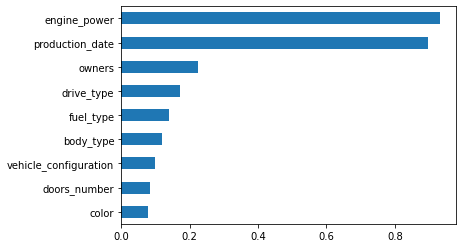

In [314]:
imp_cat = Series(mutual_info_regression(X=df_train[categorical_columns].values,
                                        y=df_train['price'].values, discrete_features=True),
                 index=categorical_columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Отберем наиболее важные признаки со значимостью выше заданного порога.

In [315]:
IMPORTANCE = 0.1
print(imp_cat[imp_cat >= IMPORTANCE])

columns_to_delete = list(imp_cat[imp_cat < IMPORTANCE].index)

df.drop(columns=columns_to_delete, axis=1, inplace=True)
df_train = df[df.price != 0]
df_test = df[df.price == 0]

df.head(3)

body_type          0.117950
fuel_type          0.138225
drive_type         0.170949
owners             0.222727
production_date    0.897541
engine_power       0.933316
dtype: float64


,body_type,fuel_type,production_date,engine_power,mileage,drive_type,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,audiopreparation,airbag-curtain,wheel-leather,...,usb,bluetooth,wheel-heat,leather,passenger-seat-electric,paint-metallic,electro-trunk,tyre-pressure,auto-mirrors,led-lights,sport-seats,17-inch-wheels,navigation,seat-memory,high-beam-assist,adaptive-light,rear-camera,steering-wheel-gear-shift-paddles,keyless-entry,19-inch-wheels,bas,asr,glonass,decorative-interior-lighting,passenger-seat-updown
0,6,0,2008,115,115000,0,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,0,2011,115,39728,0,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,2017,136,41000,0,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Итак, мы оставили в датасете только наиболее важные, на первый взгляд, признаки. Теперь попробуем построить модель на основе полученных данных.

## Предобработка данных перед построением моделей

Чтобы модель принимала данные корректно, необходимо выделить отдельные значения в категориальных (номинативных, закодированных числами) признаках в отдельные признаки, это можно сделать с помощью get_dummies.

In [316]:
categorical_columns = ['body_type', 'fuel_type', 'drive_type']

for col in categorical_columns:
    if col in df.columns:
        col_dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, col_dummies], axis=1)
        df.drop(columns=[col], axis=1, inplace=True)

df.head()

,production_date,engine_power,mileage,owners,price,airbag-passenger,abs,airbag-driver,lock,computer,airbag-side,esp,electro-window-front,immo,electro-mirrors,mirrors-heat,electro-window-back,ptf,audiosystem-cd,audiopreparation,airbag-curtain,wheel-leather,isofix,multi-wheel,climate-control-1,...,high-beam-assist,adaptive-light,rear-camera,steering-wheel-gear-shift-paddles,keyless-entry,19-inch-wheels,bas,asr,glonass,decorative-interior-lighting,passenger-seat-updown,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,fuel_type_0,fuel_type_1,fuel_type_2,fuel_type_3,drive_type_0,drive_type_1,drive_type_2
0,2008,115,115000,2,436000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
1,2011,115,39728,1,595000,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
2,2017,136,41000,2,1150000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
3,2014,136,87284,3,660000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0
4,2013,136,124000,3,575000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0


## Построение модели

Разобьем данные на тренировочные (тренировочные и валидационные) и тестовые.

In [317]:
df_train = df[df.price != 0]
df_test = df[df.price == 0]

In [318]:
for col in df_train.columns:
    df_train[col] = df_train[col].apply(lambda x: int(x))

for col in df_test.columns:
    df_test[col] = df_test[col].apply(lambda x: int(x))

X = df_train.drop(columns=['price'], axis=1)
y = df_train['price']

### CatBoost

Попробуем использовать различные алгоритмы ML для получения наилучшего результата. Начнем с библиотеки CatBoost.

In [319]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

RANDOM_SEED = 42
VAL_SIZE = 0.1

In [320]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_test_target = df_test.drop(columns=['price'], axis=1)

# формируем список идентификаторов признаков для CatBoost
cat_features_ids = np.where(X_train.apply(
    pd.Series.nunique) < 3000)[0].tolist()

In [321]:
ITERATIONS = 6000
LR = 0.05

# обучение базовой модели CatBoost
cat_model = CatBoostRegressor(iterations=ITERATIONS,
                              learning_rate=LR,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE']
                              )
cat_model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose_eval=100,
              use_best_model=True,
              plot=True
              )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.1615525	test: 1.1241385	best: 1.1241385 (0)	total: 87.9ms	remaining: 8m 47s
100:	learn: 0.2282020	test: 0.2098347	best: 0.2098347 (100)	total: 2.24s	remaining: 2m 10s
200:	learn: 0.1854261	test: 0.1734776	best: 0.1734776 (200)	total: 4.46s	remaining: 2m 8s
300:	learn: 0.1686214	test: 0.1590016	best: 0.1590016 (300)	total: 6.46s	remaining: 2m 2s
400:	learn: 0.1599622	test: 0.1519255	best: 0.1519255 (400)	total: 8.31s	remaining: 1m 56s
500:	learn: 0.1534984	test: 0.1471096	best: 0.1471096 (500)	total: 10.3s	remaining: 1m 52s
600:	learn: 0.1489596	test: 0.1435796	best: 0.1435532 (598)	total: 12.2s	remaining: 1m 49s
700:	learn: 0.1456872	test: 0.1408723	best: 0.1408324 (699)	total: 14.3s	remaining: 1m 47s
800:	learn: 0.1434589	test: 0.1395349	best: 0.1395349 (800)	total: 16.3s	remaining: 1m 45s
900:	learn: 0.1411926	test: 0.1384767	best: 0.1384767 (900)	total: 18.2s	remaining: 1m 43s
1000:	learn: 0.1394387	test: 0.1378339	best: 0.1378242 (999)	total: 20.3s	remaining: 1m 41s
110

На базовой модели удалось добиться качества менее чем в 14% ошибки. Посмотрим на важность признаков для этой модели.

In [322]:
features_importances = pd.DataFrame(
    data=cat_model.feature_importances_, index=X.columns, columns=['FeatImportant'])
features_importances.sort_values(by='FeatImportant', ascending=False).head(20)

,FeatImportant
mileage,29.936598
engine_power,25.678621
production_date,11.786180
fuel_type_0,3.045218
drive_type_2,2.854013
passenger-seat-electric,2.708809
drive_type_0,1.860907
navigation,1.616225
body_type_3,1.575609
owners,1.512217


In [339]:
sample_submission = pd.read_csv('sample_submission.csv')
catboost_pred = cat_model.predict(df_test.drop(columns=['price'], axis=1))

# выгрузим объединенные по фолдам результаты в csv
VERSION = 1

# предположительно, данные тренировочного датасета не совсем актуальны по отношению к тестовому датасету
# поэтому домножим полученный результат на выбранный "коэффициент инфляции"
sample_submission['price'] = 0.9 * catboost_pred
sample_submission['price'] = sample_submission['price'].apply(lambda x: int(x))
sample_submission.to_csv(
    f'submission_catboost_base_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1915959
1,1,1415659
2,2,1443841
3,3,2146447
4,4,5385356
5,5,1721282
6,6,1085724
7,7,948499
8,8,1524228
9,9,1249452


### Стекинг

Все параметры для используемых далее моделей подбирались отдельно, чтобы выбрать оптимальные и минимизировать время работы всего кода (подбор осуществлялся с помощью GridSearchCV).

In [328]:
import numpy as np


def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [329]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=RANDOM_SEED, criterion='mae', max_depth=16, min_samples_split=3,
                           min_samples_leaf=3)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print(mape(y_test, dt_pred))

12.922463732146158


In [330]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=RANDOM_SEED, criterion='mse', n_jobs=-1, min_samples_split=7,
                           max_depth=30)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(mape(y_test, rf_pred))

11.912042313860844


In [331]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, n_estimators=200, max_depth=10, learning_rate=0.03,
                        n_jobs=-1)

xgbr.fit(X_train, y_train)
xgbr_pred = xgbr.predict(X_test)
print(mape(y_test, xgbr_pred))

12.097633980474013


In [332]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

df_train = df[df.price != 0]
df_test = df[df.price == 0]

X = df_train.drop(columns=['price'], axis=1)
y = df_train['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_test_target = df_test.drop(columns=['price'], axis=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_target = scaler.transform(X_test_target)

# объявление списка дополнительных моделей для стекинга (плюс catboost, объявленный ранее)
estimators = [('random_forest', rf), ('decision_tree', dt),
              ('catboost', cat_model), ('xgboost', xgbr)]

# выполняем стекинг
reg = StackingRegressor(estimators=estimators,
                        final_estimator=RandomForestRegressor(
                            random_state=RANDOM_SEED, n_jobs=-1)
                        )
reg.fit(X_train, y_train)

0:	learn: 1.1564004	total: 5.48ms	remaining: 32.9s
1:	learn: 1.1090288	total: 11.5ms	remaining: 34.5s
2:	learn: 1.0619938	total: 17.3ms	remaining: 34.5s
3:	learn: 1.0198457	total: 23.2ms	remaining: 34.7s
4:	learn: 0.9797136	total: 29.2ms	remaining: 35s
5:	learn: 0.9478067	total: 35.3ms	remaining: 35.2s
6:	learn: 0.9171892	total: 43ms	remaining: 36.8s
7:	learn: 0.8833031	total: 48.8ms	remaining: 36.6s
8:	learn: 0.8492463	total: 55.2ms	remaining: 36.8s
9:	learn: 0.8171660	total: 61.1ms	remaining: 36.6s
10:	learn: 0.7881702	total: 67.3ms	remaining: 36.6s
11:	learn: 0.7606245	total: 73.1ms	remaining: 36.5s
12:	learn: 0.7330555	total: 78.4ms	remaining: 36.1s
13:	learn: 0.7057265	total: 84.1ms	remaining: 35.9s
14:	learn: 0.6796863	total: 89.4ms	remaining: 35.7s
15:	learn: 0.6580045	total: 96.9ms	remaining: 36.2s
16:	learn: 0.6367177	total: 104ms	remaining: 36.8s
17:	learn: 0.6156780	total: 110ms	remaining: 36.5s
18:	learn: 0.5970125	total: 115ms	remaining: 36.3s
19:	learn: 0.5819705	total: 1

162:	learn: 0.1772924	total: 1.05s	remaining: 37.7s
163:	learn: 0.1771564	total: 1.06s	remaining: 37.7s
164:	learn: 0.1769787	total: 1.06s	remaining: 37.7s
165:	learn: 0.1767770	total: 1.07s	remaining: 37.7s
166:	learn: 0.1766204	total: 1.08s	remaining: 37.8s
167:	learn: 0.1765558	total: 1.09s	remaining: 37.7s
168:	learn: 0.1764774	total: 1.09s	remaining: 37.8s
169:	learn: 0.1764390	total: 1.1s	remaining: 37.7s
170:	learn: 0.1763952	total: 1.1s	remaining: 37.7s
171:	learn: 0.1763219	total: 1.11s	remaining: 37.6s
172:	learn: 0.1762215	total: 1.12s	remaining: 37.6s
173:	learn: 0.1761244	total: 1.12s	remaining: 37.6s
174:	learn: 0.1759845	total: 1.13s	remaining: 37.5s
175:	learn: 0.1758033	total: 1.13s	remaining: 37.5s
176:	learn: 0.1757935	total: 1.14s	remaining: 37.5s
177:	learn: 0.1755812	total: 1.14s	remaining: 37.4s
178:	learn: 0.1754485	total: 1.15s	remaining: 37.4s
179:	learn: 0.1753076	total: 1.16s	remaining: 37.4s
180:	learn: 0.1751214	total: 1.16s	remaining: 37.3s
181:	learn: 0.

336:	learn: 0.1551788	total: 2.1s	remaining: 35.3s
337:	learn: 0.1551712	total: 2.11s	remaining: 35.3s
338:	learn: 0.1549640	total: 2.11s	remaining: 35.3s
339:	learn: 0.1549286	total: 2.12s	remaining: 35.3s
340:	learn: 0.1549138	total: 2.13s	remaining: 35.3s
341:	learn: 0.1548314	total: 2.13s	remaining: 35.3s
342:	learn: 0.1547531	total: 2.14s	remaining: 35.2s
343:	learn: 0.1546409	total: 2.14s	remaining: 35.2s
344:	learn: 0.1546316	total: 2.15s	remaining: 35.2s
345:	learn: 0.1544791	total: 2.15s	remaining: 35.2s
346:	learn: 0.1544668	total: 2.16s	remaining: 35.2s
347:	learn: 0.1544660	total: 2.17s	remaining: 35.2s
348:	learn: 0.1543759	total: 2.17s	remaining: 35.2s
349:	learn: 0.1543730	total: 2.18s	remaining: 35.1s
350:	learn: 0.1543172	total: 2.18s	remaining: 35.1s
351:	learn: 0.1542419	total: 2.19s	remaining: 35.1s
352:	learn: 0.1541483	total: 2.19s	remaining: 35.1s
353:	learn: 0.1540048	total: 2.2s	remaining: 35.1s
354:	learn: 0.1539755	total: 2.2s	remaining: 35.1s
355:	learn: 0.1

509:	learn: 0.1428763	total: 3.14s	remaining: 33.8s
510:	learn: 0.1429003	total: 3.15s	remaining: 33.8s
511:	learn: 0.1427721	total: 3.15s	remaining: 33.8s
512:	learn: 0.1427629	total: 3.16s	remaining: 33.8s
513:	learn: 0.1427244	total: 3.17s	remaining: 33.9s
514:	learn: 0.1427479	total: 3.18s	remaining: 33.9s
515:	learn: 0.1427128	total: 3.19s	remaining: 33.9s
516:	learn: 0.1427100	total: 3.19s	remaining: 33.9s
517:	learn: 0.1427009	total: 3.2s	remaining: 33.9s
518:	learn: 0.1427184	total: 3.21s	remaining: 33.9s
519:	learn: 0.1426779	total: 3.22s	remaining: 33.9s
520:	learn: 0.1426416	total: 3.22s	remaining: 33.9s
521:	learn: 0.1426355	total: 3.23s	remaining: 33.9s
522:	learn: 0.1425963	total: 3.23s	remaining: 33.9s
523:	learn: 0.1425939	total: 3.24s	remaining: 33.8s
524:	learn: 0.1425850	total: 3.24s	remaining: 33.8s
525:	learn: 0.1425482	total: 3.25s	remaining: 33.8s
526:	learn: 0.1425461	total: 3.25s	remaining: 33.8s
527:	learn: 0.1423967	total: 3.26s	remaining: 33.8s
528:	learn: 0

679:	learn: 0.1360285	total: 4.18s	remaining: 32.7s
680:	learn: 0.1360079	total: 4.18s	remaining: 32.7s
681:	learn: 0.1358446	total: 4.19s	remaining: 32.7s
682:	learn: 0.1358261	total: 4.2s	remaining: 32.7s
683:	learn: 0.1357858	total: 4.21s	remaining: 32.7s
684:	learn: 0.1357814	total: 4.21s	remaining: 32.7s
685:	learn: 0.1357820	total: 4.22s	remaining: 32.7s
686:	learn: 0.1357688	total: 4.22s	remaining: 32.7s
687:	learn: 0.1357529	total: 4.23s	remaining: 32.6s
688:	learn: 0.1356925	total: 4.24s	remaining: 32.6s
689:	learn: 0.1356797	total: 4.24s	remaining: 32.6s
690:	learn: 0.1356720	total: 4.25s	remaining: 32.6s
691:	learn: 0.1356802	total: 4.25s	remaining: 32.6s
692:	learn: 0.1356877	total: 4.26s	remaining: 32.6s
693:	learn: 0.1355429	total: 4.26s	remaining: 32.6s
694:	learn: 0.1355394	total: 4.27s	remaining: 32.6s
695:	learn: 0.1355295	total: 4.27s	remaining: 32.6s
696:	learn: 0.1354750	total: 4.28s	remaining: 32.6s
697:	learn: 0.1354255	total: 4.29s	remaining: 32.6s
698:	learn: 0

849:	learn: 0.1313165	total: 5.22s	remaining: 31.6s
850:	learn: 0.1313259	total: 5.22s	remaining: 31.6s
851:	learn: 0.1312579	total: 5.23s	remaining: 31.6s
852:	learn: 0.1312354	total: 5.24s	remaining: 31.6s
853:	learn: 0.1312416	total: 5.24s	remaining: 31.6s
854:	learn: 0.1312324	total: 5.25s	remaining: 31.6s
855:	learn: 0.1312191	total: 5.25s	remaining: 31.6s
856:	learn: 0.1312003	total: 5.26s	remaining: 31.6s
857:	learn: 0.1311880	total: 5.27s	remaining: 31.6s
858:	learn: 0.1311549	total: 5.27s	remaining: 31.6s
859:	learn: 0.1311550	total: 5.28s	remaining: 31.5s
860:	learn: 0.1311531	total: 5.28s	remaining: 31.5s
861:	learn: 0.1311182	total: 5.29s	remaining: 31.5s
862:	learn: 0.1310025	total: 5.29s	remaining: 31.5s
863:	learn: 0.1309741	total: 5.3s	remaining: 31.5s
864:	learn: 0.1309131	total: 5.3s	remaining: 31.5s
865:	learn: 0.1308928	total: 5.31s	remaining: 31.5s
866:	learn: 0.1308750	total: 5.32s	remaining: 31.5s
867:	learn: 0.1308331	total: 5.33s	remaining: 31.5s
868:	learn: 0.

1011:	learn: 0.1279481	total: 6.26s	remaining: 30.8s
1012:	learn: 0.1279524	total: 6.26s	remaining: 30.8s
1013:	learn: 0.1279545	total: 6.27s	remaining: 30.9s
1014:	learn: 0.1278988	total: 6.28s	remaining: 30.9s
1015:	learn: 0.1278842	total: 6.29s	remaining: 30.8s
1016:	learn: 0.1278345	total: 6.3s	remaining: 30.9s
1017:	learn: 0.1278320	total: 6.3s	remaining: 30.9s
1018:	learn: 0.1278343	total: 6.31s	remaining: 30.8s
1019:	learn: 0.1277867	total: 6.32s	remaining: 30.8s
1020:	learn: 0.1277538	total: 6.32s	remaining: 30.8s
1021:	learn: 0.1277121	total: 6.33s	remaining: 30.8s
1022:	learn: 0.1276789	total: 6.34s	remaining: 30.8s
1023:	learn: 0.1276730	total: 6.34s	remaining: 30.8s
1024:	learn: 0.1276587	total: 6.35s	remaining: 30.8s
1025:	learn: 0.1276582	total: 6.36s	remaining: 30.8s
1026:	learn: 0.1276557	total: 6.36s	remaining: 30.8s
1027:	learn: 0.1275830	total: 6.37s	remaining: 30.8s
1028:	learn: 0.1275470	total: 6.38s	remaining: 30.8s
1029:	learn: 0.1275129	total: 6.39s	remaining: 3

1192:	learn: 0.1250374	total: 7.49s	remaining: 30.2s
1193:	learn: 0.1250350	total: 7.49s	remaining: 30.2s
1194:	learn: 0.1250264	total: 7.5s	remaining: 30.2s
1195:	learn: 0.1250113	total: 7.51s	remaining: 30.2s
1196:	learn: 0.1250050	total: 7.51s	remaining: 30.1s
1197:	learn: 0.1249886	total: 7.52s	remaining: 30.1s
1198:	learn: 0.1249806	total: 7.52s	remaining: 30.1s
1199:	learn: 0.1249583	total: 7.53s	remaining: 30.1s
1200:	learn: 0.1248965	total: 7.54s	remaining: 30.1s
1201:	learn: 0.1248863	total: 7.54s	remaining: 30.1s
1202:	learn: 0.1248716	total: 7.55s	remaining: 30.1s
1203:	learn: 0.1248674	total: 7.55s	remaining: 30.1s
1204:	learn: 0.1248686	total: 7.56s	remaining: 30.1s
1205:	learn: 0.1248775	total: 7.56s	remaining: 30.1s
1206:	learn: 0.1248434	total: 7.57s	remaining: 30.1s
1207:	learn: 0.1248570	total: 7.57s	remaining: 30s
1208:	learn: 0.1248594	total: 7.58s	remaining: 30s
1209:	learn: 0.1248502	total: 7.58s	remaining: 30s
1210:	learn: 0.1248329	total: 7.59s	remaining: 30s
12

1364:	learn: 0.1224612	total: 8.52s	remaining: 28.9s
1365:	learn: 0.1224611	total: 8.53s	remaining: 28.9s
1366:	learn: 0.1224477	total: 8.54s	remaining: 28.9s
1367:	learn: 0.1224427	total: 8.54s	remaining: 28.9s
1368:	learn: 0.1224369	total: 8.55s	remaining: 28.9s
1369:	learn: 0.1224201	total: 8.56s	remaining: 28.9s
1370:	learn: 0.1224071	total: 8.56s	remaining: 28.9s
1371:	learn: 0.1223934	total: 8.57s	remaining: 28.9s
1372:	learn: 0.1223727	total: 8.57s	remaining: 28.9s
1373:	learn: 0.1223697	total: 8.58s	remaining: 28.9s
1374:	learn: 0.1223394	total: 8.59s	remaining: 28.9s
1375:	learn: 0.1223365	total: 8.59s	remaining: 28.9s
1376:	learn: 0.1223335	total: 8.6s	remaining: 28.9s
1377:	learn: 0.1223306	total: 8.61s	remaining: 28.9s
1378:	learn: 0.1223277	total: 8.61s	remaining: 28.9s
1379:	learn: 0.1223132	total: 8.62s	remaining: 28.8s
1380:	learn: 0.1223110	total: 8.62s	remaining: 28.8s
1381:	learn: 0.1222916	total: 8.63s	remaining: 28.8s
1382:	learn: 0.1222816	total: 8.63s	remaining: 

1537:	learn: 0.1203610	total: 9.56s	remaining: 27.7s
1538:	learn: 0.1203399	total: 9.57s	remaining: 27.7s
1539:	learn: 0.1203146	total: 9.57s	remaining: 27.7s
1540:	learn: 0.1203132	total: 9.58s	remaining: 27.7s
1541:	learn: 0.1202941	total: 9.59s	remaining: 27.7s
1542:	learn: 0.1202478	total: 9.59s	remaining: 27.7s
1543:	learn: 0.1202230	total: 9.6s	remaining: 27.7s
1544:	learn: 0.1202157	total: 9.6s	remaining: 27.7s
1545:	learn: 0.1201862	total: 9.61s	remaining: 27.7s
1546:	learn: 0.1201412	total: 9.61s	remaining: 27.7s
1547:	learn: 0.1201265	total: 9.62s	remaining: 27.7s
1548:	learn: 0.1201164	total: 9.63s	remaining: 27.7s
1549:	learn: 0.1200905	total: 9.63s	remaining: 27.6s
1550:	learn: 0.1200771	total: 9.63s	remaining: 27.6s
1551:	learn: 0.1200606	total: 9.65s	remaining: 27.7s
1552:	learn: 0.1200563	total: 9.66s	remaining: 27.7s
1553:	learn: 0.1200574	total: 9.67s	remaining: 27.7s
1554:	learn: 0.1200565	total: 9.68s	remaining: 27.7s
1555:	learn: 0.1200486	total: 9.68s	remaining: 2

1697:	learn: 0.1185082	total: 10.6s	remaining: 26.9s
1698:	learn: 0.1185000	total: 10.6s	remaining: 26.9s
1699:	learn: 0.1184977	total: 10.6s	remaining: 26.9s
1700:	learn: 0.1185005	total: 10.6s	remaining: 26.9s
1701:	learn: 0.1184974	total: 10.6s	remaining: 26.9s
1702:	learn: 0.1184685	total: 10.6s	remaining: 26.8s
1703:	learn: 0.1184274	total: 10.6s	remaining: 26.8s
1704:	learn: 0.1184211	total: 10.7s	remaining: 26.8s
1705:	learn: 0.1184135	total: 10.7s	remaining: 26.8s
1706:	learn: 0.1183667	total: 10.7s	remaining: 26.8s
1707:	learn: 0.1183632	total: 10.7s	remaining: 26.8s
1708:	learn: 0.1183498	total: 10.7s	remaining: 26.8s
1709:	learn: 0.1183408	total: 10.7s	remaining: 26.8s
1710:	learn: 0.1183322	total: 10.7s	remaining: 26.8s
1711:	learn: 0.1183345	total: 10.7s	remaining: 26.8s
1712:	learn: 0.1183050	total: 10.7s	remaining: 26.8s
1713:	learn: 0.1182449	total: 10.7s	remaining: 26.8s
1714:	learn: 0.1182212	total: 10.7s	remaining: 26.8s
1715:	learn: 0.1182142	total: 10.7s	remaining:

1870:	learn: 0.1166992	total: 11.6s	remaining: 25.7s
1871:	learn: 0.1166913	total: 11.6s	remaining: 25.7s
1872:	learn: 0.1166739	total: 11.7s	remaining: 25.7s
1873:	learn: 0.1166424	total: 11.7s	remaining: 25.7s
1874:	learn: 0.1166292	total: 11.7s	remaining: 25.7s
1875:	learn: 0.1166193	total: 11.7s	remaining: 25.7s
1876:	learn: 0.1166113	total: 11.7s	remaining: 25.7s
1877:	learn: 0.1165968	total: 11.7s	remaining: 25.6s
1878:	learn: 0.1165685	total: 11.7s	remaining: 25.6s
1879:	learn: 0.1165484	total: 11.7s	remaining: 25.6s
1880:	learn: 0.1165445	total: 11.7s	remaining: 25.6s
1881:	learn: 0.1165427	total: 11.7s	remaining: 25.6s
1882:	learn: 0.1165271	total: 11.7s	remaining: 25.6s
1883:	learn: 0.1165039	total: 11.7s	remaining: 25.6s
1884:	learn: 0.1165063	total: 11.7s	remaining: 25.6s
1885:	learn: 0.1165065	total: 11.7s	remaining: 25.6s
1886:	learn: 0.1164994	total: 11.7s	remaining: 25.6s
1887:	learn: 0.1164561	total: 11.7s	remaining: 25.6s
1888:	learn: 0.1164313	total: 11.7s	remaining:

2041:	learn: 0.1148012	total: 12.7s	remaining: 24.6s
2042:	learn: 0.1148008	total: 12.7s	remaining: 24.6s
2043:	learn: 0.1148025	total: 12.7s	remaining: 24.6s
2044:	learn: 0.1147914	total: 12.7s	remaining: 24.6s
2045:	learn: 0.1147831	total: 12.7s	remaining: 24.6s
2046:	learn: 0.1147752	total: 12.7s	remaining: 24.6s
2047:	learn: 0.1147749	total: 12.7s	remaining: 24.6s
2048:	learn: 0.1147695	total: 12.7s	remaining: 24.5s
2049:	learn: 0.1147718	total: 12.7s	remaining: 24.5s
2050:	learn: 0.1147619	total: 12.7s	remaining: 24.5s
2051:	learn: 0.1147654	total: 12.7s	remaining: 24.5s
2052:	learn: 0.1147382	total: 12.8s	remaining: 24.5s
2053:	learn: 0.1147345	total: 12.8s	remaining: 24.5s
2054:	learn: 0.1146946	total: 12.8s	remaining: 24.5s
2055:	learn: 0.1146896	total: 12.8s	remaining: 24.5s
2056:	learn: 0.1146852	total: 12.8s	remaining: 24.5s
2057:	learn: 0.1146782	total: 12.8s	remaining: 24.5s
2058:	learn: 0.1146706	total: 12.8s	remaining: 24.5s
2059:	learn: 0.1146671	total: 12.8s	remaining:

2214:	learn: 0.1131233	total: 13.7s	remaining: 23.4s
2215:	learn: 0.1131068	total: 13.7s	remaining: 23.4s
2216:	learn: 0.1131026	total: 13.7s	remaining: 23.4s
2217:	learn: 0.1131033	total: 13.7s	remaining: 23.4s
2218:	learn: 0.1131060	total: 13.8s	remaining: 23.4s
2219:	learn: 0.1131036	total: 13.8s	remaining: 23.4s
2220:	learn: 0.1131017	total: 13.8s	remaining: 23.4s
2221:	learn: 0.1131063	total: 13.8s	remaining: 23.4s
2222:	learn: 0.1130862	total: 13.8s	remaining: 23.4s
2223:	learn: 0.1130857	total: 13.8s	remaining: 23.4s
2224:	learn: 0.1130845	total: 13.8s	remaining: 23.4s
2225:	learn: 0.1130689	total: 13.8s	remaining: 23.4s
2226:	learn: 0.1130508	total: 13.8s	remaining: 23.4s
2227:	learn: 0.1130415	total: 13.8s	remaining: 23.4s
2228:	learn: 0.1130452	total: 13.8s	remaining: 23.4s
2229:	learn: 0.1130459	total: 13.8s	remaining: 23.4s
2230:	learn: 0.1130322	total: 13.8s	remaining: 23.3s
2231:	learn: 0.1130229	total: 13.8s	remaining: 23.3s
2232:	learn: 0.1130217	total: 13.8s	remaining:

2386:	learn: 0.1116817	total: 14.8s	remaining: 22.3s
2387:	learn: 0.1116683	total: 14.8s	remaining: 22.3s
2388:	learn: 0.1116532	total: 14.8s	remaining: 22.3s
2389:	learn: 0.1116501	total: 14.8s	remaining: 22.3s
2390:	learn: 0.1116478	total: 14.8s	remaining: 22.3s
2391:	learn: 0.1116290	total: 14.8s	remaining: 22.3s
2392:	learn: 0.1116258	total: 14.8s	remaining: 22.3s
2393:	learn: 0.1116012	total: 14.8s	remaining: 22.3s
2394:	learn: 0.1115867	total: 14.8s	remaining: 22.3s
2395:	learn: 0.1115529	total: 14.8s	remaining: 22.3s
2396:	learn: 0.1115377	total: 14.8s	remaining: 22.3s
2397:	learn: 0.1115115	total: 14.8s	remaining: 22.3s
2398:	learn: 0.1115011	total: 14.8s	remaining: 22.3s
2399:	learn: 0.1114755	total: 14.8s	remaining: 22.3s
2400:	learn: 0.1114649	total: 14.8s	remaining: 22.3s
2401:	learn: 0.1114448	total: 14.9s	remaining: 22.2s
2402:	learn: 0.1114430	total: 14.9s	remaining: 22.2s
2403:	learn: 0.1114389	total: 14.9s	remaining: 22.2s
2404:	learn: 0.1114226	total: 14.9s	remaining:

2557:	learn: 0.1100523	total: 15.8s	remaining: 21.3s
2558:	learn: 0.1100431	total: 15.8s	remaining: 21.3s
2559:	learn: 0.1100449	total: 15.8s	remaining: 21.3s
2560:	learn: 0.1100342	total: 15.8s	remaining: 21.3s
2561:	learn: 0.1100288	total: 15.8s	remaining: 21.2s
2562:	learn: 0.1100255	total: 15.8s	remaining: 21.2s
2563:	learn: 0.1100205	total: 15.8s	remaining: 21.2s
2564:	learn: 0.1100143	total: 15.9s	remaining: 21.2s
2565:	learn: 0.1100121	total: 15.9s	remaining: 21.2s
2566:	learn: 0.1100083	total: 15.9s	remaining: 21.2s
2567:	learn: 0.1100080	total: 15.9s	remaining: 21.2s
2568:	learn: 0.1100035	total: 15.9s	remaining: 21.2s
2569:	learn: 0.1099804	total: 15.9s	remaining: 21.2s
2570:	learn: 0.1099811	total: 15.9s	remaining: 21.2s
2571:	learn: 0.1099648	total: 15.9s	remaining: 21.2s
2572:	learn: 0.1099622	total: 15.9s	remaining: 21.2s
2573:	learn: 0.1099600	total: 15.9s	remaining: 21.2s
2574:	learn: 0.1099397	total: 15.9s	remaining: 21.2s
2575:	learn: 0.1099302	total: 15.9s	remaining:

2728:	learn: 0.1087654	total: 16.8s	remaining: 20.2s
2729:	learn: 0.1087556	total: 16.9s	remaining: 20.2s
2730:	learn: 0.1087386	total: 16.9s	remaining: 20.2s
2731:	learn: 0.1087248	total: 16.9s	remaining: 20.2s
2732:	learn: 0.1087238	total: 16.9s	remaining: 20.2s
2733:	learn: 0.1087215	total: 16.9s	remaining: 20.2s
2734:	learn: 0.1087246	total: 16.9s	remaining: 20.2s
2735:	learn: 0.1087178	total: 16.9s	remaining: 20.1s
2736:	learn: 0.1087099	total: 16.9s	remaining: 20.1s
2737:	learn: 0.1087040	total: 16.9s	remaining: 20.1s
2738:	learn: 0.1087066	total: 16.9s	remaining: 20.1s
2739:	learn: 0.1087033	total: 16.9s	remaining: 20.1s
2740:	learn: 0.1086941	total: 16.9s	remaining: 20.1s
2741:	learn: 0.1086825	total: 16.9s	remaining: 20.1s
2742:	learn: 0.1086781	total: 16.9s	remaining: 20.1s
2743:	learn: 0.1086688	total: 16.9s	remaining: 20.1s
2744:	learn: 0.1086512	total: 16.9s	remaining: 20.1s
2745:	learn: 0.1086392	total: 16.9s	remaining: 20.1s
2746:	learn: 0.1086205	total: 16.9s	remaining:

2900:	learn: 0.1074882	total: 17.9s	remaining: 19.1s
2901:	learn: 0.1074804	total: 17.9s	remaining: 19.1s
2902:	learn: 0.1074710	total: 17.9s	remaining: 19.1s
2903:	learn: 0.1074698	total: 17.9s	remaining: 19.1s
2904:	learn: 0.1074693	total: 17.9s	remaining: 19.1s
2905:	learn: 0.1074584	total: 17.9s	remaining: 19.1s
2906:	learn: 0.1074583	total: 17.9s	remaining: 19.1s
2907:	learn: 0.1074509	total: 17.9s	remaining: 19.1s
2908:	learn: 0.1074369	total: 17.9s	remaining: 19.1s
2909:	learn: 0.1074300	total: 17.9s	remaining: 19s
2910:	learn: 0.1074252	total: 17.9s	remaining: 19s
2911:	learn: 0.1074136	total: 17.9s	remaining: 19s
2912:	learn: 0.1073991	total: 18s	remaining: 19s
2913:	learn: 0.1073972	total: 18s	remaining: 19s
2914:	learn: 0.1073898	total: 18s	remaining: 19s
2915:	learn: 0.1073859	total: 18s	remaining: 19s
2916:	learn: 0.1073874	total: 18s	remaining: 19s
2917:	learn: 0.1073821	total: 18s	remaining: 19s
2918:	learn: 0.1073799	total: 18s	remaining: 19s
2919:	learn: 0.1073731	tota

3071:	learn: 0.1063798	total: 18.9s	remaining: 18s
3072:	learn: 0.1063500	total: 18.9s	remaining: 18s
3073:	learn: 0.1063275	total: 18.9s	remaining: 18s
3074:	learn: 0.1063080	total: 18.9s	remaining: 18s
3075:	learn: 0.1062998	total: 19s	remaining: 18s
3076:	learn: 0.1062931	total: 19s	remaining: 18s
3077:	learn: 0.1062710	total: 19s	remaining: 18s
3078:	learn: 0.1062542	total: 19s	remaining: 18s
3079:	learn: 0.1062471	total: 19s	remaining: 18s
3080:	learn: 0.1062388	total: 19s	remaining: 18s
3081:	learn: 0.1062312	total: 19s	remaining: 18s
3082:	learn: 0.1062255	total: 19s	remaining: 18s
3083:	learn: 0.1062219	total: 19s	remaining: 18s
3084:	learn: 0.1061947	total: 19s	remaining: 18s
3085:	learn: 0.1061948	total: 19s	remaining: 17.9s
3086:	learn: 0.1061890	total: 19s	remaining: 17.9s
3087:	learn: 0.1061872	total: 19s	remaining: 17.9s
3088:	learn: 0.1061819	total: 19s	remaining: 17.9s
3089:	learn: 0.1061769	total: 19s	remaining: 17.9s
3090:	learn: 0.1061668	total: 19s	remaining: 17.9s


3244:	learn: 0.1051857	total: 20s	remaining: 16.9s
3245:	learn: 0.1051812	total: 20s	remaining: 16.9s
3246:	learn: 0.1051787	total: 20s	remaining: 16.9s
3247:	learn: 0.1051772	total: 20s	remaining: 16.9s
3248:	learn: 0.1051731	total: 20s	remaining: 16.9s
3249:	learn: 0.1051668	total: 20s	remaining: 16.9s
3250:	learn: 0.1051479	total: 20s	remaining: 16.9s
3251:	learn: 0.1051476	total: 20s	remaining: 16.9s
3252:	learn: 0.1051461	total: 20s	remaining: 16.9s
3253:	learn: 0.1051438	total: 20s	remaining: 16.9s
3254:	learn: 0.1051398	total: 20s	remaining: 16.9s
3255:	learn: 0.1051386	total: 20s	remaining: 16.9s
3256:	learn: 0.1051383	total: 20s	remaining: 16.9s
3257:	learn: 0.1051407	total: 20s	remaining: 16.9s
3258:	learn: 0.1051335	total: 20.1s	remaining: 16.9s
3259:	learn: 0.1051273	total: 20.1s	remaining: 16.9s
3260:	learn: 0.1051194	total: 20.1s	remaining: 16.9s
3261:	learn: 0.1051148	total: 20.1s	remaining: 16.8s
3262:	learn: 0.1051093	total: 20.1s	remaining: 16.8s
3263:	learn: 0.105106

3416:	learn: 0.1042078	total: 21s	remaining: 15.9s
3417:	learn: 0.1042069	total: 21s	remaining: 15.9s
3418:	learn: 0.1042027	total: 21s	remaining: 15.9s
3419:	learn: 0.1042009	total: 21s	remaining: 15.9s
3420:	learn: 0.1041974	total: 21s	remaining: 15.9s
3421:	learn: 0.1041948	total: 21s	remaining: 15.8s
3422:	learn: 0.1041917	total: 21s	remaining: 15.8s
3423:	learn: 0.1041881	total: 21s	remaining: 15.8s
3424:	learn: 0.1041877	total: 21.1s	remaining: 15.8s
3425:	learn: 0.1041735	total: 21.1s	remaining: 15.8s
3426:	learn: 0.1041737	total: 21.1s	remaining: 15.8s
3427:	learn: 0.1041728	total: 21.1s	remaining: 15.8s
3428:	learn: 0.1041606	total: 21.1s	remaining: 15.8s
3429:	learn: 0.1041532	total: 21.1s	remaining: 15.8s
3430:	learn: 0.1041404	total: 21.1s	remaining: 15.8s
3431:	learn: 0.1041417	total: 21.1s	remaining: 15.8s
3432:	learn: 0.1041345	total: 21.1s	remaining: 15.8s
3433:	learn: 0.1041323	total: 21.1s	remaining: 15.8s
3434:	learn: 0.1041298	total: 21.1s	remaining: 15.8s
3435:	lea

3586:	learn: 0.1032867	total: 22s	remaining: 14.8s
3587:	learn: 0.1032851	total: 22.1s	remaining: 14.8s
3588:	learn: 0.1032808	total: 22.1s	remaining: 14.8s
3589:	learn: 0.1032758	total: 22.1s	remaining: 14.8s
3590:	learn: 0.1032508	total: 22.1s	remaining: 14.8s
3591:	learn: 0.1032448	total: 22.1s	remaining: 14.8s
3592:	learn: 0.1032454	total: 22.1s	remaining: 14.8s
3593:	learn: 0.1032439	total: 22.1s	remaining: 14.8s
3594:	learn: 0.1032351	total: 22.1s	remaining: 14.8s
3595:	learn: 0.1032356	total: 22.1s	remaining: 14.8s
3596:	learn: 0.1032320	total: 22.1s	remaining: 14.8s
3597:	learn: 0.1032262	total: 22.1s	remaining: 14.8s
3598:	learn: 0.1032237	total: 22.1s	remaining: 14.8s
3599:	learn: 0.1032114	total: 22.1s	remaining: 14.7s
3600:	learn: 0.1031963	total: 22.1s	remaining: 14.7s
3601:	learn: 0.1031920	total: 22.1s	remaining: 14.7s
3602:	learn: 0.1031936	total: 22.1s	remaining: 14.7s
3603:	learn: 0.1031814	total: 22.1s	remaining: 14.7s
3604:	learn: 0.1031745	total: 22.1s	remaining: 1

3757:	learn: 0.1023545	total: 23.1s	remaining: 13.8s
3758:	learn: 0.1023577	total: 23.1s	remaining: 13.8s
3759:	learn: 0.1023547	total: 23.1s	remaining: 13.8s
3760:	learn: 0.1023427	total: 23.1s	remaining: 13.8s
3761:	learn: 0.1023338	total: 23.1s	remaining: 13.8s
3762:	learn: 0.1023195	total: 23.1s	remaining: 13.7s
3763:	learn: 0.1023184	total: 23.1s	remaining: 13.7s
3764:	learn: 0.1023139	total: 23.1s	remaining: 13.7s
3765:	learn: 0.1023096	total: 23.1s	remaining: 13.7s
3766:	learn: 0.1023057	total: 23.1s	remaining: 13.7s
3767:	learn: 0.1022948	total: 23.1s	remaining: 13.7s
3768:	learn: 0.1022836	total: 23.2s	remaining: 13.7s
3769:	learn: 0.1022812	total: 23.2s	remaining: 13.7s
3770:	learn: 0.1022795	total: 23.2s	remaining: 13.7s
3771:	learn: 0.1022739	total: 23.2s	remaining: 13.7s
3772:	learn: 0.1022682	total: 23.2s	remaining: 13.7s
3773:	learn: 0.1022443	total: 23.2s	remaining: 13.7s
3774:	learn: 0.1022415	total: 23.2s	remaining: 13.7s
3775:	learn: 0.1022390	total: 23.2s	remaining:

3927:	learn: 0.1014221	total: 24.1s	remaining: 12.7s
3928:	learn: 0.1014213	total: 24.1s	remaining: 12.7s
3929:	learn: 0.1014211	total: 24.1s	remaining: 12.7s
3930:	learn: 0.1014180	total: 24.1s	remaining: 12.7s
3931:	learn: 0.1014180	total: 24.2s	remaining: 12.7s
3932:	learn: 0.1014078	total: 24.2s	remaining: 12.7s
3933:	learn: 0.1014064	total: 24.2s	remaining: 12.7s
3934:	learn: 0.1013987	total: 24.2s	remaining: 12.7s
3935:	learn: 0.1013936	total: 24.2s	remaining: 12.7s
3936:	learn: 0.1013810	total: 24.2s	remaining: 12.7s
3937:	learn: 0.1013806	total: 24.2s	remaining: 12.7s
3938:	learn: 0.1013697	total: 24.2s	remaining: 12.7s
3939:	learn: 0.1013651	total: 24.2s	remaining: 12.7s
3940:	learn: 0.1013633	total: 24.2s	remaining: 12.6s
3941:	learn: 0.1013602	total: 24.2s	remaining: 12.6s
3942:	learn: 0.1013608	total: 24.2s	remaining: 12.6s
3943:	learn: 0.1013603	total: 24.2s	remaining: 12.6s
3944:	learn: 0.1013331	total: 24.2s	remaining: 12.6s
3945:	learn: 0.1013322	total: 24.2s	remaining:

4099:	learn: 0.1004357	total: 25.2s	remaining: 11.7s
4100:	learn: 0.1004293	total: 25.2s	remaining: 11.7s
4101:	learn: 0.1004291	total: 25.2s	remaining: 11.7s
4102:	learn: 0.1004151	total: 25.2s	remaining: 11.6s
4103:	learn: 0.1004203	total: 25.2s	remaining: 11.6s
4104:	learn: 0.1004162	total: 25.2s	remaining: 11.6s
4105:	learn: 0.1004083	total: 25.2s	remaining: 11.6s
4106:	learn: 0.1004091	total: 25.2s	remaining: 11.6s
4107:	learn: 0.1003987	total: 25.2s	remaining: 11.6s
4108:	learn: 0.1003954	total: 25.2s	remaining: 11.6s
4109:	learn: 0.1003928	total: 25.2s	remaining: 11.6s
4110:	learn: 0.1003892	total: 25.2s	remaining: 11.6s
4111:	learn: 0.1003860	total: 25.2s	remaining: 11.6s
4112:	learn: 0.1003710	total: 25.3s	remaining: 11.6s
4113:	learn: 0.1003602	total: 25.3s	remaining: 11.6s
4114:	learn: 0.1003584	total: 25.3s	remaining: 11.6s
4115:	learn: 0.1003529	total: 25.3s	remaining: 11.6s
4116:	learn: 0.1003518	total: 25.3s	remaining: 11.6s
4117:	learn: 0.1003541	total: 25.3s	remaining:

4271:	learn: 0.0996162	total: 26.2s	remaining: 10.6s
4272:	learn: 0.0996160	total: 26.2s	remaining: 10.6s
4273:	learn: 0.0996052	total: 26.2s	remaining: 10.6s
4274:	learn: 0.0995962	total: 26.2s	remaining: 10.6s
4275:	learn: 0.0995922	total: 26.2s	remaining: 10.6s
4276:	learn: 0.0995882	total: 26.2s	remaining: 10.6s
4277:	learn: 0.0995871	total: 26.2s	remaining: 10.6s
4278:	learn: 0.0995808	total: 26.3s	remaining: 10.6s
4279:	learn: 0.0995778	total: 26.3s	remaining: 10.6s
4280:	learn: 0.0995793	total: 26.3s	remaining: 10.5s
4281:	learn: 0.0995749	total: 26.3s	remaining: 10.5s
4282:	learn: 0.0995670	total: 26.3s	remaining: 10.5s
4283:	learn: 0.0995582	total: 26.3s	remaining: 10.5s
4284:	learn: 0.0995554	total: 26.3s	remaining: 10.5s
4285:	learn: 0.0995531	total: 26.3s	remaining: 10.5s
4286:	learn: 0.0995427	total: 26.3s	remaining: 10.5s
4287:	learn: 0.0995375	total: 26.3s	remaining: 10.5s
4288:	learn: 0.0995267	total: 26.3s	remaining: 10.5s
4289:	learn: 0.0995144	total: 26.3s	remaining:

4442:	learn: 0.0988374	total: 27.2s	remaining: 9.55s
4443:	learn: 0.0988353	total: 27.3s	remaining: 9.54s
4444:	learn: 0.0988343	total: 27.3s	remaining: 9.54s
4445:	learn: 0.0988222	total: 27.3s	remaining: 9.53s
4446:	learn: 0.0988162	total: 27.3s	remaining: 9.53s
4447:	learn: 0.0988137	total: 27.3s	remaining: 9.52s
4448:	learn: 0.0988042	total: 27.3s	remaining: 9.51s
4449:	learn: 0.0988023	total: 27.3s	remaining: 9.51s
4450:	learn: 0.0988006	total: 27.3s	remaining: 9.5s
4451:	learn: 0.0987982	total: 27.3s	remaining: 9.49s
4452:	learn: 0.0987950	total: 27.3s	remaining: 9.49s
4453:	learn: 0.0987854	total: 27.3s	remaining: 9.48s
4454:	learn: 0.0987839	total: 27.3s	remaining: 9.47s
4455:	learn: 0.0987783	total: 27.3s	remaining: 9.47s
4456:	learn: 0.0987736	total: 27.3s	remaining: 9.46s
4457:	learn: 0.0987725	total: 27.3s	remaining: 9.46s
4458:	learn: 0.0987725	total: 27.3s	remaining: 9.45s
4459:	learn: 0.0987685	total: 27.3s	remaining: 9.44s
4460:	learn: 0.0987565	total: 27.4s	remaining: 

4613:	learn: 0.0979964	total: 28.3s	remaining: 8.49s
4614:	learn: 0.0979997	total: 28.3s	remaining: 8.49s
4615:	learn: 0.0979963	total: 28.3s	remaining: 8.48s
4616:	learn: 0.0979882	total: 28.3s	remaining: 8.48s
4617:	learn: 0.0979882	total: 28.3s	remaining: 8.47s
4618:	learn: 0.0979869	total: 28.3s	remaining: 8.47s
4619:	learn: 0.0979801	total: 28.3s	remaining: 8.46s
4620:	learn: 0.0979861	total: 28.3s	remaining: 8.45s
4621:	learn: 0.0979892	total: 28.3s	remaining: 8.45s
4622:	learn: 0.0979861	total: 28.3s	remaining: 8.44s
4623:	learn: 0.0979841	total: 28.3s	remaining: 8.44s
4624:	learn: 0.0979757	total: 28.4s	remaining: 8.43s
4625:	learn: 0.0979702	total: 28.4s	remaining: 8.42s
4626:	learn: 0.0979684	total: 28.4s	remaining: 8.42s
4627:	learn: 0.0979656	total: 28.4s	remaining: 8.41s
4628:	learn: 0.0979585	total: 28.4s	remaining: 8.4s
4629:	learn: 0.0979569	total: 28.4s	remaining: 8.4s
4630:	learn: 0.0979480	total: 28.4s	remaining: 8.39s
4631:	learn: 0.0979463	total: 28.4s	remaining: 8

4783:	learn: 0.0972918	total: 29.3s	remaining: 7.45s
4784:	learn: 0.0972900	total: 29.3s	remaining: 7.45s
4785:	learn: 0.0972848	total: 29.3s	remaining: 7.44s
4786:	learn: 0.0972853	total: 29.3s	remaining: 7.44s
4787:	learn: 0.0972834	total: 29.4s	remaining: 7.43s
4788:	learn: 0.0972822	total: 29.4s	remaining: 7.42s
4789:	learn: 0.0972733	total: 29.4s	remaining: 7.42s
4790:	learn: 0.0972747	total: 29.4s	remaining: 7.41s
4791:	learn: 0.0972687	total: 29.4s	remaining: 7.41s
4792:	learn: 0.0972642	total: 29.4s	remaining: 7.4s
4793:	learn: 0.0972588	total: 29.4s	remaining: 7.39s
4794:	learn: 0.0972604	total: 29.4s	remaining: 7.39s
4795:	learn: 0.0972567	total: 29.4s	remaining: 7.38s
4796:	learn: 0.0972528	total: 29.4s	remaining: 7.37s
4797:	learn: 0.0972455	total: 29.4s	remaining: 7.37s
4798:	learn: 0.0972295	total: 29.4s	remaining: 7.36s
4799:	learn: 0.0972264	total: 29.4s	remaining: 7.36s
4800:	learn: 0.0972244	total: 29.4s	remaining: 7.35s
4801:	learn: 0.0972203	total: 29.4s	remaining: 

4955:	learn: 0.0965422	total: 30.4s	remaining: 6.4s
4956:	learn: 0.0965380	total: 30.4s	remaining: 6.39s
4957:	learn: 0.0965276	total: 30.4s	remaining: 6.38s
4958:	learn: 0.0965261	total: 30.4s	remaining: 6.38s
4959:	learn: 0.0965189	total: 30.4s	remaining: 6.37s
4960:	learn: 0.0965173	total: 30.4s	remaining: 6.37s
4961:	learn: 0.0965161	total: 30.4s	remaining: 6.36s
4962:	learn: 0.0965052	total: 30.4s	remaining: 6.36s
4963:	learn: 0.0965031	total: 30.4s	remaining: 6.35s
4964:	learn: 0.0964823	total: 30.4s	remaining: 6.34s
4965:	learn: 0.0964809	total: 30.4s	remaining: 6.34s
4966:	learn: 0.0964804	total: 30.4s	remaining: 6.33s
4967:	learn: 0.0964766	total: 30.4s	remaining: 6.32s
4968:	learn: 0.0964755	total: 30.4s	remaining: 6.32s
4969:	learn: 0.0964717	total: 30.5s	remaining: 6.31s
4970:	learn: 0.0964723	total: 30.5s	remaining: 6.3s
4971:	learn: 0.0964659	total: 30.5s	remaining: 6.3s
4972:	learn: 0.0964652	total: 30.5s	remaining: 6.29s
4973:	learn: 0.0964620	total: 30.5s	remaining: 6.

5126:	learn: 0.0957957	total: 31.4s	remaining: 5.35s
5127:	learn: 0.0957962	total: 31.4s	remaining: 5.34s
5128:	learn: 0.0957943	total: 31.4s	remaining: 5.34s
5129:	learn: 0.0957924	total: 31.4s	remaining: 5.33s
5130:	learn: 0.0957836	total: 31.4s	remaining: 5.32s
5131:	learn: 0.0957838	total: 31.4s	remaining: 5.32s
5132:	learn: 0.0957835	total: 31.4s	remaining: 5.31s
5133:	learn: 0.0957802	total: 31.4s	remaining: 5.3s
5134:	learn: 0.0957766	total: 31.5s	remaining: 5.3s
5135:	learn: 0.0957646	total: 31.5s	remaining: 5.29s
5136:	learn: 0.0957545	total: 31.5s	remaining: 5.29s
5137:	learn: 0.0957390	total: 31.5s	remaining: 5.28s
5138:	learn: 0.0957271	total: 31.5s	remaining: 5.27s
5139:	learn: 0.0957193	total: 31.5s	remaining: 5.27s
5140:	learn: 0.0957169	total: 31.5s	remaining: 5.26s
5141:	learn: 0.0957159	total: 31.5s	remaining: 5.25s
5142:	learn: 0.0957105	total: 31.5s	remaining: 5.25s
5143:	learn: 0.0956945	total: 31.5s	remaining: 5.24s
5144:	learn: 0.0956962	total: 31.5s	remaining: 5

5297:	learn: 0.0950983	total: 32.4s	remaining: 4.3s
5298:	learn: 0.0950972	total: 32.5s	remaining: 4.29s
5299:	learn: 0.0950978	total: 32.5s	remaining: 4.29s
5300:	learn: 0.0950969	total: 32.5s	remaining: 4.28s
5301:	learn: 0.0950953	total: 32.5s	remaining: 4.28s
5302:	learn: 0.0950901	total: 32.5s	remaining: 4.27s
5303:	learn: 0.0950808	total: 32.5s	remaining: 4.26s
5304:	learn: 0.0950779	total: 32.5s	remaining: 4.26s
5305:	learn: 0.0950701	total: 32.5s	remaining: 4.25s
5306:	learn: 0.0950696	total: 32.5s	remaining: 4.24s
5307:	learn: 0.0950648	total: 32.5s	remaining: 4.24s
5308:	learn: 0.0950650	total: 32.5s	remaining: 4.23s
5309:	learn: 0.0950614	total: 32.5s	remaining: 4.23s
5310:	learn: 0.0950474	total: 32.5s	remaining: 4.22s
5311:	learn: 0.0950439	total: 32.5s	remaining: 4.21s
5312:	learn: 0.0950412	total: 32.5s	remaining: 4.21s
5313:	learn: 0.0950298	total: 32.5s	remaining: 4.2s
5314:	learn: 0.0950197	total: 32.5s	remaining: 4.2s
5315:	learn: 0.0950128	total: 32.6s	remaining: 4.

5467:	learn: 0.0944228	total: 33.5s	remaining: 3.26s
5468:	learn: 0.0944214	total: 33.5s	remaining: 3.25s
5469:	learn: 0.0944147	total: 33.5s	remaining: 3.25s
5470:	learn: 0.0944152	total: 33.5s	remaining: 3.24s
5471:	learn: 0.0944071	total: 33.5s	remaining: 3.23s
5472:	learn: 0.0943942	total: 33.5s	remaining: 3.23s
5473:	learn: 0.0943913	total: 33.5s	remaining: 3.22s
5474:	learn: 0.0943888	total: 33.5s	remaining: 3.21s
5475:	learn: 0.0943885	total: 33.5s	remaining: 3.21s
5476:	learn: 0.0943847	total: 33.5s	remaining: 3.2s
5477:	learn: 0.0943774	total: 33.5s	remaining: 3.2s
5478:	learn: 0.0943753	total: 33.6s	remaining: 3.19s
5479:	learn: 0.0943725	total: 33.6s	remaining: 3.19s
5480:	learn: 0.0943700	total: 33.6s	remaining: 3.18s
5481:	learn: 0.0943697	total: 33.6s	remaining: 3.17s
5482:	learn: 0.0943618	total: 33.6s	remaining: 3.17s
5483:	learn: 0.0943565	total: 33.6s	remaining: 3.16s
5484:	learn: 0.0943544	total: 33.6s	remaining: 3.15s
5485:	learn: 0.0943441	total: 33.6s	remaining: 3

5634:	learn: 0.0937349	total: 34.5s	remaining: 2.24s
5635:	learn: 0.0937341	total: 34.5s	remaining: 2.23s
5636:	learn: 0.0937269	total: 34.5s	remaining: 2.22s
5637:	learn: 0.0937157	total: 34.5s	remaining: 2.22s
5638:	learn: 0.0937092	total: 34.6s	remaining: 2.21s
5639:	learn: 0.0937059	total: 34.6s	remaining: 2.21s
5640:	learn: 0.0937045	total: 34.6s	remaining: 2.2s
5641:	learn: 0.0937070	total: 34.6s	remaining: 2.19s
5642:	learn: 0.0937024	total: 34.6s	remaining: 2.19s
5643:	learn: 0.0936916	total: 34.6s	remaining: 2.18s
5644:	learn: 0.0936900	total: 34.6s	remaining: 2.17s
5645:	learn: 0.0936885	total: 34.6s	remaining: 2.17s
5646:	learn: 0.0936861	total: 34.6s	remaining: 2.16s
5647:	learn: 0.0936767	total: 34.6s	remaining: 2.16s
5648:	learn: 0.0936735	total: 34.6s	remaining: 2.15s
5649:	learn: 0.0936744	total: 34.6s	remaining: 2.15s
5650:	learn: 0.0936709	total: 34.6s	remaining: 2.14s
5651:	learn: 0.0936634	total: 34.6s	remaining: 2.13s
5652:	learn: 0.0936568	total: 34.7s	remaining: 

5804:	learn: 0.0930437	total: 35.6s	remaining: 1.19s
5805:	learn: 0.0930406	total: 35.6s	remaining: 1.19s
5806:	learn: 0.0930392	total: 35.6s	remaining: 1.18s
5807:	learn: 0.0930312	total: 35.6s	remaining: 1.18s
5808:	learn: 0.0930281	total: 35.6s	remaining: 1.17s
5809:	learn: 0.0930271	total: 35.6s	remaining: 1.16s
5810:	learn: 0.0930198	total: 35.6s	remaining: 1.16s
5811:	learn: 0.0930206	total: 35.6s	remaining: 1.15s
5812:	learn: 0.0930181	total: 35.6s	remaining: 1.15s
5813:	learn: 0.0930101	total: 35.6s	remaining: 1.14s
5814:	learn: 0.0930114	total: 35.6s	remaining: 1.13s
5815:	learn: 0.0930088	total: 35.6s	remaining: 1.13s
5816:	learn: 0.0930047	total: 35.7s	remaining: 1.12s
5817:	learn: 0.0929999	total: 35.7s	remaining: 1.11s
5818:	learn: 0.0929903	total: 35.7s	remaining: 1.11s
5819:	learn: 0.0929843	total: 35.7s	remaining: 1.1s
5820:	learn: 0.0929810	total: 35.7s	remaining: 1.1s
5821:	learn: 0.0929807	total: 35.7s	remaining: 1.09s
5822:	learn: 0.0929764	total: 35.7s	remaining: 1

5971:	learn: 0.0924695	total: 36.6s	remaining: 172ms
5972:	learn: 0.0924692	total: 36.6s	remaining: 166ms
5973:	learn: 0.0924686	total: 36.6s	remaining: 159ms
5974:	learn: 0.0924720	total: 36.6s	remaining: 153ms
5975:	learn: 0.0924677	total: 36.6s	remaining: 147ms
5976:	learn: 0.0924644	total: 36.6s	remaining: 141ms
5977:	learn: 0.0924624	total: 36.6s	remaining: 135ms
5978:	learn: 0.0924590	total: 36.7s	remaining: 129ms
5979:	learn: 0.0924577	total: 36.7s	remaining: 123ms
5980:	learn: 0.0924533	total: 36.7s	remaining: 116ms
5981:	learn: 0.0924535	total: 36.7s	remaining: 110ms
5982:	learn: 0.0924470	total: 36.7s	remaining: 104ms
5983:	learn: 0.0924450	total: 36.7s	remaining: 98.1ms
5984:	learn: 0.0924418	total: 36.7s	remaining: 92ms
5985:	learn: 0.0924418	total: 36.7s	remaining: 85.8ms
5986:	learn: 0.0924440	total: 36.7s	remaining: 79.7ms
5987:	learn: 0.0924422	total: 36.7s	remaining: 73.6ms
5988:	learn: 0.0924414	total: 36.7s	remaining: 67.4ms
5989:	learn: 0.0924279	total: 36.7s	remain

138:	learn: 0.1794174	total: 872ms	remaining: 36.8s
139:	learn: 0.1792852	total: 879ms	remaining: 36.8s
140:	learn: 0.1791077	total: 890ms	remaining: 37s
141:	learn: 0.1788652	total: 897ms	remaining: 37s
142:	learn: 0.1785597	total: 903ms	remaining: 37s
143:	learn: 0.1785798	total: 908ms	remaining: 36.9s
144:	learn: 0.1784222	total: 913ms	remaining: 36.9s
145:	learn: 0.1780181	total: 919ms	remaining: 36.8s
146:	learn: 0.1778166	total: 926ms	remaining: 36.9s
147:	learn: 0.1775981	total: 936ms	remaining: 37s
148:	learn: 0.1773803	total: 942ms	remaining: 37s
149:	learn: 0.1770753	total: 952ms	remaining: 37.1s
150:	learn: 0.1768692	total: 958ms	remaining: 37.1s
151:	learn: 0.1765760	total: 967ms	remaining: 37.2s
152:	learn: 0.1764141	total: 978ms	remaining: 37.4s
153:	learn: 0.1762127	total: 984ms	remaining: 37.3s
154:	learn: 0.1760869	total: 997ms	remaining: 37.6s
155:	learn: 0.1755387	total: 1s	remaining: 37.7s
156:	learn: 0.1753707	total: 1.01s	remaining: 37.7s
157:	learn: 0.1749859	tot

307:	learn: 0.1578581	total: 1.92s	remaining: 35.5s
308:	learn: 0.1578216	total: 1.92s	remaining: 35.4s
309:	learn: 0.1577863	total: 1.93s	remaining: 35.5s
310:	learn: 0.1577133	total: 1.94s	remaining: 35.5s
311:	learn: 0.1576770	total: 1.95s	remaining: 35.5s
312:	learn: 0.1575943	total: 1.95s	remaining: 35.5s
313:	learn: 0.1574998	total: 1.96s	remaining: 35.4s
314:	learn: 0.1574789	total: 1.96s	remaining: 35.4s
315:	learn: 0.1574709	total: 1.97s	remaining: 35.4s
316:	learn: 0.1574314	total: 1.97s	remaining: 35.4s
317:	learn: 0.1572537	total: 1.98s	remaining: 35.4s
318:	learn: 0.1571609	total: 1.99s	remaining: 35.4s
319:	learn: 0.1568767	total: 1.99s	remaining: 35.3s
320:	learn: 0.1568287	total: 2s	remaining: 35.3s
321:	learn: 0.1567621	total: 2s	remaining: 35.3s
322:	learn: 0.1567329	total: 2.01s	remaining: 35.3s
323:	learn: 0.1566730	total: 2.01s	remaining: 35.3s
324:	learn: 0.1565975	total: 2.02s	remaining: 35.3s
325:	learn: 0.1564683	total: 2.02s	remaining: 35.3s
326:	learn: 0.1563

481:	learn: 0.1443505	total: 2.95s	remaining: 33.8s
482:	learn: 0.1443465	total: 2.96s	remaining: 33.8s
483:	learn: 0.1443279	total: 2.97s	remaining: 33.8s
484:	learn: 0.1441973	total: 2.98s	remaining: 33.8s
485:	learn: 0.1441623	total: 2.98s	remaining: 33.8s
486:	learn: 0.1441776	total: 2.99s	remaining: 33.8s
487:	learn: 0.1441656	total: 2.99s	remaining: 33.8s
488:	learn: 0.1440446	total: 3s	remaining: 33.8s
489:	learn: 0.1440419	total: 3s	remaining: 33.8s
490:	learn: 0.1440129	total: 3.01s	remaining: 33.8s
491:	learn: 0.1440019	total: 3.02s	remaining: 33.8s
492:	learn: 0.1439840	total: 3.02s	remaining: 33.7s
493:	learn: 0.1439519	total: 3.03s	remaining: 33.7s
494:	learn: 0.1438119	total: 3.03s	remaining: 33.7s
495:	learn: 0.1438059	total: 3.04s	remaining: 33.7s
496:	learn: 0.1438237	total: 3.04s	remaining: 33.7s
497:	learn: 0.1437122	total: 3.05s	remaining: 33.7s
498:	learn: 0.1436754	total: 3.05s	remaining: 33.7s
499:	learn: 0.1436843	total: 3.06s	remaining: 33.7s
500:	learn: 0.1436

656:	learn: 0.1366026	total: 3.99s	remaining: 32.5s
657:	learn: 0.1365884	total: 4s	remaining: 32.5s
658:	learn: 0.1365794	total: 4.01s	remaining: 32.5s
659:	learn: 0.1364299	total: 4.02s	remaining: 32.5s
660:	learn: 0.1364274	total: 4.02s	remaining: 32.5s
661:	learn: 0.1364122	total: 4.03s	remaining: 32.5s
662:	learn: 0.1364141	total: 4.03s	remaining: 32.5s
663:	learn: 0.1363269	total: 4.04s	remaining: 32.5s
664:	learn: 0.1362998	total: 4.04s	remaining: 32.4s
665:	learn: 0.1362039	total: 4.05s	remaining: 32.4s
666:	learn: 0.1361920	total: 4.05s	remaining: 32.4s
667:	learn: 0.1361264	total: 4.06s	remaining: 32.4s
668:	learn: 0.1361310	total: 4.07s	remaining: 32.4s
669:	learn: 0.1361178	total: 4.07s	remaining: 32.4s
670:	learn: 0.1360579	total: 4.08s	remaining: 32.4s
671:	learn: 0.1360692	total: 4.08s	remaining: 32.4s
672:	learn: 0.1359862	total: 4.09s	remaining: 32.4s
673:	learn: 0.1359672	total: 4.09s	remaining: 32.3s
674:	learn: 0.1359120	total: 4.1s	remaining: 32.3s
675:	learn: 0.13

833:	learn: 0.1314358	total: 5.03s	remaining: 31.1s
834:	learn: 0.1313652	total: 5.03s	remaining: 31.1s
835:	learn: 0.1313613	total: 5.04s	remaining: 31.1s
836:	learn: 0.1313355	total: 5.04s	remaining: 31.1s
837:	learn: 0.1313287	total: 5.05s	remaining: 31.1s
838:	learn: 0.1312932	total: 5.06s	remaining: 31.1s
839:	learn: 0.1312887	total: 5.06s	remaining: 31.1s
840:	learn: 0.1312827	total: 5.07s	remaining: 31.1s
841:	learn: 0.1312826	total: 5.07s	remaining: 31.1s
842:	learn: 0.1311981	total: 5.08s	remaining: 31.1s
843:	learn: 0.1310989	total: 5.08s	remaining: 31.1s
844:	learn: 0.1310896	total: 5.09s	remaining: 31.1s
845:	learn: 0.1310819	total: 5.1s	remaining: 31.1s
846:	learn: 0.1310844	total: 5.1s	remaining: 31s
847:	learn: 0.1310684	total: 5.11s	remaining: 31s
848:	learn: 0.1309415	total: 5.11s	remaining: 31s
849:	learn: 0.1309503	total: 5.12s	remaining: 31s
850:	learn: 0.1309469	total: 5.12s	remaining: 31s
851:	learn: 0.1309156	total: 5.13s	remaining: 31s
852:	learn: 0.1309454	tota

1006:	learn: 0.1276446	total: 6.07s	remaining: 30.1s
1007:	learn: 0.1276536	total: 6.07s	remaining: 30.1s
1008:	learn: 0.1276564	total: 6.08s	remaining: 30.1s
1009:	learn: 0.1276466	total: 6.09s	remaining: 30.1s
1010:	learn: 0.1276343	total: 6.1s	remaining: 30.1s
1011:	learn: 0.1275921	total: 6.1s	remaining: 30.1s
1012:	learn: 0.1275812	total: 6.11s	remaining: 30.1s
1013:	learn: 0.1275712	total: 6.11s	remaining: 30.1s
1014:	learn: 0.1274901	total: 6.12s	remaining: 30.1s
1015:	learn: 0.1274359	total: 6.12s	remaining: 30s
1016:	learn: 0.1274182	total: 6.13s	remaining: 30s
1017:	learn: 0.1273901	total: 6.13s	remaining: 30s
1018:	learn: 0.1273918	total: 6.14s	remaining: 30s
1019:	learn: 0.1273690	total: 6.15s	remaining: 30s
1020:	learn: 0.1273579	total: 6.15s	remaining: 30s
1021:	learn: 0.1273459	total: 6.16s	remaining: 30s
1022:	learn: 0.1273136	total: 6.17s	remaining: 30s
1023:	learn: 0.1272653	total: 6.17s	remaining: 30s
1024:	learn: 0.1272478	total: 6.18s	remaining: 30s
1025:	learn: 0.

1179:	learn: 0.1243100	total: 7.1s	remaining: 29s
1180:	learn: 0.1242981	total: 7.11s	remaining: 29s
1181:	learn: 0.1243085	total: 7.12s	remaining: 29s
1182:	learn: 0.1242979	total: 7.13s	remaining: 29s
1183:	learn: 0.1242301	total: 7.13s	remaining: 29s
1184:	learn: 0.1242199	total: 7.14s	remaining: 29s
1185:	learn: 0.1242264	total: 7.15s	remaining: 29s
1186:	learn: 0.1242202	total: 7.15s	remaining: 29s
1187:	learn: 0.1242173	total: 7.16s	remaining: 29s
1188:	learn: 0.1242084	total: 7.16s	remaining: 29s
1189:	learn: 0.1242275	total: 7.17s	remaining: 29s
1190:	learn: 0.1241900	total: 7.18s	remaining: 29s
1191:	learn: 0.1241760	total: 7.18s	remaining: 29s
1192:	learn: 0.1241918	total: 7.19s	remaining: 29s
1193:	learn: 0.1241636	total: 7.19s	remaining: 29s
1194:	learn: 0.1241342	total: 7.2s	remaining: 29s
1195:	learn: 0.1241060	total: 7.21s	remaining: 28.9s
1196:	learn: 0.1241041	total: 7.21s	remaining: 28.9s
1197:	learn: 0.1241017	total: 7.22s	remaining: 28.9s
1198:	learn: 0.1240958	tota

1354:	learn: 0.1215437	total: 8.14s	remaining: 27.9s
1355:	learn: 0.1215175	total: 8.15s	remaining: 27.9s
1356:	learn: 0.1215093	total: 8.16s	remaining: 27.9s
1357:	learn: 0.1215034	total: 8.16s	remaining: 27.9s
1358:	learn: 0.1215061	total: 8.17s	remaining: 27.9s
1359:	learn: 0.1214950	total: 8.17s	remaining: 27.9s
1360:	learn: 0.1214827	total: 8.18s	remaining: 27.9s
1361:	learn: 0.1214727	total: 8.19s	remaining: 27.9s
1362:	learn: 0.1214695	total: 8.2s	remaining: 27.9s
1363:	learn: 0.1214696	total: 8.21s	remaining: 27.9s
1364:	learn: 0.1214109	total: 8.21s	remaining: 27.9s
1365:	learn: 0.1214067	total: 8.22s	remaining: 27.9s
1366:	learn: 0.1213903	total: 8.22s	remaining: 27.9s
1367:	learn: 0.1213628	total: 8.23s	remaining: 27.9s
1368:	learn: 0.1213506	total: 8.23s	remaining: 27.9s
1369:	learn: 0.1213233	total: 8.24s	remaining: 27.9s
1370:	learn: 0.1213154	total: 8.25s	remaining: 27.8s
1371:	learn: 0.1213078	total: 8.25s	remaining: 27.8s
1372:	learn: 0.1212913	total: 8.26s	remaining: 

1515:	learn: 0.1192096	total: 9.18s	remaining: 27.2s
1516:	learn: 0.1192231	total: 9.19s	remaining: 27.2s
1517:	learn: 0.1192311	total: 9.2s	remaining: 27.2s
1518:	learn: 0.1192230	total: 9.2s	remaining: 27.1s
1519:	learn: 0.1192151	total: 9.21s	remaining: 27.1s
1520:	learn: 0.1192228	total: 9.21s	remaining: 27.1s
1521:	learn: 0.1192274	total: 9.22s	remaining: 27.1s
1522:	learn: 0.1192068	total: 9.23s	remaining: 27.1s
1523:	learn: 0.1192044	total: 9.23s	remaining: 27.1s
1524:	learn: 0.1191849	total: 9.24s	remaining: 27.1s
1525:	learn: 0.1191752	total: 9.25s	remaining: 27.1s
1526:	learn: 0.1191233	total: 9.25s	remaining: 27.1s
1527:	learn: 0.1191176	total: 9.26s	remaining: 27.1s
1528:	learn: 0.1190832	total: 9.27s	remaining: 27.1s
1529:	learn: 0.1190726	total: 9.27s	remaining: 27.1s
1530:	learn: 0.1190146	total: 9.28s	remaining: 27.1s
1531:	learn: 0.1190099	total: 9.29s	remaining: 27.1s
1532:	learn: 0.1190035	total: 9.29s	remaining: 27.1s
1533:	learn: 0.1189830	total: 9.3s	remaining: 27

1690:	learn: 0.1167389	total: 10.4s	remaining: 26.5s
1691:	learn: 0.1167240	total: 10.4s	remaining: 26.5s
1692:	learn: 0.1167352	total: 10.4s	remaining: 26.5s
1693:	learn: 0.1167163	total: 10.4s	remaining: 26.5s
1694:	learn: 0.1167112	total: 10.4s	remaining: 26.5s
1695:	learn: 0.1166930	total: 10.4s	remaining: 26.5s
1696:	learn: 0.1166797	total: 10.4s	remaining: 26.5s
1697:	learn: 0.1166583	total: 10.4s	remaining: 26.5s
1698:	learn: 0.1166549	total: 10.5s	remaining: 26.5s
1699:	learn: 0.1166496	total: 10.5s	remaining: 26.5s
1700:	learn: 0.1166509	total: 10.5s	remaining: 26.5s
1701:	learn: 0.1166471	total: 10.5s	remaining: 26.4s
1702:	learn: 0.1166534	total: 10.5s	remaining: 26.4s
1703:	learn: 0.1166469	total: 10.5s	remaining: 26.4s
1704:	learn: 0.1166021	total: 10.5s	remaining: 26.4s
1705:	learn: 0.1165885	total: 10.5s	remaining: 26.4s
1706:	learn: 0.1165802	total: 10.5s	remaining: 26.4s
1707:	learn: 0.1165749	total: 10.5s	remaining: 26.4s
1708:	learn: 0.1165473	total: 10.5s	remaining:

1860:	learn: 0.1149223	total: 11.4s	remaining: 25.5s
1861:	learn: 0.1149180	total: 11.5s	remaining: 25.5s
1862:	learn: 0.1149216	total: 11.5s	remaining: 25.5s
1863:	learn: 0.1149173	total: 11.5s	remaining: 25.5s
1864:	learn: 0.1149111	total: 11.5s	remaining: 25.4s
1865:	learn: 0.1148922	total: 11.5s	remaining: 25.4s
1866:	learn: 0.1148958	total: 11.5s	remaining: 25.4s
1867:	learn: 0.1148875	total: 11.5s	remaining: 25.4s
1868:	learn: 0.1148650	total: 11.5s	remaining: 25.4s
1869:	learn: 0.1148358	total: 11.5s	remaining: 25.4s
1870:	learn: 0.1148193	total: 11.5s	remaining: 25.4s
1871:	learn: 0.1148246	total: 11.5s	remaining: 25.4s
1872:	learn: 0.1148221	total: 11.5s	remaining: 25.4s
1873:	learn: 0.1148093	total: 11.5s	remaining: 25.4s
1874:	learn: 0.1147945	total: 11.5s	remaining: 25.4s
1875:	learn: 0.1147352	total: 11.5s	remaining: 25.4s
1876:	learn: 0.1146958	total: 11.5s	remaining: 25.4s
1877:	learn: 0.1146927	total: 11.6s	remaining: 25.4s
1878:	learn: 0.1146875	total: 11.6s	remaining:

2021:	learn: 0.1132642	total: 12.5s	remaining: 24.6s
2022:	learn: 0.1132585	total: 12.5s	remaining: 24.6s
2023:	learn: 0.1132392	total: 12.5s	remaining: 24.6s
2024:	learn: 0.1132350	total: 12.5s	remaining: 24.6s
2025:	learn: 0.1132291	total: 12.5s	remaining: 24.5s
2026:	learn: 0.1132041	total: 12.5s	remaining: 24.5s
2027:	learn: 0.1131984	total: 12.5s	remaining: 24.5s
2028:	learn: 0.1131900	total: 12.5s	remaining: 24.5s
2029:	learn: 0.1131846	total: 12.5s	remaining: 24.5s
2030:	learn: 0.1131659	total: 12.5s	remaining: 24.5s
2031:	learn: 0.1131593	total: 12.5s	remaining: 24.5s
2032:	learn: 0.1131484	total: 12.6s	remaining: 24.5s
2033:	learn: 0.1131370	total: 12.6s	remaining: 24.5s
2034:	learn: 0.1131288	total: 12.6s	remaining: 24.5s
2035:	learn: 0.1131081	total: 12.6s	remaining: 24.5s
2036:	learn: 0.1131017	total: 12.6s	remaining: 24.5s
2037:	learn: 0.1130869	total: 12.6s	remaining: 24.5s
2038:	learn: 0.1130806	total: 12.6s	remaining: 24.4s
2039:	learn: 0.1130733	total: 12.6s	remaining:

2195:	learn: 0.1115023	total: 13.5s	remaining: 23.4s
2196:	learn: 0.1115096	total: 13.5s	remaining: 23.4s
2197:	learn: 0.1114917	total: 13.5s	remaining: 23.4s
2198:	learn: 0.1114730	total: 13.6s	remaining: 23.4s
2199:	learn: 0.1114661	total: 13.6s	remaining: 23.4s
2200:	learn: 0.1114721	total: 13.6s	remaining: 23.4s
2201:	learn: 0.1114635	total: 13.6s	remaining: 23.4s
2202:	learn: 0.1114570	total: 13.6s	remaining: 23.4s
2203:	learn: 0.1114488	total: 13.6s	remaining: 23.4s
2204:	learn: 0.1114512	total: 13.6s	remaining: 23.4s
2205:	learn: 0.1114475	total: 13.6s	remaining: 23.4s
2206:	learn: 0.1114306	total: 13.6s	remaining: 23.4s
2207:	learn: 0.1114236	total: 13.6s	remaining: 23.4s
2208:	learn: 0.1114037	total: 13.6s	remaining: 23.4s
2209:	learn: 0.1113918	total: 13.6s	remaining: 23.4s
2210:	learn: 0.1113807	total: 13.6s	remaining: 23.4s
2211:	learn: 0.1113587	total: 13.6s	remaining: 23.4s
2212:	learn: 0.1113533	total: 13.6s	remaining: 23.4s
2213:	learn: 0.1113504	total: 13.7s	remaining:

2366:	learn: 0.1097714	total: 14.6s	remaining: 22.3s
2367:	learn: 0.1097689	total: 14.6s	remaining: 22.3s
2368:	learn: 0.1097419	total: 14.6s	remaining: 22.3s
2369:	learn: 0.1097046	total: 14.6s	remaining: 22.3s
2370:	learn: 0.1096964	total: 14.6s	remaining: 22.3s
2371:	learn: 0.1096933	total: 14.6s	remaining: 22.3s
2372:	learn: 0.1096884	total: 14.6s	remaining: 22.3s
2373:	learn: 0.1096837	total: 14.6s	remaining: 22.3s
2374:	learn: 0.1096695	total: 14.6s	remaining: 22.3s
2375:	learn: 0.1096539	total: 14.6s	remaining: 22.3s
2376:	learn: 0.1096505	total: 14.6s	remaining: 22.3s
2377:	learn: 0.1096073	total: 14.6s	remaining: 22.3s
2378:	learn: 0.1096035	total: 14.6s	remaining: 22.3s
2379:	learn: 0.1095964	total: 14.6s	remaining: 22.3s
2380:	learn: 0.1095805	total: 14.6s	remaining: 22.3s
2381:	learn: 0.1095791	total: 14.7s	remaining: 22.3s
2382:	learn: 0.1095449	total: 14.7s	remaining: 22.2s
2383:	learn: 0.1095267	total: 14.7s	remaining: 22.2s
2384:	learn: 0.1095318	total: 14.7s	remaining:

2540:	learn: 0.1081941	total: 15.6s	remaining: 21.2s
2541:	learn: 0.1081957	total: 15.6s	remaining: 21.3s
2542:	learn: 0.1081874	total: 15.6s	remaining: 21.2s
2543:	learn: 0.1081798	total: 15.6s	remaining: 21.3s
2544:	learn: 0.1081738	total: 15.7s	remaining: 21.2s
2545:	learn: 0.1081717	total: 15.7s	remaining: 21.2s
2546:	learn: 0.1081681	total: 15.7s	remaining: 21.2s
2547:	learn: 0.1081204	total: 15.7s	remaining: 21.2s
2548:	learn: 0.1081143	total: 15.7s	remaining: 21.2s
2549:	learn: 0.1081007	total: 15.7s	remaining: 21.2s
2550:	learn: 0.1080893	total: 15.7s	remaining: 21.2s
2551:	learn: 0.1080840	total: 15.7s	remaining: 21.2s
2552:	learn: 0.1080814	total: 15.7s	remaining: 21.2s
2553:	learn: 0.1080696	total: 15.7s	remaining: 21.2s
2554:	learn: 0.1080402	total: 15.7s	remaining: 21.2s
2555:	learn: 0.1080435	total: 15.7s	remaining: 21.2s
2556:	learn: 0.1080393	total: 15.7s	remaining: 21.2s
2557:	learn: 0.1080288	total: 15.7s	remaining: 21.2s
2558:	learn: 0.1080155	total: 15.7s	remaining:

2699:	learn: 0.1067752	total: 16.6s	remaining: 20.3s
2700:	learn: 0.1067663	total: 16.7s	remaining: 20.3s
2701:	learn: 0.1067515	total: 16.7s	remaining: 20.3s
2702:	learn: 0.1067393	total: 16.7s	remaining: 20.3s
2703:	learn: 0.1067290	total: 16.7s	remaining: 20.3s
2704:	learn: 0.1067214	total: 16.7s	remaining: 20.3s
2705:	learn: 0.1067198	total: 16.7s	remaining: 20.3s
2706:	learn: 0.1067162	total: 16.7s	remaining: 20.3s
2707:	learn: 0.1067143	total: 16.7s	remaining: 20.3s
2708:	learn: 0.1067158	total: 16.7s	remaining: 20.3s
2709:	learn: 0.1066811	total: 16.7s	remaining: 20.3s
2710:	learn: 0.1066757	total: 16.7s	remaining: 20.3s
2711:	learn: 0.1066345	total: 16.7s	remaining: 20.3s
2712:	learn: 0.1066201	total: 16.7s	remaining: 20.3s
2713:	learn: 0.1066145	total: 16.7s	remaining: 20.3s
2714:	learn: 0.1066044	total: 16.7s	remaining: 20.3s
2715:	learn: 0.1066046	total: 16.7s	remaining: 20.2s
2716:	learn: 0.1066048	total: 16.8s	remaining: 20.2s
2717:	learn: 0.1066029	total: 16.8s	remaining:

2862:	learn: 0.1054584	total: 17.7s	remaining: 19.4s
2863:	learn: 0.1054401	total: 17.7s	remaining: 19.4s
2864:	learn: 0.1054262	total: 17.7s	remaining: 19.4s
2865:	learn: 0.1054221	total: 17.7s	remaining: 19.4s
2866:	learn: 0.1054157	total: 17.7s	remaining: 19.4s
2867:	learn: 0.1054052	total: 17.7s	remaining: 19.4s
2868:	learn: 0.1054026	total: 17.7s	remaining: 19.3s
2869:	learn: 0.1053992	total: 17.7s	remaining: 19.3s
2870:	learn: 0.1053742	total: 17.7s	remaining: 19.3s
2871:	learn: 0.1053670	total: 17.8s	remaining: 19.3s
2872:	learn: 0.1053617	total: 17.8s	remaining: 19.3s
2873:	learn: 0.1053543	total: 17.8s	remaining: 19.3s
2874:	learn: 0.1053541	total: 17.8s	remaining: 19.3s
2875:	learn: 0.1053543	total: 17.8s	remaining: 19.3s
2876:	learn: 0.1053466	total: 17.8s	remaining: 19.3s
2877:	learn: 0.1053286	total: 17.8s	remaining: 19.3s
2878:	learn: 0.1053274	total: 17.8s	remaining: 19.3s
2879:	learn: 0.1053120	total: 17.8s	remaining: 19.3s
2880:	learn: 0.1053015	total: 17.8s	remaining:

3020:	learn: 0.1042781	total: 18.7s	remaining: 18.5s
3021:	learn: 0.1042790	total: 18.7s	remaining: 18.5s
3022:	learn: 0.1042724	total: 18.8s	remaining: 18.5s
3023:	learn: 0.1042600	total: 18.8s	remaining: 18.5s
3024:	learn: 0.1042634	total: 18.8s	remaining: 18.5s
3025:	learn: 0.1042568	total: 18.8s	remaining: 18.4s
3026:	learn: 0.1042522	total: 18.8s	remaining: 18.4s
3027:	learn: 0.1042512	total: 18.8s	remaining: 18.4s
3028:	learn: 0.1042410	total: 18.8s	remaining: 18.4s
3029:	learn: 0.1042187	total: 18.8s	remaining: 18.4s
3030:	learn: 0.1042241	total: 18.8s	remaining: 18.4s
3031:	learn: 0.1042141	total: 18.8s	remaining: 18.4s
3032:	learn: 0.1041977	total: 18.8s	remaining: 18.4s
3033:	learn: 0.1041968	total: 18.8s	remaining: 18.4s
3034:	learn: 0.1042015	total: 18.8s	remaining: 18.4s
3035:	learn: 0.1041895	total: 18.8s	remaining: 18.4s
3036:	learn: 0.1041845	total: 18.8s	remaining: 18.4s
3037:	learn: 0.1041820	total: 18.8s	remaining: 18.4s
3038:	learn: 0.1041790	total: 18.9s	remaining:

3180:	learn: 0.1031126	total: 19.8s	remaining: 17.5s
3181:	learn: 0.1031141	total: 19.8s	remaining: 17.5s
3182:	learn: 0.1031009	total: 19.8s	remaining: 17.5s
3183:	learn: 0.1030862	total: 19.8s	remaining: 17.5s
3184:	learn: 0.1030821	total: 19.8s	remaining: 17.5s
3185:	learn: 0.1030736	total: 19.8s	remaining: 17.5s
3186:	learn: 0.1030663	total: 19.8s	remaining: 17.5s
3187:	learn: 0.1030729	total: 19.8s	remaining: 17.5s
3188:	learn: 0.1030719	total: 19.8s	remaining: 17.5s
3189:	learn: 0.1030551	total: 19.8s	remaining: 17.5s
3190:	learn: 0.1030516	total: 19.8s	remaining: 17.5s
3191:	learn: 0.1030411	total: 19.8s	remaining: 17.5s
3192:	learn: 0.1030244	total: 19.8s	remaining: 17.4s
3193:	learn: 0.1030200	total: 19.9s	remaining: 17.4s
3194:	learn: 0.1030052	total: 19.9s	remaining: 17.4s
3195:	learn: 0.1029989	total: 19.9s	remaining: 17.4s
3196:	learn: 0.1029987	total: 19.9s	remaining: 17.4s
3197:	learn: 0.1030031	total: 19.9s	remaining: 17.4s
3198:	learn: 0.1030038	total: 19.9s	remaining:

3341:	learn: 0.1020011	total: 20.8s	remaining: 16.6s
3342:	learn: 0.1020021	total: 20.8s	remaining: 16.5s
3343:	learn: 0.1020018	total: 20.8s	remaining: 16.5s
3344:	learn: 0.1019810	total: 20.8s	remaining: 16.5s
3345:	learn: 0.1019715	total: 20.8s	remaining: 16.5s
3346:	learn: 0.1019662	total: 20.8s	remaining: 16.5s
3347:	learn: 0.1019606	total: 20.8s	remaining: 16.5s
3348:	learn: 0.1019587	total: 20.9s	remaining: 16.5s
3349:	learn: 0.1019524	total: 20.9s	remaining: 16.5s
3350:	learn: 0.1019509	total: 20.9s	remaining: 16.5s
3351:	learn: 0.1019366	total: 20.9s	remaining: 16.5s
3352:	learn: 0.1019299	total: 20.9s	remaining: 16.5s
3353:	learn: 0.1019183	total: 20.9s	remaining: 16.5s
3354:	learn: 0.1019021	total: 20.9s	remaining: 16.5s
3355:	learn: 0.1018992	total: 20.9s	remaining: 16.5s
3356:	learn: 0.1018974	total: 20.9s	remaining: 16.5s
3357:	learn: 0.1018876	total: 20.9s	remaining: 16.4s
3358:	learn: 0.1018664	total: 20.9s	remaining: 16.4s
3359:	learn: 0.1018602	total: 20.9s	remaining:

3497:	learn: 0.1008278	total: 21.8s	remaining: 15.6s
3498:	learn: 0.1008218	total: 21.9s	remaining: 15.6s
3499:	learn: 0.1008205	total: 21.9s	remaining: 15.6s
3500:	learn: 0.1008132	total: 21.9s	remaining: 15.6s
3501:	learn: 0.1008131	total: 21.9s	remaining: 15.6s
3502:	learn: 0.1008038	total: 21.9s	remaining: 15.6s
3503:	learn: 0.1007899	total: 21.9s	remaining: 15.6s
3504:	learn: 0.1007850	total: 21.9s	remaining: 15.6s
3505:	learn: 0.1007580	total: 21.9s	remaining: 15.6s
3506:	learn: 0.1007536	total: 21.9s	remaining: 15.6s
3507:	learn: 0.1007483	total: 21.9s	remaining: 15.6s
3508:	learn: 0.1007397	total: 21.9s	remaining: 15.6s
3509:	learn: 0.1007409	total: 21.9s	remaining: 15.6s
3510:	learn: 0.1007282	total: 22s	remaining: 15.6s
3511:	learn: 0.1007170	total: 22s	remaining: 15.6s
3512:	learn: 0.1007042	total: 22s	remaining: 15.6s
3513:	learn: 0.1006974	total: 22s	remaining: 15.5s
3514:	learn: 0.1006717	total: 22s	remaining: 15.5s
3515:	learn: 0.1006681	total: 22s	remaining: 15.5s
3516:

3667:	learn: 0.0995966	total: 23.1s	remaining: 14.7s
3668:	learn: 0.0995971	total: 23.1s	remaining: 14.7s
3669:	learn: 0.0995896	total: 23.1s	remaining: 14.7s
3670:	learn: 0.0995824	total: 23.1s	remaining: 14.6s
3671:	learn: 0.0995732	total: 23.1s	remaining: 14.6s
3672:	learn: 0.0995681	total: 23.1s	remaining: 14.6s
3673:	learn: 0.0995669	total: 23.1s	remaining: 14.6s
3674:	learn: 0.0995522	total: 23.1s	remaining: 14.6s
3675:	learn: 0.0995412	total: 23.1s	remaining: 14.6s
3676:	learn: 0.0995405	total: 23.1s	remaining: 14.6s
3677:	learn: 0.0995267	total: 23.1s	remaining: 14.6s
3678:	learn: 0.0995234	total: 23.1s	remaining: 14.6s
3679:	learn: 0.0995146	total: 23.1s	remaining: 14.6s
3680:	learn: 0.0995136	total: 23.1s	remaining: 14.6s
3681:	learn: 0.0995075	total: 23.2s	remaining: 14.6s
3682:	learn: 0.0995002	total: 23.2s	remaining: 14.6s
3683:	learn: 0.0994819	total: 23.2s	remaining: 14.6s
3684:	learn: 0.0994705	total: 23.2s	remaining: 14.6s
3685:	learn: 0.0994571	total: 23.2s	remaining:

3847:	learn: 0.0984049	total: 24.3s	remaining: 13.6s
3848:	learn: 0.0983974	total: 24.3s	remaining: 13.6s
3849:	learn: 0.0983922	total: 24.3s	remaining: 13.6s
3850:	learn: 0.0983870	total: 24.3s	remaining: 13.6s
3851:	learn: 0.0983857	total: 24.3s	remaining: 13.6s
3852:	learn: 0.0983781	total: 24.3s	remaining: 13.5s
3853:	learn: 0.0983772	total: 24.3s	remaining: 13.5s
3854:	learn: 0.0983746	total: 24.3s	remaining: 13.5s
3855:	learn: 0.0983711	total: 24.3s	remaining: 13.5s
3856:	learn: 0.0983556	total: 24.3s	remaining: 13.5s
3857:	learn: 0.0983544	total: 24.4s	remaining: 13.5s
3858:	learn: 0.0983347	total: 24.4s	remaining: 13.5s
3859:	learn: 0.0983301	total: 24.4s	remaining: 13.5s
3860:	learn: 0.0983253	total: 24.4s	remaining: 13.5s
3861:	learn: 0.0983194	total: 24.4s	remaining: 13.5s
3862:	learn: 0.0983151	total: 24.4s	remaining: 13.5s
3863:	learn: 0.0983062	total: 24.4s	remaining: 13.5s
3864:	learn: 0.0983024	total: 24.4s	remaining: 13.5s
3865:	learn: 0.0982978	total: 24.4s	remaining:

4008:	learn: 0.0974358	total: 25.3s	remaining: 12.6s
4009:	learn: 0.0974305	total: 25.3s	remaining: 12.6s
4010:	learn: 0.0974229	total: 25.3s	remaining: 12.6s
4011:	learn: 0.0974214	total: 25.3s	remaining: 12.6s
4012:	learn: 0.0974164	total: 25.4s	remaining: 12.6s
4013:	learn: 0.0974083	total: 25.4s	remaining: 12.5s
4014:	learn: 0.0974070	total: 25.4s	remaining: 12.5s
4015:	learn: 0.0974008	total: 25.4s	remaining: 12.5s
4016:	learn: 0.0973960	total: 25.4s	remaining: 12.5s
4017:	learn: 0.0973878	total: 25.4s	remaining: 12.5s
4018:	learn: 0.0973805	total: 25.4s	remaining: 12.5s
4019:	learn: 0.0973774	total: 25.4s	remaining: 12.5s
4020:	learn: 0.0973695	total: 25.4s	remaining: 12.5s
4021:	learn: 0.0973666	total: 25.4s	remaining: 12.5s
4022:	learn: 0.0973508	total: 25.4s	remaining: 12.5s
4023:	learn: 0.0973464	total: 25.4s	remaining: 12.5s
4024:	learn: 0.0973324	total: 25.4s	remaining: 12.5s
4025:	learn: 0.0973265	total: 25.4s	remaining: 12.5s
4026:	learn: 0.0973165	total: 25.4s	remaining:

4176:	learn: 0.0964649	total: 26.4s	remaining: 11.5s
4177:	learn: 0.0964644	total: 26.4s	remaining: 11.5s
4178:	learn: 0.0964536	total: 26.4s	remaining: 11.5s
4179:	learn: 0.0964435	total: 26.4s	remaining: 11.5s
4180:	learn: 0.0964354	total: 26.4s	remaining: 11.5s
4181:	learn: 0.0964292	total: 26.4s	remaining: 11.5s
4182:	learn: 0.0964270	total: 26.4s	remaining: 11.5s
4183:	learn: 0.0964094	total: 26.4s	remaining: 11.5s
4184:	learn: 0.0963986	total: 26.4s	remaining: 11.5s
4185:	learn: 0.0964004	total: 26.4s	remaining: 11.4s
4186:	learn: 0.0963860	total: 26.4s	remaining: 11.4s
4187:	learn: 0.0963547	total: 26.4s	remaining: 11.4s
4188:	learn: 0.0963506	total: 26.4s	remaining: 11.4s
4189:	learn: 0.0963486	total: 26.4s	remaining: 11.4s
4190:	learn: 0.0963383	total: 26.4s	remaining: 11.4s
4191:	learn: 0.0963395	total: 26.5s	remaining: 11.4s
4192:	learn: 0.0963388	total: 26.5s	remaining: 11.4s
4193:	learn: 0.0963391	total: 26.5s	remaining: 11.4s
4194:	learn: 0.0963387	total: 26.5s	remaining:

4345:	learn: 0.0954975	total: 27.4s	remaining: 10.4s
4346:	learn: 0.0955000	total: 27.4s	remaining: 10.4s
4347:	learn: 0.0954916	total: 27.4s	remaining: 10.4s
4348:	learn: 0.0954976	total: 27.4s	remaining: 10.4s
4349:	learn: 0.0954967	total: 27.4s	remaining: 10.4s
4350:	learn: 0.0954945	total: 27.4s	remaining: 10.4s
4351:	learn: 0.0954857	total: 27.4s	remaining: 10.4s
4352:	learn: 0.0954844	total: 27.4s	remaining: 10.4s
4353:	learn: 0.0954829	total: 27.5s	remaining: 10.4s
4354:	learn: 0.0954837	total: 27.5s	remaining: 10.4s
4355:	learn: 0.0954835	total: 27.5s	remaining: 10.4s
4356:	learn: 0.0954644	total: 27.5s	remaining: 10.4s
4357:	learn: 0.0954545	total: 27.5s	remaining: 10.4s
4358:	learn: 0.0954495	total: 27.5s	remaining: 10.3s
4359:	learn: 0.0954425	total: 27.5s	remaining: 10.3s
4360:	learn: 0.0954388	total: 27.5s	remaining: 10.3s
4361:	learn: 0.0954344	total: 27.5s	remaining: 10.3s
4362:	learn: 0.0954249	total: 27.5s	remaining: 10.3s
4363:	learn: 0.0954149	total: 27.5s	remaining:

4516:	learn: 0.0944972	total: 28.4s	remaining: 9.34s
4517:	learn: 0.0944925	total: 28.4s	remaining: 9.33s
4518:	learn: 0.0944893	total: 28.5s	remaining: 9.33s
4519:	learn: 0.0944819	total: 28.5s	remaining: 9.32s
4520:	learn: 0.0944755	total: 28.5s	remaining: 9.31s
4521:	learn: 0.0944724	total: 28.5s	remaining: 9.31s
4522:	learn: 0.0944631	total: 28.5s	remaining: 9.3s
4523:	learn: 0.0944539	total: 28.5s	remaining: 9.3s
4524:	learn: 0.0944531	total: 28.5s	remaining: 9.29s
4525:	learn: 0.0944401	total: 28.5s	remaining: 9.28s
4526:	learn: 0.0944320	total: 28.5s	remaining: 9.28s
4527:	learn: 0.0944274	total: 28.5s	remaining: 9.27s
4528:	learn: 0.0944221	total: 28.5s	remaining: 9.26s
4529:	learn: 0.0944208	total: 28.5s	remaining: 9.26s
4530:	learn: 0.0944153	total: 28.5s	remaining: 9.25s
4531:	learn: 0.0944119	total: 28.5s	remaining: 9.24s
4532:	learn: 0.0944132	total: 28.5s	remaining: 9.24s
4533:	learn: 0.0943984	total: 28.6s	remaining: 9.23s
4534:	learn: 0.0943964	total: 28.6s	remaining: 9

4678:	learn: 0.0936297	total: 29.5s	remaining: 8.32s
4679:	learn: 0.0936254	total: 29.5s	remaining: 8.32s
4680:	learn: 0.0936207	total: 29.5s	remaining: 8.31s
4681:	learn: 0.0936153	total: 29.5s	remaining: 8.31s
4682:	learn: 0.0936143	total: 29.5s	remaining: 8.3s
4683:	learn: 0.0936093	total: 29.5s	remaining: 8.29s
4684:	learn: 0.0936097	total: 29.5s	remaining: 8.29s
4685:	learn: 0.0935989	total: 29.5s	remaining: 8.28s
4686:	learn: 0.0935986	total: 29.6s	remaining: 8.28s
4687:	learn: 0.0935956	total: 29.6s	remaining: 8.27s
4688:	learn: 0.0935817	total: 29.6s	remaining: 8.27s
4689:	learn: 0.0935694	total: 29.6s	remaining: 8.26s
4690:	learn: 0.0935693	total: 29.6s	remaining: 8.26s
4691:	learn: 0.0935643	total: 29.6s	remaining: 8.25s
4692:	learn: 0.0935639	total: 29.6s	remaining: 8.24s
4693:	learn: 0.0935560	total: 29.6s	remaining: 8.24s
4694:	learn: 0.0935542	total: 29.6s	remaining: 8.23s
4695:	learn: 0.0935485	total: 29.6s	remaining: 8.22s
4696:	learn: 0.0935458	total: 29.6s	remaining: 

4858:	learn: 0.0926536	total: 30.7s	remaining: 7.21s
4859:	learn: 0.0926406	total: 30.7s	remaining: 7.2s
4860:	learn: 0.0926342	total: 30.7s	remaining: 7.2s
4861:	learn: 0.0926186	total: 30.7s	remaining: 7.19s
4862:	learn: 0.0926189	total: 30.7s	remaining: 7.18s
4863:	learn: 0.0926149	total: 30.7s	remaining: 7.18s
4864:	learn: 0.0926114	total: 30.7s	remaining: 7.17s
4865:	learn: 0.0926122	total: 30.7s	remaining: 7.17s
4866:	learn: 0.0926122	total: 30.8s	remaining: 7.16s
4867:	learn: 0.0926101	total: 30.8s	remaining: 7.15s
4868:	learn: 0.0926115	total: 30.8s	remaining: 7.14s
4869:	learn: 0.0926097	total: 30.8s	remaining: 7.14s
4870:	learn: 0.0926087	total: 30.8s	remaining: 7.13s
4871:	learn: 0.0926096	total: 30.8s	remaining: 7.13s
4872:	learn: 0.0926064	total: 30.8s	remaining: 7.12s
4873:	learn: 0.0925980	total: 30.8s	remaining: 7.11s
4874:	learn: 0.0925942	total: 30.8s	remaining: 7.11s
4875:	learn: 0.0925839	total: 30.8s	remaining: 7.1s
4876:	learn: 0.0925799	total: 30.8s	remaining: 7.

5029:	learn: 0.0919142	total: 31.7s	remaining: 6.12s
5030:	learn: 0.0919014	total: 31.7s	remaining: 6.11s
5031:	learn: 0.0918916	total: 31.8s	remaining: 6.11s
5032:	learn: 0.0918837	total: 31.8s	remaining: 6.1s
5033:	learn: 0.0918804	total: 31.8s	remaining: 6.1s
5034:	learn: 0.0918723	total: 31.8s	remaining: 6.09s
5035:	learn: 0.0918568	total: 31.8s	remaining: 6.08s
5036:	learn: 0.0918577	total: 31.8s	remaining: 6.08s
5037:	learn: 0.0918529	total: 31.8s	remaining: 6.07s
5038:	learn: 0.0918504	total: 31.8s	remaining: 6.07s
5039:	learn: 0.0918416	total: 31.8s	remaining: 6.06s
5040:	learn: 0.0918378	total: 31.8s	remaining: 6.05s
5041:	learn: 0.0918177	total: 31.8s	remaining: 6.05s
5042:	learn: 0.0918153	total: 31.8s	remaining: 6.04s
5043:	learn: 0.0918144	total: 31.8s	remaining: 6.03s
5044:	learn: 0.0918045	total: 31.8s	remaining: 6.03s
5045:	learn: 0.0918032	total: 31.8s	remaining: 6.02s
5046:	learn: 0.0918006	total: 31.8s	remaining: 6.01s
5047:	learn: 0.0917950	total: 31.9s	remaining: 6

5197:	learn: 0.0910893	total: 32.8s	remaining: 5.06s
5198:	learn: 0.0910840	total: 32.8s	remaining: 5.05s
5199:	learn: 0.0910855	total: 32.8s	remaining: 5.04s
5200:	learn: 0.0910763	total: 32.8s	remaining: 5.04s
5201:	learn: 0.0910783	total: 32.8s	remaining: 5.03s
5202:	learn: 0.0910789	total: 32.8s	remaining: 5.03s
5203:	learn: 0.0910760	total: 32.8s	remaining: 5.02s
5204:	learn: 0.0910761	total: 32.8s	remaining: 5.01s
5205:	learn: 0.0910588	total: 32.8s	remaining: 5.01s
5206:	learn: 0.0910591	total: 32.8s	remaining: 5s
5207:	learn: 0.0910449	total: 32.8s	remaining: 5s
5208:	learn: 0.0910422	total: 32.9s	remaining: 4.99s
5209:	learn: 0.0910424	total: 32.9s	remaining: 4.98s
5210:	learn: 0.0910381	total: 32.9s	remaining: 4.98s
5211:	learn: 0.0910370	total: 32.9s	remaining: 4.97s
5212:	learn: 0.0910301	total: 32.9s	remaining: 4.96s
5213:	learn: 0.0910282	total: 32.9s	remaining: 4.96s
5214:	learn: 0.0910228	total: 32.9s	remaining: 4.95s
5215:	learn: 0.0910146	total: 32.9s	remaining: 4.94s

5366:	learn: 0.0902908	total: 33.8s	remaining: 3.99s
5367:	learn: 0.0902773	total: 33.8s	remaining: 3.98s
5368:	learn: 0.0902610	total: 33.8s	remaining: 3.98s
5369:	learn: 0.0902410	total: 33.8s	remaining: 3.97s
5370:	learn: 0.0902355	total: 33.8s	remaining: 3.96s
5371:	learn: 0.0902294	total: 33.9s	remaining: 3.96s
5372:	learn: 0.0902206	total: 33.9s	remaining: 3.95s
5373:	learn: 0.0902173	total: 33.9s	remaining: 3.94s
5374:	learn: 0.0902086	total: 33.9s	remaining: 3.94s
5375:	learn: 0.0902106	total: 33.9s	remaining: 3.93s
5376:	learn: 0.0902099	total: 33.9s	remaining: 3.92s
5377:	learn: 0.0902028	total: 33.9s	remaining: 3.92s
5378:	learn: 0.0901944	total: 33.9s	remaining: 3.91s
5379:	learn: 0.0901930	total: 33.9s	remaining: 3.91s
5380:	learn: 0.0901927	total: 33.9s	remaining: 3.9s
5381:	learn: 0.0901888	total: 33.9s	remaining: 3.89s
5382:	learn: 0.0901881	total: 33.9s	remaining: 3.89s
5383:	learn: 0.0901827	total: 33.9s	remaining: 3.88s
5384:	learn: 0.0901791	total: 33.9s	remaining: 

5528:	learn: 0.0895636	total: 34.9s	remaining: 2.97s
5529:	learn: 0.0895617	total: 34.9s	remaining: 2.96s
5530:	learn: 0.0895478	total: 34.9s	remaining: 2.96s
5531:	learn: 0.0895477	total: 34.9s	remaining: 2.95s
5532:	learn: 0.0895368	total: 34.9s	remaining: 2.94s
5533:	learn: 0.0895331	total: 34.9s	remaining: 2.94s
5534:	learn: 0.0895275	total: 34.9s	remaining: 2.93s
5535:	learn: 0.0895260	total: 34.9s	remaining: 2.93s
5536:	learn: 0.0895178	total: 34.9s	remaining: 2.92s
5537:	learn: 0.0895173	total: 34.9s	remaining: 2.91s
5538:	learn: 0.0895140	total: 34.9s	remaining: 2.91s
5539:	learn: 0.0895136	total: 35s	remaining: 2.9s
5540:	learn: 0.0895097	total: 35s	remaining: 2.9s
5541:	learn: 0.0894975	total: 35s	remaining: 2.89s
5542:	learn: 0.0894925	total: 35s	remaining: 2.88s
5543:	learn: 0.0894782	total: 35s	remaining: 2.88s
5544:	learn: 0.0894771	total: 35s	remaining: 2.87s
5545:	learn: 0.0894731	total: 35s	remaining: 2.86s
5546:	learn: 0.0894575	total: 35s	remaining: 2.86s
5547:	learn

5702:	learn: 0.0887046	total: 36.1s	remaining: 1.88s
5703:	learn: 0.0886959	total: 36.1s	remaining: 1.87s
5704:	learn: 0.0886948	total: 36.1s	remaining: 1.86s
5705:	learn: 0.0886914	total: 36.1s	remaining: 1.86s
5706:	learn: 0.0886774	total: 36.1s	remaining: 1.85s
5707:	learn: 0.0886746	total: 36.1s	remaining: 1.85s
5708:	learn: 0.0886745	total: 36.1s	remaining: 1.84s
5709:	learn: 0.0886760	total: 36.1s	remaining: 1.83s
5710:	learn: 0.0886718	total: 36.1s	remaining: 1.83s
5711:	learn: 0.0886706	total: 36.1s	remaining: 1.82s
5712:	learn: 0.0886701	total: 36.1s	remaining: 1.81s
5713:	learn: 0.0886649	total: 36.1s	remaining: 1.81s
5714:	learn: 0.0886645	total: 36.1s	remaining: 1.8s
5715:	learn: 0.0886566	total: 36.2s	remaining: 1.8s
5716:	learn: 0.0886543	total: 36.2s	remaining: 1.79s
5717:	learn: 0.0886509	total: 36.2s	remaining: 1.78s
5718:	learn: 0.0886480	total: 36.2s	remaining: 1.78s
5719:	learn: 0.0886374	total: 36.2s	remaining: 1.77s
5720:	learn: 0.0886343	total: 36.2s	remaining: 1

5883:	learn: 0.0879045	total: 37.3s	remaining: 735ms
5884:	learn: 0.0879004	total: 37.3s	remaining: 729ms
5885:	learn: 0.0879007	total: 37.3s	remaining: 723ms
5886:	learn: 0.0879006	total: 37.3s	remaining: 716ms
5887:	learn: 0.0878939	total: 37.3s	remaining: 710ms
5888:	learn: 0.0878943	total: 37.3s	remaining: 704ms
5889:	learn: 0.0878896	total: 37.3s	remaining: 697ms
5890:	learn: 0.0878874	total: 37.3s	remaining: 691ms
5891:	learn: 0.0878825	total: 37.4s	remaining: 685ms
5892:	learn: 0.0878706	total: 37.4s	remaining: 678ms
5893:	learn: 0.0878657	total: 37.4s	remaining: 672ms
5894:	learn: 0.0878604	total: 37.4s	remaining: 666ms
5895:	learn: 0.0878582	total: 37.4s	remaining: 659ms
5896:	learn: 0.0878535	total: 37.4s	remaining: 653ms
5897:	learn: 0.0878486	total: 37.4s	remaining: 647ms
5898:	learn: 0.0878430	total: 37.4s	remaining: 640ms
5899:	learn: 0.0878480	total: 37.4s	remaining: 634ms
5900:	learn: 0.0878482	total: 37.4s	remaining: 628ms
5901:	learn: 0.0878474	total: 37.4s	remaining:

49:	learn: 0.2914496	total: 365ms	remaining: 43.5s
50:	learn: 0.2871348	total: 373ms	remaining: 43.5s
51:	learn: 0.2828020	total: 378ms	remaining: 43.3s
52:	learn: 0.2790284	total: 384ms	remaining: 43.1s
53:	learn: 0.2753092	total: 394ms	remaining: 43.4s
54:	learn: 0.2717779	total: 402ms	remaining: 43.4s
55:	learn: 0.2682973	total: 408ms	remaining: 43.3s
56:	learn: 0.2648484	total: 420ms	remaining: 43.7s
57:	learn: 0.2616986	total: 427ms	remaining: 43.7s
58:	learn: 0.2586286	total: 432ms	remaining: 43.5s
59:	learn: 0.2549372	total: 438ms	remaining: 43.3s
60:	learn: 0.2529519	total: 443ms	remaining: 43.1s
61:	learn: 0.2492003	total: 449ms	remaining: 43s
62:	learn: 0.2476946	total: 454ms	remaining: 42.8s
63:	learn: 0.2444028	total: 460ms	remaining: 42.6s
64:	learn: 0.2419968	total: 465ms	remaining: 42.5s
65:	learn: 0.2391996	total: 471ms	remaining: 42.4s
66:	learn: 0.2375342	total: 477ms	remaining: 42.2s
67:	learn: 0.2362990	total: 482ms	remaining: 42.1s
68:	learn: 0.2331984	total: 488ms

221:	learn: 0.1709482	total: 1.58s	remaining: 41.1s
222:	learn: 0.1709207	total: 1.58s	remaining: 41.1s
223:	learn: 0.1708511	total: 1.59s	remaining: 41.1s
224:	learn: 0.1707338	total: 1.6s	remaining: 41.2s
225:	learn: 0.1706518	total: 1.61s	remaining: 41.2s
226:	learn: 0.1705319	total: 1.62s	remaining: 41.1s
227:	learn: 0.1703731	total: 1.62s	remaining: 41.1s
228:	learn: 0.1702798	total: 1.63s	remaining: 41.1s
229:	learn: 0.1702500	total: 1.64s	remaining: 41.1s
230:	learn: 0.1699446	total: 1.64s	remaining: 41s
231:	learn: 0.1696089	total: 1.65s	remaining: 41s
232:	learn: 0.1696246	total: 1.66s	remaining: 41s
233:	learn: 0.1693416	total: 1.66s	remaining: 41s
234:	learn: 0.1692444	total: 1.67s	remaining: 40.9s
235:	learn: 0.1686803	total: 1.67s	remaining: 40.9s
236:	learn: 0.1686523	total: 1.68s	remaining: 40.9s
237:	learn: 0.1685060	total: 1.69s	remaining: 40.8s
238:	learn: 0.1679286	total: 1.69s	remaining: 40.8s
239:	learn: 0.1677668	total: 1.7s	remaining: 40.8s
240:	learn: 0.1677181	

382:	learn: 0.1518781	total: 2.62s	remaining: 38.4s
383:	learn: 0.1517691	total: 2.62s	remaining: 38.4s
384:	learn: 0.1514433	total: 2.63s	remaining: 38.4s
385:	learn: 0.1514051	total: 2.64s	remaining: 38.4s
386:	learn: 0.1513974	total: 2.65s	remaining: 38.4s
387:	learn: 0.1513675	total: 2.65s	remaining: 38.3s
388:	learn: 0.1513441	total: 2.65s	remaining: 38.3s
389:	learn: 0.1513035	total: 2.66s	remaining: 38.3s
390:	learn: 0.1512479	total: 2.67s	remaining: 38.3s
391:	learn: 0.1512499	total: 2.67s	remaining: 38.2s
392:	learn: 0.1512186	total: 2.68s	remaining: 38.2s
393:	learn: 0.1509461	total: 2.68s	remaining: 38.2s
394:	learn: 0.1509095	total: 2.69s	remaining: 38.2s
395:	learn: 0.1508628	total: 2.69s	remaining: 38.1s
396:	learn: 0.1508260	total: 2.7s	remaining: 38.1s
397:	learn: 0.1508256	total: 2.71s	remaining: 38.1s
398:	learn: 0.1507758	total: 2.71s	remaining: 38.1s
399:	learn: 0.1507457	total: 2.72s	remaining: 38s
400:	learn: 0.1503343	total: 2.72s	remaining: 38s
401:	learn: 0.150

551:	learn: 0.1409437	total: 3.66s	remaining: 36.1s
552:	learn: 0.1409055	total: 3.66s	remaining: 36.1s
553:	learn: 0.1408703	total: 3.67s	remaining: 36.1s
554:	learn: 0.1407183	total: 3.68s	remaining: 36.1s
555:	learn: 0.1407155	total: 3.68s	remaining: 36.1s
556:	learn: 0.1406992	total: 3.69s	remaining: 36.1s
557:	learn: 0.1406270	total: 3.7s	remaining: 36s
558:	learn: 0.1406220	total: 3.7s	remaining: 36s
559:	learn: 0.1403629	total: 3.71s	remaining: 36s
560:	learn: 0.1403631	total: 3.71s	remaining: 36s
561:	learn: 0.1402957	total: 3.72s	remaining: 36s
562:	learn: 0.1402124	total: 3.72s	remaining: 36s
563:	learn: 0.1401983	total: 3.73s	remaining: 36s
564:	learn: 0.1401876	total: 3.73s	remaining: 35.9s
565:	learn: 0.1401870	total: 3.74s	remaining: 35.9s
566:	learn: 0.1400837	total: 3.75s	remaining: 35.9s
567:	learn: 0.1400654	total: 3.75s	remaining: 35.9s
568:	learn: 0.1400567	total: 3.76s	remaining: 35.9s
569:	learn: 0.1400459	total: 3.77s	remaining: 35.9s
570:	learn: 0.1400216	total:

719:	learn: 0.1345558	total: 4.69s	remaining: 34.4s
720:	learn: 0.1345535	total: 4.7s	remaining: 34.4s
721:	learn: 0.1345410	total: 4.71s	remaining: 34.4s
722:	learn: 0.1345377	total: 4.71s	remaining: 34.4s
723:	learn: 0.1345240	total: 4.72s	remaining: 34.4s
724:	learn: 0.1344826	total: 4.73s	remaining: 34.4s
725:	learn: 0.1344897	total: 4.73s	remaining: 34.4s
726:	learn: 0.1344880	total: 4.74s	remaining: 34.4s
727:	learn: 0.1343439	total: 4.74s	remaining: 34.4s
728:	learn: 0.1343536	total: 4.75s	remaining: 34.4s
729:	learn: 0.1342974	total: 4.76s	remaining: 34.3s
730:	learn: 0.1342770	total: 4.76s	remaining: 34.3s
731:	learn: 0.1342377	total: 4.77s	remaining: 34.3s
732:	learn: 0.1340723	total: 4.77s	remaining: 34.3s
733:	learn: 0.1340711	total: 4.78s	remaining: 34.3s
734:	learn: 0.1340617	total: 4.79s	remaining: 34.3s
735:	learn: 0.1340493	total: 4.79s	remaining: 34.3s
736:	learn: 0.1340355	total: 4.8s	remaining: 34.3s
737:	learn: 0.1339530	total: 4.8s	remaining: 34.3s
738:	learn: 0.1

889:	learn: 0.1298390	total: 5.73s	remaining: 32.9s
890:	learn: 0.1297646	total: 5.74s	remaining: 32.9s
891:	learn: 0.1297599	total: 5.75s	remaining: 32.9s
892:	learn: 0.1297588	total: 5.76s	remaining: 33s
893:	learn: 0.1297517	total: 5.77s	remaining: 33s
894:	learn: 0.1297487	total: 5.78s	remaining: 33s
895:	learn: 0.1297376	total: 5.79s	remaining: 33s
896:	learn: 0.1297017	total: 5.79s	remaining: 33s
897:	learn: 0.1296673	total: 5.8s	remaining: 33s
898:	learn: 0.1295425	total: 5.8s	remaining: 32.9s
899:	learn: 0.1295282	total: 5.81s	remaining: 32.9s
900:	learn: 0.1295298	total: 5.82s	remaining: 32.9s
901:	learn: 0.1295115	total: 5.82s	remaining: 32.9s
902:	learn: 0.1294927	total: 5.83s	remaining: 32.9s
903:	learn: 0.1294310	total: 5.83s	remaining: 32.9s
904:	learn: 0.1294102	total: 5.84s	remaining: 32.9s
905:	learn: 0.1293844	total: 5.84s	remaining: 32.9s
906:	learn: 0.1293928	total: 5.85s	remaining: 32.9s
907:	learn: 0.1293964	total: 5.86s	remaining: 32.8s
908:	learn: 0.1293438	tota

1056:	learn: 0.1261953	total: 6.78s	remaining: 31.7s
1057:	learn: 0.1261670	total: 6.79s	remaining: 31.7s
1058:	learn: 0.1261561	total: 6.79s	remaining: 31.7s
1059:	learn: 0.1261296	total: 6.8s	remaining: 31.7s
1060:	learn: 0.1261155	total: 6.81s	remaining: 31.7s
1061:	learn: 0.1261053	total: 6.81s	remaining: 31.7s
1062:	learn: 0.1261259	total: 6.82s	remaining: 31.7s
1063:	learn: 0.1261161	total: 6.83s	remaining: 31.7s
1064:	learn: 0.1260853	total: 6.83s	remaining: 31.7s
1065:	learn: 0.1260089	total: 6.84s	remaining: 31.6s
1066:	learn: 0.1259605	total: 6.84s	remaining: 31.6s
1067:	learn: 0.1259331	total: 6.85s	remaining: 31.6s
1068:	learn: 0.1259238	total: 6.85s	remaining: 31.6s
1069:	learn: 0.1259096	total: 6.86s	remaining: 31.6s
1070:	learn: 0.1258358	total: 6.86s	remaining: 31.6s
1071:	learn: 0.1258296	total: 6.87s	remaining: 31.6s
1072:	learn: 0.1258281	total: 6.87s	remaining: 31.6s
1073:	learn: 0.1258201	total: 6.88s	remaining: 31.6s
1074:	learn: 0.1258130	total: 6.88s	remaining: 

1224:	learn: 0.1233026	total: 7.81s	remaining: 30.5s
1225:	learn: 0.1232670	total: 7.82s	remaining: 30.5s
1226:	learn: 0.1232302	total: 7.83s	remaining: 30.4s
1227:	learn: 0.1232151	total: 7.83s	remaining: 30.4s
1228:	learn: 0.1232225	total: 7.84s	remaining: 30.4s
1229:	learn: 0.1232179	total: 7.85s	remaining: 30.4s
1230:	learn: 0.1231926	total: 7.85s	remaining: 30.4s
1231:	learn: 0.1231774	total: 7.86s	remaining: 30.4s
1232:	learn: 0.1231665	total: 7.87s	remaining: 30.4s
1233:	learn: 0.1231428	total: 7.87s	remaining: 30.4s
1234:	learn: 0.1231375	total: 7.88s	remaining: 30.4s
1235:	learn: 0.1231215	total: 7.88s	remaining: 30.4s
1236:	learn: 0.1231171	total: 7.89s	remaining: 30.4s
1237:	learn: 0.1231250	total: 7.89s	remaining: 30.4s
1238:	learn: 0.1231132	total: 7.9s	remaining: 30.4s
1239:	learn: 0.1231062	total: 7.91s	remaining: 30.3s
1240:	learn: 0.1230883	total: 7.91s	remaining: 30.3s
1241:	learn: 0.1230835	total: 7.92s	remaining: 30.3s
1242:	learn: 0.1230729	total: 7.92s	remaining: 

1392:	learn: 0.1208472	total: 8.86s	remaining: 29.3s
1393:	learn: 0.1208538	total: 8.86s	remaining: 29.3s
1394:	learn: 0.1208556	total: 8.87s	remaining: 29.3s
1395:	learn: 0.1208431	total: 8.88s	remaining: 29.3s
1396:	learn: 0.1208445	total: 8.88s	remaining: 29.3s
1397:	learn: 0.1208445	total: 8.89s	remaining: 29.3s
1398:	learn: 0.1208425	total: 8.9s	remaining: 29.3s
1399:	learn: 0.1207630	total: 8.9s	remaining: 29.3s
1400:	learn: 0.1206998	total: 8.91s	remaining: 29.2s
1401:	learn: 0.1206946	total: 8.91s	remaining: 29.2s
1402:	learn: 0.1206922	total: 8.92s	remaining: 29.2s
1403:	learn: 0.1206510	total: 8.93s	remaining: 29.2s
1404:	learn: 0.1206515	total: 8.93s	remaining: 29.2s
1405:	learn: 0.1206410	total: 8.94s	remaining: 29.2s
1406:	learn: 0.1206337	total: 8.94s	remaining: 29.2s
1407:	learn: 0.1206260	total: 8.95s	remaining: 29.2s
1408:	learn: 0.1206140	total: 8.95s	remaining: 29.2s
1409:	learn: 0.1206073	total: 8.96s	remaining: 29.2s
1410:	learn: 0.1205770	total: 8.96s	remaining: 2

1561:	learn: 0.1186858	total: 9.9s	remaining: 28.1s
1562:	learn: 0.1186834	total: 9.9s	remaining: 28.1s
1563:	learn: 0.1186849	total: 9.91s	remaining: 28.1s
1564:	learn: 0.1186600	total: 9.92s	remaining: 28.1s
1565:	learn: 0.1186080	total: 9.93s	remaining: 28.1s
1566:	learn: 0.1185953	total: 9.93s	remaining: 28.1s
1567:	learn: 0.1185950	total: 9.94s	remaining: 28.1s
1568:	learn: 0.1185557	total: 9.95s	remaining: 28.1s
1569:	learn: 0.1185458	total: 9.95s	remaining: 28.1s
1570:	learn: 0.1185320	total: 9.96s	remaining: 28.1s
1571:	learn: 0.1185138	total: 9.96s	remaining: 28.1s
1572:	learn: 0.1185041	total: 9.97s	remaining: 28.1s
1573:	learn: 0.1184954	total: 9.98s	remaining: 28.1s
1574:	learn: 0.1184913	total: 9.99s	remaining: 28.1s
1575:	learn: 0.1184809	total: 9.99s	remaining: 28.1s
1576:	learn: 0.1184510	total: 10s	remaining: 28.1s
1577:	learn: 0.1184430	total: 10s	remaining: 28s
1578:	learn: 0.1184443	total: 10s	remaining: 28s
1579:	learn: 0.1184378	total: 10s	remaining: 28s
1580:	lea

1724:	learn: 0.1167291	total: 10.9s	remaining: 27.1s
1725:	learn: 0.1167269	total: 10.9s	remaining: 27.1s
1726:	learn: 0.1166888	total: 10.9s	remaining: 27.1s
1727:	learn: 0.1166737	total: 11s	remaining: 27.1s
1728:	learn: 0.1166597	total: 11s	remaining: 27.1s
1729:	learn: 0.1166658	total: 11s	remaining: 27.1s
1730:	learn: 0.1166208	total: 11s	remaining: 27.1s
1731:	learn: 0.1166214	total: 11s	remaining: 27.1s
1732:	learn: 0.1166011	total: 11s	remaining: 27.1s
1733:	learn: 0.1165865	total: 11s	remaining: 27s
1734:	learn: 0.1165683	total: 11s	remaining: 27s
1735:	learn: 0.1165686	total: 11s	remaining: 27s
1736:	learn: 0.1165638	total: 11s	remaining: 27s
1737:	learn: 0.1165617	total: 11s	remaining: 27s
1738:	learn: 0.1165506	total: 11s	remaining: 27s
1739:	learn: 0.1165506	total: 11s	remaining: 27s
1740:	learn: 0.1165445	total: 11s	remaining: 27s
1741:	learn: 0.1165348	total: 11s	remaining: 27s
1742:	learn: 0.1165049	total: 11s	remaining: 27s
1743:	learn: 0.1164802	total: 11.1s	remaining

1887:	learn: 0.1146565	total: 12s	remaining: 26.1s
1888:	learn: 0.1146336	total: 12s	remaining: 26.1s
1889:	learn: 0.1146287	total: 12s	remaining: 26.1s
1890:	learn: 0.1146202	total: 12s	remaining: 26.1s
1891:	learn: 0.1145962	total: 12s	remaining: 26.1s
1892:	learn: 0.1145886	total: 12s	remaining: 26.1s
1893:	learn: 0.1145870	total: 12s	remaining: 26.1s
1894:	learn: 0.1145516	total: 12s	remaining: 26.1s
1895:	learn: 0.1145403	total: 12s	remaining: 26s
1896:	learn: 0.1145357	total: 12s	remaining: 26s
1897:	learn: 0.1145306	total: 12s	remaining: 26s
1898:	learn: 0.1145427	total: 12.1s	remaining: 26s
1899:	learn: 0.1145516	total: 12.1s	remaining: 26s
1900:	learn: 0.1145449	total: 12.1s	remaining: 26s
1901:	learn: 0.1145406	total: 12.1s	remaining: 26s
1902:	learn: 0.1145310	total: 12.1s	remaining: 26s
1903:	learn: 0.1145302	total: 12.1s	remaining: 26s
1904:	learn: 0.1145308	total: 12.1s	remaining: 26s
1905:	learn: 0.1145246	total: 12.1s	remaining: 26s
1906:	learn: 0.1145213	total: 12.1s	r

2044:	learn: 0.1132088	total: 13s	remaining: 25.2s
2045:	learn: 0.1132006	total: 13s	remaining: 25.2s
2046:	learn: 0.1131973	total: 13s	remaining: 25.2s
2047:	learn: 0.1131851	total: 13s	remaining: 25.2s
2048:	learn: 0.1131796	total: 13s	remaining: 25.2s
2049:	learn: 0.1131511	total: 13.1s	remaining: 25.1s
2050:	learn: 0.1131473	total: 13.1s	remaining: 25.1s
2051:	learn: 0.1131445	total: 13.1s	remaining: 25.1s
2052:	learn: 0.1131423	total: 13.1s	remaining: 25.1s
2053:	learn: 0.1131395	total: 13.1s	remaining: 25.1s
2054:	learn: 0.1131147	total: 13.1s	remaining: 25.1s
2055:	learn: 0.1131139	total: 13.1s	remaining: 25.1s
2056:	learn: 0.1130749	total: 13.1s	remaining: 25.1s
2057:	learn: 0.1130456	total: 13.1s	remaining: 25.1s
2058:	learn: 0.1130380	total: 13.1s	remaining: 25.1s
2059:	learn: 0.1130187	total: 13.1s	remaining: 25.1s
2060:	learn: 0.1130056	total: 13.1s	remaining: 25.1s
2061:	learn: 0.1130005	total: 13.1s	remaining: 25.1s
2062:	learn: 0.1130085	total: 13.1s	remaining: 25s
2063:

2212:	learn: 0.1116517	total: 14s	remaining: 24s
2213:	learn: 0.1116498	total: 14.1s	remaining: 24s
2214:	learn: 0.1116474	total: 14.1s	remaining: 24.1s
2215:	learn: 0.1116364	total: 14.1s	remaining: 24.1s
2216:	learn: 0.1116073	total: 14.1s	remaining: 24s
2217:	learn: 0.1116075	total: 14.1s	remaining: 24s
2218:	learn: 0.1116127	total: 14.1s	remaining: 24s
2219:	learn: 0.1115976	total: 14.1s	remaining: 24s
2220:	learn: 0.1115862	total: 14.1s	remaining: 24s
2221:	learn: 0.1115583	total: 14.1s	remaining: 24s
2222:	learn: 0.1115477	total: 14.1s	remaining: 24s
2223:	learn: 0.1115484	total: 14.1s	remaining: 24s
2224:	learn: 0.1115460	total: 14.1s	remaining: 24s
2225:	learn: 0.1115491	total: 14.1s	remaining: 24s
2226:	learn: 0.1115472	total: 14.1s	remaining: 24s
2227:	learn: 0.1115500	total: 14.2s	remaining: 24s
2228:	learn: 0.1115410	total: 14.2s	remaining: 24s
2229:	learn: 0.1114986	total: 14.2s	remaining: 23.9s
2230:	learn: 0.1115031	total: 14.2s	remaining: 23.9s
2231:	learn: 0.1114853	to

2381:	learn: 0.1101459	total: 15.1s	remaining: 22.9s
2382:	learn: 0.1101430	total: 15.1s	remaining: 22.9s
2383:	learn: 0.1100966	total: 15.1s	remaining: 22.9s
2384:	learn: 0.1100385	total: 15.1s	remaining: 22.9s
2385:	learn: 0.1100371	total: 15.1s	remaining: 22.9s
2386:	learn: 0.1100325	total: 15.1s	remaining: 22.9s
2387:	learn: 0.1100129	total: 15.1s	remaining: 22.9s
2388:	learn: 0.1100087	total: 15.1s	remaining: 22.9s
2389:	learn: 0.1100035	total: 15.1s	remaining: 22.9s
2390:	learn: 0.1099915	total: 15.1s	remaining: 22.9s
2391:	learn: 0.1099943	total: 15.2s	remaining: 22.9s
2392:	learn: 0.1099896	total: 15.2s	remaining: 22.9s
2393:	learn: 0.1099866	total: 15.2s	remaining: 22.8s
2394:	learn: 0.1099850	total: 15.2s	remaining: 22.8s
2395:	learn: 0.1099796	total: 15.2s	remaining: 22.8s
2396:	learn: 0.1099782	total: 15.2s	remaining: 22.8s
2397:	learn: 0.1099511	total: 15.2s	remaining: 22.8s
2398:	learn: 0.1099495	total: 15.2s	remaining: 22.8s
2399:	learn: 0.1099299	total: 15.2s	remaining:

2548:	learn: 0.1086798	total: 16.1s	remaining: 21.8s
2549:	learn: 0.1086440	total: 16.1s	remaining: 21.8s
2550:	learn: 0.1086434	total: 16.2s	remaining: 21.8s
2551:	learn: 0.1086395	total: 16.2s	remaining: 21.8s
2552:	learn: 0.1086219	total: 16.2s	remaining: 21.8s
2553:	learn: 0.1086104	total: 16.2s	remaining: 21.8s
2554:	learn: 0.1086076	total: 16.2s	remaining: 21.8s
2555:	learn: 0.1086090	total: 16.2s	remaining: 21.8s
2556:	learn: 0.1085890	total: 16.2s	remaining: 21.8s
2557:	learn: 0.1085805	total: 16.2s	remaining: 21.8s
2558:	learn: 0.1085616	total: 16.2s	remaining: 21.8s
2559:	learn: 0.1085567	total: 16.2s	remaining: 21.8s
2560:	learn: 0.1085531	total: 16.2s	remaining: 21.8s
2561:	learn: 0.1085333	total: 16.2s	remaining: 21.8s
2562:	learn: 0.1085327	total: 16.2s	remaining: 21.8s
2563:	learn: 0.1085148	total: 16.2s	remaining: 21.8s
2564:	learn: 0.1085123	total: 16.2s	remaining: 21.7s
2565:	learn: 0.1085050	total: 16.2s	remaining: 21.7s
2566:	learn: 0.1084979	total: 16.2s	remaining:

2713:	learn: 0.1073817	total: 17.2s	remaining: 20.8s
2714:	learn: 0.1073685	total: 17.2s	remaining: 20.8s
2715:	learn: 0.1073615	total: 17.2s	remaining: 20.8s
2716:	learn: 0.1073599	total: 17.2s	remaining: 20.8s
2717:	learn: 0.1073513	total: 17.2s	remaining: 20.8s
2718:	learn: 0.1073300	total: 17.2s	remaining: 20.8s
2719:	learn: 0.1073281	total: 17.2s	remaining: 20.8s
2720:	learn: 0.1073293	total: 17.2s	remaining: 20.7s
2721:	learn: 0.1073291	total: 17.2s	remaining: 20.7s
2722:	learn: 0.1073177	total: 17.2s	remaining: 20.7s
2723:	learn: 0.1073202	total: 17.2s	remaining: 20.7s
2724:	learn: 0.1073082	total: 17.2s	remaining: 20.7s
2725:	learn: 0.1073073	total: 17.2s	remaining: 20.7s
2726:	learn: 0.1073014	total: 17.3s	remaining: 20.7s
2727:	learn: 0.1072757	total: 17.3s	remaining: 20.7s
2728:	learn: 0.1072781	total: 17.3s	remaining: 20.7s
2729:	learn: 0.1072671	total: 17.3s	remaining: 20.7s
2730:	learn: 0.1072591	total: 17.3s	remaining: 20.7s
2731:	learn: 0.1072455	total: 17.3s	remaining:

2881:	learn: 0.1061458	total: 18.2s	remaining: 19.7s
2882:	learn: 0.1061212	total: 18.2s	remaining: 19.7s
2883:	learn: 0.1061128	total: 18.2s	remaining: 19.7s
2884:	learn: 0.1060834	total: 18.2s	remaining: 19.7s
2885:	learn: 0.1060500	total: 18.2s	remaining: 19.7s
2886:	learn: 0.1060464	total: 18.3s	remaining: 19.7s
2887:	learn: 0.1060423	total: 18.3s	remaining: 19.7s
2888:	learn: 0.1060411	total: 18.3s	remaining: 19.7s
2889:	learn: 0.1060364	total: 18.3s	remaining: 19.7s
2890:	learn: 0.1060203	total: 18.3s	remaining: 19.7s
2891:	learn: 0.1060106	total: 18.3s	remaining: 19.6s
2892:	learn: 0.1060058	total: 18.3s	remaining: 19.6s
2893:	learn: 0.1059817	total: 18.3s	remaining: 19.6s
2894:	learn: 0.1059740	total: 18.3s	remaining: 19.6s
2895:	learn: 0.1059712	total: 18.3s	remaining: 19.6s
2896:	learn: 0.1059581	total: 18.3s	remaining: 19.6s
2897:	learn: 0.1059569	total: 18.3s	remaining: 19.6s
2898:	learn: 0.1059556	total: 18.3s	remaining: 19.6s
2899:	learn: 0.1059535	total: 18.3s	remaining:

3044:	learn: 0.1049926	total: 19.3s	remaining: 18.7s
3045:	learn: 0.1049911	total: 19.3s	remaining: 18.7s
3046:	learn: 0.1049745	total: 19.3s	remaining: 18.7s
3047:	learn: 0.1049734	total: 19.3s	remaining: 18.7s
3048:	learn: 0.1049726	total: 19.3s	remaining: 18.7s
3049:	learn: 0.1049622	total: 19.3s	remaining: 18.7s
3050:	learn: 0.1049513	total: 19.3s	remaining: 18.7s
3051:	learn: 0.1049380	total: 19.3s	remaining: 18.6s
3052:	learn: 0.1049364	total: 19.3s	remaining: 18.6s
3053:	learn: 0.1049224	total: 19.3s	remaining: 18.6s
3054:	learn: 0.1049062	total: 19.3s	remaining: 18.6s
3055:	learn: 0.1049014	total: 19.3s	remaining: 18.6s
3056:	learn: 0.1048989	total: 19.3s	remaining: 18.6s
3057:	learn: 0.1048961	total: 19.3s	remaining: 18.6s
3058:	learn: 0.1048965	total: 19.3s	remaining: 18.6s
3059:	learn: 0.1048963	total: 19.4s	remaining: 18.6s
3060:	learn: 0.1048853	total: 19.4s	remaining: 18.6s
3061:	learn: 0.1048585	total: 19.4s	remaining: 18.6s
3062:	learn: 0.1048482	total: 19.4s	remaining:

3205:	learn: 0.1039151	total: 20.3s	remaining: 17.7s
3206:	learn: 0.1038971	total: 20.3s	remaining: 17.7s
3207:	learn: 0.1038943	total: 20.3s	remaining: 17.7s
3208:	learn: 0.1038736	total: 20.3s	remaining: 17.7s
3209:	learn: 0.1038743	total: 20.3s	remaining: 17.7s
3210:	learn: 0.1038639	total: 20.3s	remaining: 17.7s
3211:	learn: 0.1038536	total: 20.3s	remaining: 17.7s
3212:	learn: 0.1038253	total: 20.4s	remaining: 17.7s
3213:	learn: 0.1038206	total: 20.4s	remaining: 17.6s
3214:	learn: 0.1038187	total: 20.4s	remaining: 17.6s
3215:	learn: 0.1038157	total: 20.4s	remaining: 17.6s
3216:	learn: 0.1038166	total: 20.4s	remaining: 17.6s
3217:	learn: 0.1038103	total: 20.4s	remaining: 17.6s
3218:	learn: 0.1037937	total: 20.4s	remaining: 17.6s
3219:	learn: 0.1037846	total: 20.4s	remaining: 17.6s
3220:	learn: 0.1037861	total: 20.4s	remaining: 17.6s
3221:	learn: 0.1037872	total: 20.4s	remaining: 17.6s
3222:	learn: 0.1037750	total: 20.4s	remaining: 17.6s
3223:	learn: 0.1037615	total: 20.4s	remaining:

3366:	learn: 0.1026565	total: 21.3s	remaining: 16.7s
3367:	learn: 0.1026516	total: 21.3s	remaining: 16.7s
3368:	learn: 0.1026462	total: 21.4s	remaining: 16.7s
3369:	learn: 0.1026439	total: 21.4s	remaining: 16.7s
3370:	learn: 0.1026368	total: 21.4s	remaining: 16.7s
3371:	learn: 0.1026271	total: 21.4s	remaining: 16.7s
3372:	learn: 0.1026085	total: 21.4s	remaining: 16.7s
3373:	learn: 0.1026040	total: 21.4s	remaining: 16.6s
3374:	learn: 0.1026055	total: 21.4s	remaining: 16.6s
3375:	learn: 0.1025891	total: 21.4s	remaining: 16.6s
3376:	learn: 0.1025769	total: 21.4s	remaining: 16.6s
3377:	learn: 0.1025757	total: 21.4s	remaining: 16.6s
3378:	learn: 0.1025680	total: 21.4s	remaining: 16.6s
3379:	learn: 0.1025705	total: 21.4s	remaining: 16.6s
3380:	learn: 0.1025522	total: 21.4s	remaining: 16.6s
3381:	learn: 0.1025394	total: 21.4s	remaining: 16.6s
3382:	learn: 0.1025396	total: 21.4s	remaining: 16.6s
3383:	learn: 0.1025357	total: 21.4s	remaining: 16.6s
3384:	learn: 0.1025341	total: 21.5s	remaining:

3529:	learn: 0.1014619	total: 22.4s	remaining: 15.7s
3530:	learn: 0.1014651	total: 22.4s	remaining: 15.7s
3531:	learn: 0.1014480	total: 22.4s	remaining: 15.6s
3532:	learn: 0.1014454	total: 22.4s	remaining: 15.6s
3533:	learn: 0.1014480	total: 22.4s	remaining: 15.6s
3534:	learn: 0.1014426	total: 22.4s	remaining: 15.6s
3535:	learn: 0.1014372	total: 22.4s	remaining: 15.6s
3536:	learn: 0.1014283	total: 22.4s	remaining: 15.6s
3537:	learn: 0.1014264	total: 22.4s	remaining: 15.6s
3538:	learn: 0.1014102	total: 22.4s	remaining: 15.6s
3539:	learn: 0.1014031	total: 22.5s	remaining: 15.6s
3540:	learn: 0.1013923	total: 22.5s	remaining: 15.6s
3541:	learn: 0.1013764	total: 22.5s	remaining: 15.6s
3542:	learn: 0.1013762	total: 22.5s	remaining: 15.6s
3543:	learn: 0.1013689	total: 22.5s	remaining: 15.6s
3544:	learn: 0.1013585	total: 22.5s	remaining: 15.6s
3545:	learn: 0.1013450	total: 22.5s	remaining: 15.6s
3546:	learn: 0.1013496	total: 22.5s	remaining: 15.6s
3547:	learn: 0.1013471	total: 22.5s	remaining:

3694:	learn: 0.1003775	total: 23.4s	remaining: 14.6s
3695:	learn: 0.1003733	total: 23.4s	remaining: 14.6s
3696:	learn: 0.1003718	total: 23.4s	remaining: 14.6s
3697:	learn: 0.1003733	total: 23.4s	remaining: 14.6s
3698:	learn: 0.1003631	total: 23.4s	remaining: 14.6s
3699:	learn: 0.1003523	total: 23.5s	remaining: 14.6s
3700:	learn: 0.1003516	total: 23.5s	remaining: 14.6s
3701:	learn: 0.1003446	total: 23.5s	remaining: 14.6s
3702:	learn: 0.1003236	total: 23.5s	remaining: 14.6s
3703:	learn: 0.1003223	total: 23.5s	remaining: 14.6s
3704:	learn: 0.1003219	total: 23.5s	remaining: 14.5s
3705:	learn: 0.1003255	total: 23.5s	remaining: 14.5s
3706:	learn: 0.1003251	total: 23.5s	remaining: 14.5s
3707:	learn: 0.1003132	total: 23.5s	remaining: 14.5s
3708:	learn: 0.1002955	total: 23.5s	remaining: 14.5s
3709:	learn: 0.1002927	total: 23.5s	remaining: 14.5s
3710:	learn: 0.1002891	total: 23.5s	remaining: 14.5s
3711:	learn: 0.1002856	total: 23.5s	remaining: 14.5s
3712:	learn: 0.1002662	total: 23.5s	remaining:

3859:	learn: 0.0993086	total: 24.5s	remaining: 13.6s
3860:	learn: 0.0993025	total: 24.5s	remaining: 13.6s
3861:	learn: 0.0992952	total: 24.5s	remaining: 13.5s
3862:	learn: 0.0992922	total: 24.5s	remaining: 13.5s
3863:	learn: 0.0992904	total: 24.5s	remaining: 13.5s
3864:	learn: 0.0992926	total: 24.5s	remaining: 13.5s
3865:	learn: 0.0992873	total: 24.5s	remaining: 13.5s
3866:	learn: 0.0992893	total: 24.5s	remaining: 13.5s
3867:	learn: 0.0992884	total: 24.5s	remaining: 13.5s
3868:	learn: 0.0992808	total: 24.5s	remaining: 13.5s
3869:	learn: 0.0992796	total: 24.5s	remaining: 13.5s
3870:	learn: 0.0992793	total: 24.5s	remaining: 13.5s
3871:	learn: 0.0992700	total: 24.5s	remaining: 13.5s
3872:	learn: 0.0992627	total: 24.5s	remaining: 13.5s
3873:	learn: 0.0992625	total: 24.5s	remaining: 13.5s
3874:	learn: 0.0992386	total: 24.6s	remaining: 13.5s
3875:	learn: 0.0992278	total: 24.6s	remaining: 13.5s
3876:	learn: 0.0992160	total: 24.6s	remaining: 13.4s
3877:	learn: 0.0992132	total: 24.6s	remaining:

4041:	learn: 0.0980647	total: 25.7s	remaining: 12.4s
4042:	learn: 0.0980619	total: 25.7s	remaining: 12.4s
4043:	learn: 0.0980618	total: 25.7s	remaining: 12.4s
4044:	learn: 0.0980445	total: 25.7s	remaining: 12.4s
4045:	learn: 0.0980461	total: 25.7s	remaining: 12.4s
4046:	learn: 0.0980382	total: 25.7s	remaining: 12.4s
4047:	learn: 0.0980309	total: 25.7s	remaining: 12.4s
4048:	learn: 0.0980274	total: 25.7s	remaining: 12.4s
4049:	learn: 0.0980279	total: 25.7s	remaining: 12.4s
4050:	learn: 0.0980236	total: 25.7s	remaining: 12.4s
4051:	learn: 0.0980260	total: 25.7s	remaining: 12.4s
4052:	learn: 0.0980200	total: 25.8s	remaining: 12.4s
4053:	learn: 0.0980117	total: 25.8s	remaining: 12.4s
4054:	learn: 0.0980116	total: 25.8s	remaining: 12.4s
4055:	learn: 0.0980078	total: 25.8s	remaining: 12.4s
4056:	learn: 0.0980036	total: 25.8s	remaining: 12.3s
4057:	learn: 0.0979848	total: 25.8s	remaining: 12.3s
4058:	learn: 0.0979844	total: 25.8s	remaining: 12.3s
4059:	learn: 0.0979783	total: 25.8s	remaining:

4205:	learn: 0.0970361	total: 26.7s	remaining: 11.4s
4206:	learn: 0.0970352	total: 26.7s	remaining: 11.4s
4207:	learn: 0.0970287	total: 26.7s	remaining: 11.4s
4208:	learn: 0.0970235	total: 26.7s	remaining: 11.4s
4209:	learn: 0.0970210	total: 26.8s	remaining: 11.4s
4210:	learn: 0.0970077	total: 26.8s	remaining: 11.4s
4211:	learn: 0.0970029	total: 26.8s	remaining: 11.4s
4212:	learn: 0.0969938	total: 26.8s	remaining: 11.4s
4213:	learn: 0.0969928	total: 26.8s	remaining: 11.3s
4214:	learn: 0.0969806	total: 26.8s	remaining: 11.3s
4215:	learn: 0.0969835	total: 26.8s	remaining: 11.3s
4216:	learn: 0.0969815	total: 26.8s	remaining: 11.3s
4217:	learn: 0.0969803	total: 26.8s	remaining: 11.3s
4218:	learn: 0.0969683	total: 26.8s	remaining: 11.3s
4219:	learn: 0.0969468	total: 26.8s	remaining: 11.3s
4220:	learn: 0.0969422	total: 26.8s	remaining: 11.3s
4221:	learn: 0.0969302	total: 26.8s	remaining: 11.3s
4222:	learn: 0.0969276	total: 26.8s	remaining: 11.3s
4223:	learn: 0.0969129	total: 26.8s	remaining:

4371:	learn: 0.0960512	total: 27.8s	remaining: 10.3s
4372:	learn: 0.0960495	total: 27.8s	remaining: 10.3s
4373:	learn: 0.0960401	total: 27.8s	remaining: 10.3s
4374:	learn: 0.0960377	total: 27.8s	remaining: 10.3s
4375:	learn: 0.0960366	total: 27.8s	remaining: 10.3s
4376:	learn: 0.0960317	total: 27.8s	remaining: 10.3s
4377:	learn: 0.0960288	total: 27.8s	remaining: 10.3s
4378:	learn: 0.0960286	total: 27.8s	remaining: 10.3s
4379:	learn: 0.0960159	total: 27.8s	remaining: 10.3s
4380:	learn: 0.0960148	total: 27.8s	remaining: 10.3s
4381:	learn: 0.0959946	total: 27.8s	remaining: 10.3s
4382:	learn: 0.0959967	total: 27.8s	remaining: 10.3s
4383:	learn: 0.0959946	total: 27.8s	remaining: 10.3s
4384:	learn: 0.0959864	total: 27.9s	remaining: 10.3s
4385:	learn: 0.0959838	total: 27.9s	remaining: 10.3s
4386:	learn: 0.0959794	total: 27.9s	remaining: 10.2s
4387:	learn: 0.0959766	total: 27.9s	remaining: 10.2s
4388:	learn: 0.0959643	total: 27.9s	remaining: 10.2s
4389:	learn: 0.0959612	total: 27.9s	remaining:

4537:	learn: 0.0951106	total: 28.8s	remaining: 9.28s
4538:	learn: 0.0951017	total: 28.8s	remaining: 9.27s
4539:	learn: 0.0950788	total: 28.8s	remaining: 9.27s
4540:	learn: 0.0950787	total: 28.8s	remaining: 9.26s
4541:	learn: 0.0950727	total: 28.8s	remaining: 9.25s
4542:	learn: 0.0950685	total: 28.8s	remaining: 9.25s
4543:	learn: 0.0950615	total: 28.8s	remaining: 9.24s
4544:	learn: 0.0950569	total: 28.8s	remaining: 9.23s
4545:	learn: 0.0950552	total: 28.9s	remaining: 9.23s
4546:	learn: 0.0950527	total: 28.9s	remaining: 9.22s
4547:	learn: 0.0950461	total: 28.9s	remaining: 9.21s
4548:	learn: 0.0950409	total: 28.9s	remaining: 9.21s
4549:	learn: 0.0950273	total: 28.9s	remaining: 9.2s
4550:	learn: 0.0950231	total: 28.9s	remaining: 9.2s
4551:	learn: 0.0950129	total: 28.9s	remaining: 9.19s
4552:	learn: 0.0949925	total: 28.9s	remaining: 9.19s
4553:	learn: 0.0949914	total: 28.9s	remaining: 9.18s
4554:	learn: 0.0949745	total: 28.9s	remaining: 9.17s
4555:	learn: 0.0949715	total: 28.9s	remaining: 9

4703:	learn: 0.0941061	total: 29.8s	remaining: 8.22s
4704:	learn: 0.0941065	total: 29.8s	remaining: 8.21s
4705:	learn: 0.0941045	total: 29.9s	remaining: 8.21s
4706:	learn: 0.0940880	total: 29.9s	remaining: 8.2s
4707:	learn: 0.0940787	total: 29.9s	remaining: 8.2s
4708:	learn: 0.0940743	total: 29.9s	remaining: 8.19s
4709:	learn: 0.0940686	total: 29.9s	remaining: 8.18s
4710:	learn: 0.0940662	total: 29.9s	remaining: 8.18s
4711:	learn: 0.0940651	total: 29.9s	remaining: 8.17s
4712:	learn: 0.0940592	total: 29.9s	remaining: 8.16s
4713:	learn: 0.0940528	total: 29.9s	remaining: 8.16s
4714:	learn: 0.0940378	total: 29.9s	remaining: 8.15s
4715:	learn: 0.0940337	total: 29.9s	remaining: 8.14s
4716:	learn: 0.0940343	total: 29.9s	remaining: 8.14s
4717:	learn: 0.0940150	total: 29.9s	remaining: 8.13s
4718:	learn: 0.0940149	total: 29.9s	remaining: 8.12s
4719:	learn: 0.0940118	total: 29.9s	remaining: 8.12s
4720:	learn: 0.0940084	total: 29.9s	remaining: 8.11s
4721:	learn: 0.0940095	total: 29.9s	remaining: 8

4871:	learn: 0.0932260	total: 30.9s	remaining: 7.15s
4872:	learn: 0.0932207	total: 30.9s	remaining: 7.14s
4873:	learn: 0.0932164	total: 30.9s	remaining: 7.14s
4874:	learn: 0.0932122	total: 30.9s	remaining: 7.13s
4875:	learn: 0.0932091	total: 30.9s	remaining: 7.12s
4876:	learn: 0.0932074	total: 30.9s	remaining: 7.12s
4877:	learn: 0.0931989	total: 30.9s	remaining: 7.11s
4878:	learn: 0.0931961	total: 30.9s	remaining: 7.1s
4879:	learn: 0.0931920	total: 30.9s	remaining: 7.1s
4880:	learn: 0.0931920	total: 30.9s	remaining: 7.09s
4881:	learn: 0.0931917	total: 30.9s	remaining: 7.08s
4882:	learn: 0.0931783	total: 30.9s	remaining: 7.08s
4883:	learn: 0.0931776	total: 31s	remaining: 7.07s
4884:	learn: 0.0931717	total: 31s	remaining: 7.07s
4885:	learn: 0.0931728	total: 31s	remaining: 7.06s
4886:	learn: 0.0931570	total: 31s	remaining: 7.05s
4887:	learn: 0.0931567	total: 31s	remaining: 7.05s
4888:	learn: 0.0931498	total: 31s	remaining: 7.04s
4889:	learn: 0.0931370	total: 31s	remaining: 7.03s
4890:	lea

5038:	learn: 0.0923231	total: 31.9s	remaining: 6.09s
5039:	learn: 0.0923236	total: 31.9s	remaining: 6.08s
5040:	learn: 0.0923161	total: 31.9s	remaining: 6.08s
5041:	learn: 0.0923173	total: 31.9s	remaining: 6.07s
5042:	learn: 0.0923157	total: 31.9s	remaining: 6.06s
5043:	learn: 0.0923053	total: 32s	remaining: 6.06s
5044:	learn: 0.0922915	total: 32s	remaining: 6.05s
5045:	learn: 0.0922788	total: 32s	remaining: 6.04s
5046:	learn: 0.0922701	total: 32s	remaining: 6.04s
5047:	learn: 0.0922620	total: 32s	remaining: 6.03s
5048:	learn: 0.0922612	total: 32s	remaining: 6.02s
5049:	learn: 0.0922583	total: 32s	remaining: 6.02s
5050:	learn: 0.0922592	total: 32s	remaining: 6.01s
5051:	learn: 0.0922520	total: 32s	remaining: 6s
5052:	learn: 0.0922463	total: 32s	remaining: 6s
5053:	learn: 0.0922444	total: 32s	remaining: 5.99s
5054:	learn: 0.0922417	total: 32s	remaining: 5.99s
5055:	learn: 0.0922374	total: 32s	remaining: 5.98s
5056:	learn: 0.0922394	total: 32s	remaining: 5.97s
5057:	learn: 0.0922308	tota

5204:	learn: 0.0914489	total: 33s	remaining: 5.03s
5205:	learn: 0.0914456	total: 33s	remaining: 5.03s
5206:	learn: 0.0914397	total: 33s	remaining: 5.02s
5207:	learn: 0.0914401	total: 33s	remaining: 5.01s
5208:	learn: 0.0914394	total: 33s	remaining: 5.01s
5209:	learn: 0.0914394	total: 33s	remaining: 5s
5210:	learn: 0.0914317	total: 33s	remaining: 5s
5211:	learn: 0.0914321	total: 33s	remaining: 4.99s
5212:	learn: 0.0914354	total: 33s	remaining: 4.98s
5213:	learn: 0.0914281	total: 33s	remaining: 4.98s
5214:	learn: 0.0914207	total: 33s	remaining: 4.97s
5215:	learn: 0.0914196	total: 33s	remaining: 4.96s
5216:	learn: 0.0914143	total: 33s	remaining: 4.96s
5217:	learn: 0.0914091	total: 33s	remaining: 4.95s
5218:	learn: 0.0914064	total: 33s	remaining: 4.95s
5219:	learn: 0.0914035	total: 33.1s	remaining: 4.94s
5220:	learn: 0.0914030	total: 33.1s	remaining: 4.93s
5221:	learn: 0.0913971	total: 33.1s	remaining: 4.93s
5222:	learn: 0.0913924	total: 33.1s	remaining: 4.92s
5223:	learn: 0.0913815	total:

5370:	learn: 0.0906882	total: 34s	remaining: 3.98s
5371:	learn: 0.0906850	total: 34s	remaining: 3.98s
5372:	learn: 0.0906830	total: 34s	remaining: 3.97s
5373:	learn: 0.0906805	total: 34s	remaining: 3.96s
5374:	learn: 0.0906781	total: 34s	remaining: 3.96s
5375:	learn: 0.0906667	total: 34s	remaining: 3.95s
5376:	learn: 0.0906635	total: 34s	remaining: 3.94s
5377:	learn: 0.0906596	total: 34.1s	remaining: 3.94s
5378:	learn: 0.0906587	total: 34.1s	remaining: 3.93s
5379:	learn: 0.0906566	total: 34.1s	remaining: 3.93s
5380:	learn: 0.0906560	total: 34.1s	remaining: 3.92s
5381:	learn: 0.0906449	total: 34.1s	remaining: 3.91s
5382:	learn: 0.0906370	total: 34.1s	remaining: 3.91s
5383:	learn: 0.0906305	total: 34.1s	remaining: 3.9s
5384:	learn: 0.0906276	total: 34.1s	remaining: 3.89s
5385:	learn: 0.0906118	total: 34.1s	remaining: 3.89s
5386:	learn: 0.0906100	total: 34.1s	remaining: 3.88s
5387:	learn: 0.0906059	total: 34.1s	remaining: 3.87s
5388:	learn: 0.0905983	total: 34.1s	remaining: 3.87s
5389:	le

5529:	learn: 0.0899315	total: 35s	remaining: 2.98s
5530:	learn: 0.0899301	total: 35s	remaining: 2.97s
5531:	learn: 0.0899287	total: 35.1s	remaining: 2.96s
5532:	learn: 0.0899246	total: 35.1s	remaining: 2.96s
5533:	learn: 0.0899183	total: 35.1s	remaining: 2.95s
5534:	learn: 0.0899082	total: 35.1s	remaining: 2.95s
5535:	learn: 0.0899091	total: 35.1s	remaining: 2.94s
5536:	learn: 0.0899090	total: 35.1s	remaining: 2.93s
5537:	learn: 0.0899063	total: 35.1s	remaining: 2.93s
5538:	learn: 0.0898950	total: 35.1s	remaining: 2.92s
5539:	learn: 0.0898891	total: 35.1s	remaining: 2.92s
5540:	learn: 0.0898797	total: 35.1s	remaining: 2.91s
5541:	learn: 0.0898775	total: 35.1s	remaining: 2.9s
5542:	learn: 0.0898723	total: 35.1s	remaining: 2.9s
5543:	learn: 0.0898669	total: 35.1s	remaining: 2.89s
5544:	learn: 0.0898645	total: 35.1s	remaining: 2.88s
5545:	learn: 0.0898636	total: 35.1s	remaining: 2.88s
5546:	learn: 0.0898618	total: 35.2s	remaining: 2.87s
5547:	learn: 0.0898426	total: 35.2s	remaining: 2.86s

5711:	learn: 0.0891522	total: 36.3s	remaining: 1.83s
5712:	learn: 0.0891485	total: 36.3s	remaining: 1.82s
5713:	learn: 0.0891460	total: 36.3s	remaining: 1.81s
5714:	learn: 0.0891418	total: 36.3s	remaining: 1.81s
5715:	learn: 0.0891406	total: 36.3s	remaining: 1.8s
5716:	learn: 0.0891380	total: 36.3s	remaining: 1.8s
5717:	learn: 0.0891328	total: 36.3s	remaining: 1.79s
5718:	learn: 0.0891329	total: 36.3s	remaining: 1.78s
5719:	learn: 0.0891314	total: 36.3s	remaining: 1.78s
5720:	learn: 0.0891301	total: 36.3s	remaining: 1.77s
5721:	learn: 0.0891291	total: 36.3s	remaining: 1.76s
5722:	learn: 0.0891172	total: 36.3s	remaining: 1.76s
5723:	learn: 0.0891072	total: 36.3s	remaining: 1.75s
5724:	learn: 0.0891059	total: 36.4s	remaining: 1.75s
5725:	learn: 0.0890989	total: 36.4s	remaining: 1.74s
5726:	learn: 0.0890961	total: 36.4s	remaining: 1.73s
5727:	learn: 0.0890915	total: 36.4s	remaining: 1.73s
5728:	learn: 0.0890914	total: 36.4s	remaining: 1.72s
5729:	learn: 0.0890867	total: 36.4s	remaining: 1

5885:	learn: 0.0884156	total: 37.5s	remaining: 726ms
5886:	learn: 0.0884134	total: 37.5s	remaining: 720ms
5887:	learn: 0.0884143	total: 37.5s	remaining: 714ms
5888:	learn: 0.0884046	total: 37.5s	remaining: 707ms
5889:	learn: 0.0884004	total: 37.5s	remaining: 701ms
5890:	learn: 0.0883988	total: 37.5s	remaining: 695ms
5891:	learn: 0.0883893	total: 37.5s	remaining: 688ms
5892:	learn: 0.0883781	total: 37.6s	remaining: 682ms
5893:	learn: 0.0883746	total: 37.6s	remaining: 676ms
5894:	learn: 0.0883681	total: 37.6s	remaining: 669ms
5895:	learn: 0.0883678	total: 37.6s	remaining: 663ms
5896:	learn: 0.0883513	total: 37.6s	remaining: 657ms
5897:	learn: 0.0883518	total: 37.6s	remaining: 650ms
5898:	learn: 0.0883474	total: 37.6s	remaining: 644ms
5899:	learn: 0.0883368	total: 37.6s	remaining: 638ms
5900:	learn: 0.0883341	total: 37.6s	remaining: 631ms
5901:	learn: 0.0883333	total: 37.6s	remaining: 625ms
5902:	learn: 0.0883325	total: 37.6s	remaining: 618ms
5903:	learn: 0.0883312	total: 37.6s	remaining:

56:	learn: 0.2666132	total: 357ms	remaining: 37.2s
57:	learn: 0.2636029	total: 363ms	remaining: 37.2s
58:	learn: 0.2606213	total: 373ms	remaining: 37.6s
59:	learn: 0.2563577	total: 379ms	remaining: 37.6s
60:	learn: 0.2543372	total: 387ms	remaining: 37.7s
61:	learn: 0.2526582	total: 399ms	remaining: 38.2s
62:	learn: 0.2499880	total: 409ms	remaining: 38.6s
63:	learn: 0.2483645	total: 415ms	remaining: 38.5s
64:	learn: 0.2456297	total: 422ms	remaining: 38.5s
65:	learn: 0.2419025	total: 428ms	remaining: 38.5s
66:	learn: 0.2386342	total: 435ms	remaining: 38.5s
67:	learn: 0.2365504	total: 441ms	remaining: 38.5s
68:	learn: 0.2331428	total: 448ms	remaining: 38.5s
69:	learn: 0.2306450	total: 457ms	remaining: 38.7s
70:	learn: 0.2277605	total: 464ms	remaining: 38.8s
71:	learn: 0.2266738	total: 473ms	remaining: 38.9s
72:	learn: 0.2244310	total: 479ms	remaining: 38.9s
73:	learn: 0.2233471	total: 488ms	remaining: 39.1s
74:	learn: 0.2224685	total: 496ms	remaining: 39.2s
75:	learn: 0.2219215	total: 504

235:	learn: 0.1604041	total: 1.58s	remaining: 38.5s
236:	learn: 0.1598536	total: 1.58s	remaining: 38.5s
237:	learn: 0.1598222	total: 1.59s	remaining: 38.4s
238:	learn: 0.1597977	total: 1.59s	remaining: 38.4s
239:	learn: 0.1597248	total: 1.6s	remaining: 38.4s
240:	learn: 0.1596836	total: 1.61s	remaining: 38.4s
241:	learn: 0.1596553	total: 1.61s	remaining: 38.4s
242:	learn: 0.1596201	total: 1.62s	remaining: 38.4s
243:	learn: 0.1595336	total: 1.63s	remaining: 38.4s
244:	learn: 0.1595354	total: 1.63s	remaining: 38.4s
245:	learn: 0.1595225	total: 1.64s	remaining: 38.3s
246:	learn: 0.1595013	total: 1.64s	remaining: 38.3s
247:	learn: 0.1591035	total: 1.65s	remaining: 38.2s
248:	learn: 0.1590505	total: 1.65s	remaining: 38.2s
249:	learn: 0.1590311	total: 1.66s	remaining: 38.2s
250:	learn: 0.1589649	total: 1.67s	remaining: 38.2s
251:	learn: 0.1589181	total: 1.67s	remaining: 38.1s
252:	learn: 0.1586781	total: 1.68s	remaining: 38.1s
253:	learn: 0.1581840	total: 1.68s	remaining: 38.1s
254:	learn: 0

405:	learn: 0.1433612	total: 2.61s	remaining: 36s
406:	learn: 0.1432487	total: 2.62s	remaining: 36s
407:	learn: 0.1429144	total: 2.63s	remaining: 36s
408:	learn: 0.1429270	total: 2.64s	remaining: 36s
409:	learn: 0.1428886	total: 2.64s	remaining: 36s
410:	learn: 0.1428878	total: 2.65s	remaining: 36s
411:	learn: 0.1428874	total: 2.65s	remaining: 36s
412:	learn: 0.1427675	total: 2.66s	remaining: 36s
413:	learn: 0.1427655	total: 2.67s	remaining: 36s
414:	learn: 0.1427390	total: 2.67s	remaining: 35.9s
415:	learn: 0.1427373	total: 2.68s	remaining: 35.9s
416:	learn: 0.1427184	total: 2.68s	remaining: 35.9s
417:	learn: 0.1426915	total: 2.69s	remaining: 35.9s
418:	learn: 0.1427025	total: 2.69s	remaining: 35.9s
419:	learn: 0.1426891	total: 2.7s	remaining: 35.9s
420:	learn: 0.1426963	total: 2.7s	remaining: 35.8s
421:	learn: 0.1425897	total: 2.71s	remaining: 35.8s
422:	learn: 0.1425803	total: 2.71s	remaining: 35.8s
423:	learn: 0.1425781	total: 2.72s	remaining: 35.8s
424:	learn: 0.1425233	total: 2.7

574:	learn: 0.1355158	total: 3.65s	remaining: 34.5s
575:	learn: 0.1354909	total: 3.66s	remaining: 34.5s
576:	learn: 0.1354721	total: 3.67s	remaining: 34.5s
577:	learn: 0.1353162	total: 3.68s	remaining: 34.5s
578:	learn: 0.1353049	total: 3.69s	remaining: 34.5s
579:	learn: 0.1352831	total: 3.69s	remaining: 34.5s
580:	learn: 0.1352865	total: 3.7s	remaining: 34.5s
581:	learn: 0.1352806	total: 3.7s	remaining: 34.5s
582:	learn: 0.1352526	total: 3.71s	remaining: 34.5s
583:	learn: 0.1352026	total: 3.71s	remaining: 34.5s
584:	learn: 0.1351745	total: 3.72s	remaining: 34.4s
585:	learn: 0.1351689	total: 3.73s	remaining: 34.4s
586:	learn: 0.1351519	total: 3.73s	remaining: 34.4s
587:	learn: 0.1350772	total: 3.74s	remaining: 34.4s
588:	learn: 0.1350690	total: 3.75s	remaining: 34.4s
589:	learn: 0.1350541	total: 3.75s	remaining: 34.4s
590:	learn: 0.1350654	total: 3.76s	remaining: 34.4s
591:	learn: 0.1350598	total: 3.76s	remaining: 34.4s
592:	learn: 0.1349058	total: 3.77s	remaining: 34.4s
593:	learn: 0.

743:	learn: 0.1302814	total: 4.69s	remaining: 33.2s
744:	learn: 0.1302479	total: 4.7s	remaining: 33.2s
745:	learn: 0.1302594	total: 4.71s	remaining: 33.2s
746:	learn: 0.1302609	total: 4.72s	remaining: 33.2s
747:	learn: 0.1302277	total: 4.72s	remaining: 33.2s
748:	learn: 0.1302174	total: 4.73s	remaining: 33.2s
749:	learn: 0.1302167	total: 4.74s	remaining: 33.1s
750:	learn: 0.1301909	total: 4.74s	remaining: 33.1s
751:	learn: 0.1301871	total: 4.75s	remaining: 33.1s
752:	learn: 0.1301850	total: 4.75s	remaining: 33.1s
753:	learn: 0.1301812	total: 4.76s	remaining: 33.1s
754:	learn: 0.1301629	total: 4.76s	remaining: 33.1s
755:	learn: 0.1301455	total: 4.77s	remaining: 33.1s
756:	learn: 0.1300621	total: 4.78s	remaining: 33.1s
757:	learn: 0.1300547	total: 4.78s	remaining: 33.1s
758:	learn: 0.1299852	total: 4.79s	remaining: 33s
759:	learn: 0.1299937	total: 4.79s	remaining: 33s
760:	learn: 0.1300039	total: 4.8s	remaining: 33s
761:	learn: 0.1299857	total: 4.8s	remaining: 33s
762:	learn: 0.1299598	t

913:	learn: 0.1272058	total: 5.74s	remaining: 31.9s
914:	learn: 0.1272007	total: 5.74s	remaining: 31.9s
915:	learn: 0.1272040	total: 5.75s	remaining: 31.9s
916:	learn: 0.1272000	total: 5.76s	remaining: 32s
917:	learn: 0.1270994	total: 5.77s	remaining: 32s
918:	learn: 0.1271039	total: 5.78s	remaining: 31.9s
919:	learn: 0.1271023	total: 5.78s	remaining: 31.9s
920:	learn: 0.1270961	total: 5.79s	remaining: 31.9s
921:	learn: 0.1270728	total: 5.79s	remaining: 31.9s
922:	learn: 0.1270585	total: 5.8s	remaining: 31.9s
923:	learn: 0.1270415	total: 5.8s	remaining: 31.9s
924:	learn: 0.1269821	total: 5.81s	remaining: 31.9s
925:	learn: 0.1269093	total: 5.82s	remaining: 31.9s
926:	learn: 0.1269115	total: 5.82s	remaining: 31.9s
927:	learn: 0.1268741	total: 5.83s	remaining: 31.9s
928:	learn: 0.1268741	total: 5.83s	remaining: 31.9s
929:	learn: 0.1268840	total: 5.84s	remaining: 31.8s
930:	learn: 0.1267836	total: 5.85s	remaining: 31.8s
931:	learn: 0.1267049	total: 5.85s	remaining: 31.8s
932:	learn: 0.1267

1080:	learn: 0.1240368	total: 6.78s	remaining: 30.8s
1081:	learn: 0.1240260	total: 6.78s	remaining: 30.8s
1082:	learn: 0.1240128	total: 6.79s	remaining: 30.8s
1083:	learn: 0.1240025	total: 6.8s	remaining: 30.8s
1084:	learn: 0.1239654	total: 6.81s	remaining: 30.8s
1085:	learn: 0.1239506	total: 6.81s	remaining: 30.8s
1086:	learn: 0.1239246	total: 6.82s	remaining: 30.8s
1087:	learn: 0.1238407	total: 6.83s	remaining: 30.8s
1088:	learn: 0.1238312	total: 6.83s	remaining: 30.8s
1089:	learn: 0.1238240	total: 6.84s	remaining: 30.8s
1090:	learn: 0.1238240	total: 6.84s	remaining: 30.8s
1091:	learn: 0.1238166	total: 6.85s	remaining: 30.8s
1092:	learn: 0.1238100	total: 6.86s	remaining: 30.8s
1093:	learn: 0.1237366	total: 6.86s	remaining: 30.8s
1094:	learn: 0.1237292	total: 6.87s	remaining: 30.8s
1095:	learn: 0.1237115	total: 6.87s	remaining: 30.7s
1096:	learn: 0.1236997	total: 6.88s	remaining: 30.7s
1097:	learn: 0.1236762	total: 6.88s	remaining: 30.7s
1098:	learn: 0.1236623	total: 6.89s	remaining: 

1250:	learn: 0.1213434	total: 7.81s	remaining: 29.7s
1251:	learn: 0.1213432	total: 7.82s	remaining: 29.7s
1252:	learn: 0.1213258	total: 7.83s	remaining: 29.6s
1253:	learn: 0.1213047	total: 7.83s	remaining: 29.6s
1254:	learn: 0.1212851	total: 7.84s	remaining: 29.6s
1255:	learn: 0.1212882	total: 7.85s	remaining: 29.6s
1256:	learn: 0.1213012	total: 7.85s	remaining: 29.6s
1257:	learn: 0.1212776	total: 7.86s	remaining: 29.6s
1258:	learn: 0.1212263	total: 7.86s	remaining: 29.6s
1259:	learn: 0.1212107	total: 7.87s	remaining: 29.6s
1260:	learn: 0.1211933	total: 7.87s	remaining: 29.6s
1261:	learn: 0.1211776	total: 7.88s	remaining: 29.6s
1262:	learn: 0.1211707	total: 7.89s	remaining: 29.6s
1263:	learn: 0.1211404	total: 7.89s	remaining: 29.6s
1264:	learn: 0.1211178	total: 7.9s	remaining: 29.6s
1265:	learn: 0.1211198	total: 7.9s	remaining: 29.6s
1266:	learn: 0.1210989	total: 7.91s	remaining: 29.5s
1267:	learn: 0.1210816	total: 7.91s	remaining: 29.5s
1268:	learn: 0.1210677	total: 7.93s	remaining: 2

1418:	learn: 0.1184586	total: 8.87s	remaining: 28.6s
1419:	learn: 0.1184576	total: 8.87s	remaining: 28.6s
1420:	learn: 0.1184452	total: 8.88s	remaining: 28.6s
1421:	learn: 0.1184307	total: 8.88s	remaining: 28.6s
1422:	learn: 0.1184321	total: 8.89s	remaining: 28.6s
1423:	learn: 0.1184273	total: 8.9s	remaining: 28.6s
1424:	learn: 0.1184084	total: 8.91s	remaining: 28.6s
1425:	learn: 0.1183797	total: 8.91s	remaining: 28.6s
1426:	learn: 0.1183850	total: 8.92s	remaining: 28.6s
1427:	learn: 0.1183709	total: 8.93s	remaining: 28.6s
1428:	learn: 0.1183527	total: 8.94s	remaining: 28.6s
1429:	learn: 0.1183436	total: 8.94s	remaining: 28.6s
1430:	learn: 0.1183338	total: 8.95s	remaining: 28.6s
1431:	learn: 0.1183213	total: 8.95s	remaining: 28.6s
1432:	learn: 0.1182871	total: 8.96s	remaining: 28.6s
1433:	learn: 0.1182365	total: 8.97s	remaining: 28.6s
1434:	learn: 0.1182102	total: 8.97s	remaining: 28.5s
1435:	learn: 0.1182071	total: 8.98s	remaining: 28.5s
1436:	learn: 0.1182041	total: 8.98s	remaining: 

1586:	learn: 0.1161810	total: 9.89s	remaining: 27.5s
1587:	learn: 0.1161692	total: 9.9s	remaining: 27.5s
1588:	learn: 0.1161600	total: 9.92s	remaining: 27.5s
1589:	learn: 0.1161386	total: 9.92s	remaining: 27.5s
1590:	learn: 0.1161304	total: 9.93s	remaining: 27.5s
1591:	learn: 0.1161201	total: 9.94s	remaining: 27.5s
1592:	learn: 0.1160888	total: 9.95s	remaining: 27.5s
1593:	learn: 0.1160855	total: 9.95s	remaining: 27.5s
1594:	learn: 0.1160781	total: 9.96s	remaining: 27.5s
1595:	learn: 0.1160675	total: 9.96s	remaining: 27.5s
1596:	learn: 0.1160671	total: 9.97s	remaining: 27.5s
1597:	learn: 0.1160684	total: 9.97s	remaining: 27.5s
1598:	learn: 0.1160338	total: 9.98s	remaining: 27.5s
1599:	learn: 0.1160437	total: 9.98s	remaining: 27.5s
1600:	learn: 0.1160396	total: 9.99s	remaining: 27.5s
1601:	learn: 0.1160461	total: 10s	remaining: 27.4s
1602:	learn: 0.1160356	total: 10s	remaining: 27.4s
1603:	learn: 0.1160160	total: 10s	remaining: 27.4s
1604:	learn: 0.1160084	total: 10s	remaining: 27.4s
16

1754:	learn: 0.1144753	total: 10.9s	remaining: 26.5s
1755:	learn: 0.1144753	total: 10.9s	remaining: 26.5s
1756:	learn: 0.1144656	total: 11s	remaining: 26.5s
1757:	learn: 0.1144245	total: 11s	remaining: 26.5s
1758:	learn: 0.1144050	total: 11s	remaining: 26.4s
1759:	learn: 0.1144048	total: 11s	remaining: 26.4s
1760:	learn: 0.1144136	total: 11s	remaining: 26.4s
1761:	learn: 0.1144085	total: 11s	remaining: 26.4s
1762:	learn: 0.1143765	total: 11s	remaining: 26.4s
1763:	learn: 0.1143566	total: 11s	remaining: 26.4s
1764:	learn: 0.1143418	total: 11s	remaining: 26.4s
1765:	learn: 0.1143452	total: 11s	remaining: 26.4s
1766:	learn: 0.1143400	total: 11s	remaining: 26.4s
1767:	learn: 0.1143346	total: 11s	remaining: 26.4s
1768:	learn: 0.1143147	total: 11s	remaining: 26.4s
1769:	learn: 0.1142928	total: 11s	remaining: 26.4s
1770:	learn: 0.1142866	total: 11s	remaining: 26.4s
1771:	learn: 0.1142743	total: 11s	remaining: 26.3s
1772:	learn: 0.1142678	total: 11s	remaining: 26.3s
1773:	learn: 0.1142737	tota

1928:	learn: 0.1128508	total: 12s	remaining: 25.3s
1929:	learn: 0.1128466	total: 12s	remaining: 25.3s
1930:	learn: 0.1128433	total: 12s	remaining: 25.3s
1931:	learn: 0.1128282	total: 12s	remaining: 25.3s
1932:	learn: 0.1128280	total: 12s	remaining: 25.3s
1933:	learn: 0.1128295	total: 12s	remaining: 25.3s
1934:	learn: 0.1128273	total: 12s	remaining: 25.3s
1935:	learn: 0.1128225	total: 12s	remaining: 25.3s
1936:	learn: 0.1127986	total: 12s	remaining: 25.3s
1937:	learn: 0.1127942	total: 12.1s	remaining: 25.3s
1938:	learn: 0.1127905	total: 12.1s	remaining: 25.3s
1939:	learn: 0.1127798	total: 12.1s	remaining: 25.3s
1940:	learn: 0.1127707	total: 12.1s	remaining: 25.2s
1941:	learn: 0.1127676	total: 12.1s	remaining: 25.2s
1942:	learn: 0.1127576	total: 12.1s	remaining: 25.2s
1943:	learn: 0.1127501	total: 12.1s	remaining: 25.2s
1944:	learn: 0.1127312	total: 12.1s	remaining: 25.2s
1945:	learn: 0.1127386	total: 12.1s	remaining: 25.2s
1946:	learn: 0.1127297	total: 12.1s	remaining: 25.2s
1947:	learn

2099:	learn: 0.1111453	total: 13.2s	remaining: 24.5s
2100:	learn: 0.1111450	total: 13.2s	remaining: 24.5s
2101:	learn: 0.1111176	total: 13.2s	remaining: 24.5s
2102:	learn: 0.1111159	total: 13.2s	remaining: 24.5s
2103:	learn: 0.1111094	total: 13.2s	remaining: 24.5s
2104:	learn: 0.1110952	total: 13.2s	remaining: 24.5s
2105:	learn: 0.1110827	total: 13.2s	remaining: 24.5s
2106:	learn: 0.1110535	total: 13.2s	remaining: 24.5s
2107:	learn: 0.1110425	total: 13.2s	remaining: 24.5s
2108:	learn: 0.1110197	total: 13.3s	remaining: 24.5s
2109:	learn: 0.1110134	total: 13.3s	remaining: 24.5s
2110:	learn: 0.1110083	total: 13.3s	remaining: 24.4s
2111:	learn: 0.1109856	total: 13.3s	remaining: 24.4s
2112:	learn: 0.1109771	total: 13.3s	remaining: 24.4s
2113:	learn: 0.1109764	total: 13.3s	remaining: 24.4s
2114:	learn: 0.1109693	total: 13.3s	remaining: 24.4s
2115:	learn: 0.1109622	total: 13.3s	remaining: 24.4s
2116:	learn: 0.1109505	total: 13.3s	remaining: 24.4s
2117:	learn: 0.1109520	total: 13.3s	remaining:

2268:	learn: 0.1092765	total: 14.2s	remaining: 23.4s
2269:	learn: 0.1092397	total: 14.2s	remaining: 23.4s
2270:	learn: 0.1092274	total: 14.3s	remaining: 23.4s
2271:	learn: 0.1092130	total: 14.3s	remaining: 23.4s
2272:	learn: 0.1091782	total: 14.3s	remaining: 23.4s
2273:	learn: 0.1091731	total: 14.3s	remaining: 23.4s
2274:	learn: 0.1091738	total: 14.3s	remaining: 23.4s
2275:	learn: 0.1091650	total: 14.3s	remaining: 23.4s
2276:	learn: 0.1091298	total: 14.3s	remaining: 23.4s
2277:	learn: 0.1091270	total: 14.3s	remaining: 23.4s
2278:	learn: 0.1091283	total: 14.3s	remaining: 23.4s
2279:	learn: 0.1091242	total: 14.3s	remaining: 23.4s
2280:	learn: 0.1091259	total: 14.3s	remaining: 23.4s
2281:	learn: 0.1091234	total: 14.3s	remaining: 23.3s
2282:	learn: 0.1091231	total: 14.3s	remaining: 23.3s
2283:	learn: 0.1091063	total: 14.3s	remaining: 23.3s
2284:	learn: 0.1091020	total: 14.3s	remaining: 23.3s
2285:	learn: 0.1090936	total: 14.4s	remaining: 23.3s
2286:	learn: 0.1090869	total: 14.4s	remaining:

2430:	learn: 0.1077816	total: 15.3s	remaining: 22.4s
2431:	learn: 0.1077835	total: 15.3s	remaining: 22.4s
2432:	learn: 0.1077778	total: 15.3s	remaining: 22.4s
2433:	learn: 0.1077773	total: 15.3s	remaining: 22.4s
2434:	learn: 0.1077648	total: 15.3s	remaining: 22.4s
2435:	learn: 0.1077594	total: 15.3s	remaining: 22.4s
2436:	learn: 0.1077523	total: 15.3s	remaining: 22.4s
2437:	learn: 0.1077307	total: 15.3s	remaining: 22.4s
2438:	learn: 0.1077357	total: 15.3s	remaining: 22.4s
2439:	learn: 0.1077261	total: 15.4s	remaining: 22.4s
2440:	learn: 0.1077220	total: 15.4s	remaining: 22.4s
2441:	learn: 0.1077114	total: 15.4s	remaining: 22.4s
2442:	learn: 0.1077145	total: 15.4s	remaining: 22.4s
2443:	learn: 0.1077109	total: 15.4s	remaining: 22.4s
2444:	learn: 0.1076941	total: 15.4s	remaining: 22.4s
2445:	learn: 0.1076914	total: 15.4s	remaining: 22.4s
2446:	learn: 0.1076892	total: 15.4s	remaining: 22.3s
2447:	learn: 0.1076842	total: 15.4s	remaining: 22.3s
2448:	learn: 0.1076871	total: 15.4s	remaining:

2598:	learn: 0.1062970	total: 16.5s	remaining: 21.6s
2599:	learn: 0.1062889	total: 16.5s	remaining: 21.6s
2600:	learn: 0.1062692	total: 16.5s	remaining: 21.6s
2601:	learn: 0.1062658	total: 16.5s	remaining: 21.6s
2602:	learn: 0.1062608	total: 16.5s	remaining: 21.6s
2603:	learn: 0.1062583	total: 16.5s	remaining: 21.6s
2604:	learn: 0.1062398	total: 16.6s	remaining: 21.6s
2605:	learn: 0.1062348	total: 16.6s	remaining: 21.6s
2606:	learn: 0.1062276	total: 16.6s	remaining: 21.6s
2607:	learn: 0.1062082	total: 16.6s	remaining: 21.6s
2608:	learn: 0.1062040	total: 16.6s	remaining: 21.5s
2609:	learn: 0.1061956	total: 16.6s	remaining: 21.5s
2610:	learn: 0.1061942	total: 16.6s	remaining: 21.5s
2611:	learn: 0.1061813	total: 16.6s	remaining: 21.5s
2612:	learn: 0.1061818	total: 16.6s	remaining: 21.5s
2613:	learn: 0.1061741	total: 16.6s	remaining: 21.5s
2614:	learn: 0.1061599	total: 16.6s	remaining: 21.5s
2615:	learn: 0.1061459	total: 16.6s	remaining: 21.5s
2616:	learn: 0.1061139	total: 16.6s	remaining:

2766:	learn: 0.1049061	total: 17.7s	remaining: 20.7s
2767:	learn: 0.1048936	total: 17.7s	remaining: 20.7s
2768:	learn: 0.1048921	total: 17.7s	remaining: 20.7s
2769:	learn: 0.1048934	total: 17.7s	remaining: 20.7s
2770:	learn: 0.1048843	total: 17.8s	remaining: 20.7s
2771:	learn: 0.1048840	total: 17.8s	remaining: 20.7s
2772:	learn: 0.1048753	total: 17.8s	remaining: 20.7s
2773:	learn: 0.1048725	total: 17.8s	remaining: 20.7s
2774:	learn: 0.1048533	total: 17.8s	remaining: 20.7s
2775:	learn: 0.1048397	total: 17.8s	remaining: 20.7s
2776:	learn: 0.1048079	total: 17.8s	remaining: 20.6s
2777:	learn: 0.1047980	total: 17.8s	remaining: 20.6s
2778:	learn: 0.1047766	total: 17.8s	remaining: 20.6s
2779:	learn: 0.1047696	total: 17.8s	remaining: 20.6s
2780:	learn: 0.1047721	total: 17.8s	remaining: 20.6s
2781:	learn: 0.1047611	total: 17.8s	remaining: 20.6s
2782:	learn: 0.1047542	total: 17.8s	remaining: 20.6s
2783:	learn: 0.1047473	total: 17.8s	remaining: 20.6s
2784:	learn: 0.1047316	total: 17.8s	remaining:

2931:	learn: 0.1034647	total: 19.5s	remaining: 20.5s
2932:	learn: 0.1034446	total: 19.6s	remaining: 20.5s
2933:	learn: 0.1034185	total: 19.6s	remaining: 20.5s
2934:	learn: 0.1034159	total: 19.6s	remaining: 20.5s
2935:	learn: 0.1034169	total: 19.6s	remaining: 20.5s
2936:	learn: 0.1034176	total: 19.6s	remaining: 20.5s
2937:	learn: 0.1034152	total: 19.6s	remaining: 20.5s
2938:	learn: 0.1034125	total: 19.7s	remaining: 20.5s
2939:	learn: 0.1034089	total: 19.7s	remaining: 20.5s
2940:	learn: 0.1033999	total: 19.7s	remaining: 20.5s
2941:	learn: 0.1033985	total: 19.7s	remaining: 20.5s
2942:	learn: 0.1033967	total: 19.7s	remaining: 20.5s
2943:	learn: 0.1033848	total: 19.7s	remaining: 20.5s
2944:	learn: 0.1033670	total: 19.7s	remaining: 20.5s
2945:	learn: 0.1033685	total: 19.7s	remaining: 20.5s
2946:	learn: 0.1033647	total: 19.8s	remaining: 20.5s
2947:	learn: 0.1033431	total: 19.8s	remaining: 20.5s
2948:	learn: 0.1033382	total: 19.8s	remaining: 20.5s
2949:	learn: 0.1033295	total: 19.8s	remaining:

3099:	learn: 0.1022193	total: 21.3s	remaining: 19.9s
3100:	learn: 0.1022015	total: 21.3s	remaining: 19.9s
3101:	learn: 0.1021789	total: 21.3s	remaining: 19.9s
3102:	learn: 0.1021663	total: 21.3s	remaining: 19.9s
3103:	learn: 0.1021297	total: 21.3s	remaining: 19.9s
3104:	learn: 0.1021245	total: 21.3s	remaining: 19.9s
3105:	learn: 0.1021077	total: 21.4s	remaining: 19.9s
3106:	learn: 0.1021080	total: 21.4s	remaining: 19.9s
3107:	learn: 0.1021006	total: 21.4s	remaining: 19.9s
3108:	learn: 0.1020874	total: 21.4s	remaining: 19.9s
3109:	learn: 0.1020872	total: 21.4s	remaining: 19.9s
3110:	learn: 0.1020766	total: 21.4s	remaining: 19.9s
3111:	learn: 0.1020745	total: 21.4s	remaining: 19.9s
3112:	learn: 0.1020680	total: 21.4s	remaining: 19.9s
3113:	learn: 0.1020636	total: 21.4s	remaining: 19.9s
3114:	learn: 0.1020567	total: 21.4s	remaining: 19.8s
3115:	learn: 0.1020495	total: 21.4s	remaining: 19.8s
3116:	learn: 0.1020323	total: 21.4s	remaining: 19.8s
3117:	learn: 0.1020306	total: 21.5s	remaining:

3255:	learn: 0.1011348	total: 22.5s	remaining: 19s
3256:	learn: 0.1011331	total: 22.5s	remaining: 19s
3257:	learn: 0.1011318	total: 22.6s	remaining: 19s
3258:	learn: 0.1011353	total: 22.6s	remaining: 19s
3259:	learn: 0.1011351	total: 22.6s	remaining: 19s
3260:	learn: 0.1011327	total: 22.6s	remaining: 19s
3261:	learn: 0.1011076	total: 22.6s	remaining: 19s
3262:	learn: 0.1011013	total: 22.6s	remaining: 19s
3263:	learn: 0.1010843	total: 22.6s	remaining: 19s
3264:	learn: 0.1010798	total: 22.6s	remaining: 19s
3265:	learn: 0.1010797	total: 22.7s	remaining: 19s
3266:	learn: 0.1010723	total: 22.7s	remaining: 19s
3267:	learn: 0.1010510	total: 22.7s	remaining: 19s
3268:	learn: 0.1010412	total: 22.7s	remaining: 19s
3269:	learn: 0.1010350	total: 22.7s	remaining: 18.9s
3270:	learn: 0.1010050	total: 22.7s	remaining: 18.9s
3271:	learn: 0.1009998	total: 22.7s	remaining: 18.9s
3272:	learn: 0.1009964	total: 22.7s	remaining: 18.9s
3273:	learn: 0.1009969	total: 22.7s	remaining: 18.9s
3274:	learn: 0.100984

3421:	learn: 0.1001109	total: 23.9s	remaining: 18s
3422:	learn: 0.1001103	total: 24s	remaining: 18s
3423:	learn: 0.1001088	total: 24s	remaining: 18s
3424:	learn: 0.1000943	total: 24s	remaining: 18s
3425:	learn: 0.1000866	total: 24s	remaining: 18s
3426:	learn: 0.1000875	total: 24s	remaining: 18s
3427:	learn: 0.1000859	total: 24s	remaining: 18s
3428:	learn: 0.1000783	total: 24s	remaining: 18s
3429:	learn: 0.1000785	total: 24.1s	remaining: 18s
3430:	learn: 0.1000734	total: 24.1s	remaining: 18s
3431:	learn: 0.1000592	total: 24.1s	remaining: 18s
3432:	learn: 0.1000562	total: 24.1s	remaining: 18s
3433:	learn: 0.1000643	total: 24.1s	remaining: 18s
3434:	learn: 0.1000626	total: 24.1s	remaining: 18s
3435:	learn: 0.1000503	total: 24.1s	remaining: 18s
3436:	learn: 0.1000326	total: 24.1s	remaining: 18s
3437:	learn: 0.1000299	total: 24.2s	remaining: 18s
3438:	learn: 0.1000227	total: 24.2s	remaining: 18s
3439:	learn: 0.1000145	total: 24.2s	remaining: 18s
3440:	learn: 0.1000031	total: 24.2s	remaining

3587:	learn: 0.0990358	total: 25.7s	remaining: 17.3s
3588:	learn: 0.0990316	total: 25.7s	remaining: 17.3s
3589:	learn: 0.0990252	total: 25.7s	remaining: 17.3s
3590:	learn: 0.0990215	total: 25.7s	remaining: 17.3s
3591:	learn: 0.0990196	total: 25.8s	remaining: 17.3s
3592:	learn: 0.0990159	total: 25.8s	remaining: 17.3s
3593:	learn: 0.0990190	total: 25.8s	remaining: 17.3s
3594:	learn: 0.0990182	total: 25.8s	remaining: 17.2s
3595:	learn: 0.0990248	total: 25.8s	remaining: 17.2s
3596:	learn: 0.0990230	total: 25.8s	remaining: 17.2s
3597:	learn: 0.0990267	total: 25.8s	remaining: 17.2s
3598:	learn: 0.0989996	total: 25.8s	remaining: 17.2s
3599:	learn: 0.0989928	total: 25.8s	remaining: 17.2s
3600:	learn: 0.0989841	total: 25.8s	remaining: 17.2s
3601:	learn: 0.0989816	total: 25.8s	remaining: 17.2s
3602:	learn: 0.0989743	total: 25.9s	remaining: 17.2s
3603:	learn: 0.0989748	total: 25.9s	remaining: 17.2s
3604:	learn: 0.0989627	total: 25.9s	remaining: 17.2s
3605:	learn: 0.0989633	total: 25.9s	remaining:

3745:	learn: 0.0980622	total: 26.9s	remaining: 16.2s
3746:	learn: 0.0980580	total: 26.9s	remaining: 16.2s
3747:	learn: 0.0980583	total: 27s	remaining: 16.2s
3748:	learn: 0.0980373	total: 27s	remaining: 16.2s
3749:	learn: 0.0980225	total: 27s	remaining: 16.2s
3750:	learn: 0.0980210	total: 27s	remaining: 16.2s
3751:	learn: 0.0980094	total: 27s	remaining: 16.2s
3752:	learn: 0.0980028	total: 27s	remaining: 16.2s
3753:	learn: 0.0980048	total: 27s	remaining: 16.2s
3754:	learn: 0.0980021	total: 27s	remaining: 16.1s
3755:	learn: 0.0979890	total: 27s	remaining: 16.1s
3756:	learn: 0.0979852	total: 27s	remaining: 16.1s
3757:	learn: 0.0979827	total: 27s	remaining: 16.1s
3758:	learn: 0.0979604	total: 27s	remaining: 16.1s
3759:	learn: 0.0979584	total: 27s	remaining: 16.1s
3760:	learn: 0.0979579	total: 27s	remaining: 16.1s
3761:	learn: 0.0979549	total: 27s	remaining: 16.1s
3762:	learn: 0.0979502	total: 27s	remaining: 16.1s
3763:	learn: 0.0979436	total: 27.1s	remaining: 16.1s
3764:	learn: 0.0979352	to

3909:	learn: 0.0971474	total: 28.7s	remaining: 15.3s
3910:	learn: 0.0971441	total: 28.7s	remaining: 15.3s
3911:	learn: 0.0971417	total: 28.7s	remaining: 15.3s
3912:	learn: 0.0971351	total: 28.7s	remaining: 15.3s
3913:	learn: 0.0971329	total: 28.7s	remaining: 15.3s
3914:	learn: 0.0971309	total: 28.7s	remaining: 15.3s
3915:	learn: 0.0971280	total: 28.7s	remaining: 15.3s
3916:	learn: 0.0971276	total: 28.8s	remaining: 15.3s
3917:	learn: 0.0971223	total: 28.8s	remaining: 15.3s
3918:	learn: 0.0971180	total: 28.8s	remaining: 15.3s
3919:	learn: 0.0971129	total: 28.8s	remaining: 15.3s
3920:	learn: 0.0971058	total: 28.8s	remaining: 15.3s
3921:	learn: 0.0971028	total: 28.8s	remaining: 15.3s
3922:	learn: 0.0971012	total: 28.8s	remaining: 15.2s
3923:	learn: 0.0970953	total: 28.8s	remaining: 15.2s
3924:	learn: 0.0970905	total: 28.8s	remaining: 15.2s
3925:	learn: 0.0970772	total: 28.8s	remaining: 15.2s
3926:	learn: 0.0970778	total: 28.8s	remaining: 15.2s
3927:	learn: 0.0970705	total: 28.8s	remaining:

4076:	learn: 0.0963034	total: 30.3s	remaining: 14.3s
4077:	learn: 0.0962987	total: 30.3s	remaining: 14.3s
4078:	learn: 0.0962974	total: 30.3s	remaining: 14.3s
4079:	learn: 0.0962968	total: 30.3s	remaining: 14.3s
4080:	learn: 0.0962895	total: 30.3s	remaining: 14.3s
4081:	learn: 0.0962878	total: 30.4s	remaining: 14.3s
4082:	learn: 0.0962727	total: 30.4s	remaining: 14.3s
4083:	learn: 0.0962655	total: 30.4s	remaining: 14.3s
4084:	learn: 0.0962600	total: 30.4s	remaining: 14.2s
4085:	learn: 0.0962524	total: 30.4s	remaining: 14.2s
4086:	learn: 0.0962476	total: 30.4s	remaining: 14.2s
4087:	learn: 0.0962463	total: 30.4s	remaining: 14.2s
4088:	learn: 0.0962382	total: 30.4s	remaining: 14.2s
4089:	learn: 0.0962367	total: 30.4s	remaining: 14.2s
4090:	learn: 0.0962220	total: 30.5s	remaining: 14.2s
4091:	learn: 0.0962229	total: 30.5s	remaining: 14.2s
4092:	learn: 0.0962139	total: 30.5s	remaining: 14.2s
4093:	learn: 0.0962110	total: 30.5s	remaining: 14.2s
4094:	learn: 0.0961898	total: 30.5s	remaining:

4242:	learn: 0.0954410	total: 31.7s	remaining: 13.1s
4243:	learn: 0.0954315	total: 31.7s	remaining: 13.1s
4244:	learn: 0.0954292	total: 31.7s	remaining: 13.1s
4245:	learn: 0.0954187	total: 31.7s	remaining: 13.1s
4246:	learn: 0.0954205	total: 31.7s	remaining: 13.1s
4247:	learn: 0.0954202	total: 31.7s	remaining: 13.1s
4248:	learn: 0.0954144	total: 31.7s	remaining: 13.1s
4249:	learn: 0.0954098	total: 31.7s	remaining: 13.1s
4250:	learn: 0.0954092	total: 31.8s	remaining: 13.1s
4251:	learn: 0.0954097	total: 31.8s	remaining: 13.1s
4252:	learn: 0.0954094	total: 31.8s	remaining: 13s
4253:	learn: 0.0954077	total: 31.8s	remaining: 13s
4254:	learn: 0.0954068	total: 31.8s	remaining: 13s
4255:	learn: 0.0954024	total: 31.8s	remaining: 13s
4256:	learn: 0.0953981	total: 31.8s	remaining: 13s
4257:	learn: 0.0953985	total: 31.8s	remaining: 13s
4258:	learn: 0.0953951	total: 31.8s	remaining: 13s
4259:	learn: 0.0953901	total: 31.8s	remaining: 13s
4260:	learn: 0.0953858	total: 31.8s	remaining: 13s
4261:	learn

4411:	learn: 0.0944747	total: 32.7s	remaining: 11.8s
4412:	learn: 0.0944703	total: 32.7s	remaining: 11.8s
4413:	learn: 0.0944658	total: 32.8s	remaining: 11.8s
4414:	learn: 0.0944623	total: 32.8s	remaining: 11.8s
4415:	learn: 0.0944563	total: 32.8s	remaining: 11.8s
4416:	learn: 0.0944505	total: 32.8s	remaining: 11.7s
4417:	learn: 0.0944422	total: 32.8s	remaining: 11.7s
4418:	learn: 0.0944417	total: 32.8s	remaining: 11.7s
4419:	learn: 0.0944402	total: 32.8s	remaining: 11.7s
4420:	learn: 0.0944386	total: 32.8s	remaining: 11.7s
4421:	learn: 0.0944332	total: 32.8s	remaining: 11.7s
4422:	learn: 0.0944276	total: 32.8s	remaining: 11.7s
4423:	learn: 0.0944139	total: 32.8s	remaining: 11.7s
4424:	learn: 0.0944130	total: 32.8s	remaining: 11.7s
4425:	learn: 0.0944107	total: 32.8s	remaining: 11.7s
4426:	learn: 0.0944087	total: 32.8s	remaining: 11.7s
4427:	learn: 0.0943988	total: 32.8s	remaining: 11.7s
4428:	learn: 0.0943965	total: 32.8s	remaining: 11.6s
4429:	learn: 0.0943962	total: 32.8s	remaining:

4577:	learn: 0.0936807	total: 33.8s	remaining: 10.5s
4578:	learn: 0.0936791	total: 33.8s	remaining: 10.5s
4579:	learn: 0.0936760	total: 33.8s	remaining: 10.5s
4580:	learn: 0.0936773	total: 33.8s	remaining: 10.5s
4581:	learn: 0.0936759	total: 33.8s	remaining: 10.5s
4582:	learn: 0.0936751	total: 33.8s	remaining: 10.5s
4583:	learn: 0.0936759	total: 33.8s	remaining: 10.4s
4584:	learn: 0.0936646	total: 33.8s	remaining: 10.4s
4585:	learn: 0.0936539	total: 33.8s	remaining: 10.4s
4586:	learn: 0.0936356	total: 33.8s	remaining: 10.4s
4587:	learn: 0.0936347	total: 33.9s	remaining: 10.4s
4588:	learn: 0.0936207	total: 33.9s	remaining: 10.4s
4589:	learn: 0.0936185	total: 33.9s	remaining: 10.4s
4590:	learn: 0.0936150	total: 33.9s	remaining: 10.4s
4591:	learn: 0.0936165	total: 33.9s	remaining: 10.4s
4592:	learn: 0.0936133	total: 33.9s	remaining: 10.4s
4593:	learn: 0.0936106	total: 33.9s	remaining: 10.4s
4594:	learn: 0.0936111	total: 33.9s	remaining: 10.4s
4595:	learn: 0.0936088	total: 33.9s	remaining:

4744:	learn: 0.0928108	total: 34.8s	remaining: 9.21s
4745:	learn: 0.0928105	total: 34.8s	remaining: 9.2s
4746:	learn: 0.0928063	total: 34.8s	remaining: 9.2s
4747:	learn: 0.0928007	total: 34.8s	remaining: 9.19s
4748:	learn: 0.0927984	total: 34.9s	remaining: 9.18s
4749:	learn: 0.0927769	total: 34.9s	remaining: 9.17s
4750:	learn: 0.0927738	total: 34.9s	remaining: 9.17s
4751:	learn: 0.0927734	total: 34.9s	remaining: 9.16s
4752:	learn: 0.0927585	total: 34.9s	remaining: 9.15s
4753:	learn: 0.0927560	total: 34.9s	remaining: 9.14s
4754:	learn: 0.0927525	total: 34.9s	remaining: 9.13s
4755:	learn: 0.0927407	total: 34.9s	remaining: 9.13s
4756:	learn: 0.0927444	total: 34.9s	remaining: 9.12s
4757:	learn: 0.0927429	total: 34.9s	remaining: 9.11s
4758:	learn: 0.0927407	total: 34.9s	remaining: 9.1s
4759:	learn: 0.0927411	total: 34.9s	remaining: 9.1s
4760:	learn: 0.0927329	total: 34.9s	remaining: 9.09s
4761:	learn: 0.0927240	total: 34.9s	remaining: 9.08s
4762:	learn: 0.0927185	total: 34.9s	remaining: 9.0

4914:	learn: 0.0920033	total: 35.9s	remaining: 7.92s
4915:	learn: 0.0920011	total: 35.9s	remaining: 7.91s
4916:	learn: 0.0920008	total: 35.9s	remaining: 7.9s
4917:	learn: 0.0920004	total: 35.9s	remaining: 7.9s
4918:	learn: 0.0919914	total: 35.9s	remaining: 7.89s
4919:	learn: 0.0919874	total: 35.9s	remaining: 7.88s
4920:	learn: 0.0919769	total: 35.9s	remaining: 7.87s
4921:	learn: 0.0919740	total: 35.9s	remaining: 7.87s
4922:	learn: 0.0919603	total: 35.9s	remaining: 7.86s
4923:	learn: 0.0919568	total: 35.9s	remaining: 7.85s
4924:	learn: 0.0919406	total: 35.9s	remaining: 7.84s
4925:	learn: 0.0919384	total: 36s	remaining: 7.84s
4926:	learn: 0.0919301	total: 36s	remaining: 7.83s
4927:	learn: 0.0919310	total: 36s	remaining: 7.82s
4928:	learn: 0.0919215	total: 36s	remaining: 7.82s
4929:	learn: 0.0919211	total: 36s	remaining: 7.81s
4930:	learn: 0.0919121	total: 36s	remaining: 7.8s
4931:	learn: 0.0919080	total: 36s	remaining: 7.79s
4932:	learn: 0.0919048	total: 36s	remaining: 7.79s
4933:	learn:

5079:	learn: 0.0912462	total: 36.9s	remaining: 6.68s
5080:	learn: 0.0912429	total: 36.9s	remaining: 6.68s
5081:	learn: 0.0912244	total: 36.9s	remaining: 6.67s
5082:	learn: 0.0912239	total: 36.9s	remaining: 6.66s
5083:	learn: 0.0912157	total: 36.9s	remaining: 6.66s
5084:	learn: 0.0912107	total: 36.9s	remaining: 6.65s
5085:	learn: 0.0912007	total: 36.9s	remaining: 6.64s
5086:	learn: 0.0911883	total: 37s	remaining: 6.63s
5087:	learn: 0.0911839	total: 37s	remaining: 6.63s
5088:	learn: 0.0911747	total: 37s	remaining: 6.62s
5089:	learn: 0.0911648	total: 37s	remaining: 6.61s
5090:	learn: 0.0911607	total: 37s	remaining: 6.6s
5091:	learn: 0.0911426	total: 37s	remaining: 6.59s
5092:	learn: 0.0911430	total: 37s	remaining: 6.59s
5093:	learn: 0.0911431	total: 37s	remaining: 6.58s
5094:	learn: 0.0911437	total: 37s	remaining: 6.57s
5095:	learn: 0.0911358	total: 37s	remaining: 6.57s
5096:	learn: 0.0911292	total: 37s	remaining: 6.56s
5097:	learn: 0.0911267	total: 37s	remaining: 6.55s
5098:	learn: 0.091

5249:	learn: 0.0904624	total: 38s	remaining: 5.42s
5250:	learn: 0.0904570	total: 38s	remaining: 5.42s
5251:	learn: 0.0904571	total: 38s	remaining: 5.41s
5252:	learn: 0.0904525	total: 38s	remaining: 5.4s
5253:	learn: 0.0904515	total: 38s	remaining: 5.39s
5254:	learn: 0.0904495	total: 38s	remaining: 5.39s
5255:	learn: 0.0904459	total: 38s	remaining: 5.38s
5256:	learn: 0.0904416	total: 38s	remaining: 5.37s
5257:	learn: 0.0904314	total: 38s	remaining: 5.36s
5258:	learn: 0.0904246	total: 38s	remaining: 5.36s
5259:	learn: 0.0904162	total: 38s	remaining: 5.35s
5260:	learn: 0.0904155	total: 38s	remaining: 5.34s
5261:	learn: 0.0904106	total: 38s	remaining: 5.33s
5262:	learn: 0.0904110	total: 38s	remaining: 5.33s
5263:	learn: 0.0904060	total: 38s	remaining: 5.32s
5264:	learn: 0.0904084	total: 38.1s	remaining: 5.31s
5265:	learn: 0.0904002	total: 38.1s	remaining: 5.3s
5266:	learn: 0.0903983	total: 38.1s	remaining: 5.3s
5267:	learn: 0.0903971	total: 38.1s	remaining: 5.29s
5268:	learn: 0.0903960	tot

5415:	learn: 0.0896003	total: 39s	remaining: 4.2s
5416:	learn: 0.0895987	total: 39s	remaining: 4.2s
5417:	learn: 0.0895998	total: 39s	remaining: 4.19s
5418:	learn: 0.0895966	total: 39s	remaining: 4.18s
5419:	learn: 0.0895925	total: 39s	remaining: 4.17s
5420:	learn: 0.0895784	total: 39s	remaining: 4.17s
5421:	learn: 0.0895696	total: 39s	remaining: 4.16s
5422:	learn: 0.0895537	total: 39s	remaining: 4.15s
5423:	learn: 0.0895509	total: 39s	remaining: 4.15s
5424:	learn: 0.0895447	total: 39s	remaining: 4.14s
5425:	learn: 0.0895439	total: 39.1s	remaining: 4.13s
5426:	learn: 0.0895428	total: 39.1s	remaining: 4.12s
5427:	learn: 0.0895431	total: 39.1s	remaining: 4.12s
5428:	learn: 0.0895402	total: 39.1s	remaining: 4.11s
5429:	learn: 0.0895371	total: 39.1s	remaining: 4.1s
5430:	learn: 0.0895338	total: 39.1s	remaining: 4.09s
5431:	learn: 0.0895310	total: 39.1s	remaining: 4.09s
5432:	learn: 0.0895276	total: 39.1s	remaining: 4.08s
5433:	learn: 0.0895240	total: 39.1s	remaining: 4.07s
5434:	learn: 0.0

5583:	learn: 0.0888934	total: 40s	remaining: 2.98s
5584:	learn: 0.0888916	total: 40s	remaining: 2.97s
5585:	learn: 0.0888866	total: 40s	remaining: 2.97s
5586:	learn: 0.0888854	total: 40.1s	remaining: 2.96s
5587:	learn: 0.0888750	total: 40.1s	remaining: 2.95s
5588:	learn: 0.0888722	total: 40.1s	remaining: 2.95s
5589:	learn: 0.0888625	total: 40.1s	remaining: 2.94s
5590:	learn: 0.0888498	total: 40.1s	remaining: 2.93s
5591:	learn: 0.0888513	total: 40.1s	remaining: 2.92s
5592:	learn: 0.0888374	total: 40.1s	remaining: 2.92s
5593:	learn: 0.0888390	total: 40.1s	remaining: 2.91s
5594:	learn: 0.0888362	total: 40.1s	remaining: 2.9s
5595:	learn: 0.0888240	total: 40.1s	remaining: 2.9s
5596:	learn: 0.0888217	total: 40.1s	remaining: 2.89s
5597:	learn: 0.0888234	total: 40.1s	remaining: 2.88s
5598:	learn: 0.0888198	total: 40.1s	remaining: 2.87s
5599:	learn: 0.0888186	total: 40.1s	remaining: 2.87s
5600:	learn: 0.0888172	total: 40.1s	remaining: 2.86s
5601:	learn: 0.0888035	total: 40.1s	remaining: 2.85s
5

5751:	learn: 0.0881543	total: 41.1s	remaining: 1.77s
5752:	learn: 0.0881501	total: 41.1s	remaining: 1.76s
5753:	learn: 0.0881418	total: 41.1s	remaining: 1.76s
5754:	learn: 0.0881358	total: 41.1s	remaining: 1.75s
5755:	learn: 0.0881363	total: 41.1s	remaining: 1.74s
5756:	learn: 0.0881314	total: 41.1s	remaining: 1.74s
5757:	learn: 0.0881364	total: 41.1s	remaining: 1.73s
5758:	learn: 0.0881309	total: 41.1s	remaining: 1.72s
5759:	learn: 0.0881222	total: 41.1s	remaining: 1.71s
5760:	learn: 0.0881160	total: 41.1s	remaining: 1.71s
5761:	learn: 0.0881160	total: 41.1s	remaining: 1.7s
5762:	learn: 0.0881145	total: 41.2s	remaining: 1.69s
5763:	learn: 0.0881088	total: 41.2s	remaining: 1.69s
5764:	learn: 0.0881073	total: 41.2s	remaining: 1.68s
5765:	learn: 0.0880976	total: 41.2s	remaining: 1.67s
5766:	learn: 0.0881005	total: 41.2s	remaining: 1.66s
5767:	learn: 0.0880907	total: 41.2s	remaining: 1.66s
5768:	learn: 0.0880805	total: 41.2s	remaining: 1.65s
5769:	learn: 0.0880755	total: 41.2s	remaining: 

5916:	learn: 0.0875410	total: 42.1s	remaining: 591ms
5917:	learn: 0.0875364	total: 42.1s	remaining: 584ms
5918:	learn: 0.0875362	total: 42.1s	remaining: 577ms
5919:	learn: 0.0875312	total: 42.1s	remaining: 570ms
5920:	learn: 0.0875313	total: 42.1s	remaining: 562ms
5921:	learn: 0.0875224	total: 42.2s	remaining: 555ms
5922:	learn: 0.0875157	total: 42.2s	remaining: 548ms
5923:	learn: 0.0875129	total: 42.2s	remaining: 541ms
5924:	learn: 0.0875127	total: 42.2s	remaining: 534ms
5925:	learn: 0.0875034	total: 42.2s	remaining: 527ms
5926:	learn: 0.0874992	total: 42.2s	remaining: 520ms
5927:	learn: 0.0874928	total: 42.2s	remaining: 512ms
5928:	learn: 0.0874858	total: 42.2s	remaining: 505ms
5929:	learn: 0.0874860	total: 42.2s	remaining: 498ms
5930:	learn: 0.0874818	total: 42.2s	remaining: 491ms
5931:	learn: 0.0874800	total: 42.2s	remaining: 484ms
5932:	learn: 0.0874738	total: 42.2s	remaining: 477ms
5933:	learn: 0.0874713	total: 42.2s	remaining: 470ms
5934:	learn: 0.0874676	total: 42.2s	remaining:

91:	learn: 0.2011204	total: 715ms	remaining: 45.9s
92:	learn: 0.2002196	total: 722ms	remaining: 45.9s
93:	learn: 0.1993164	total: 732ms	remaining: 46s
94:	learn: 0.1989400	total: 739ms	remaining: 45.9s
95:	learn: 0.1983052	total: 749ms	remaining: 46.1s
96:	learn: 0.1974243	total: 757ms	remaining: 46.1s
97:	learn: 0.1967307	total: 768ms	remaining: 46.2s
98:	learn: 0.1963811	total: 775ms	remaining: 46.2s
99:	learn: 0.1960546	total: 781ms	remaining: 46.1s
100:	learn: 0.1958927	total: 787ms	remaining: 45.9s
101:	learn: 0.1950996	total: 795ms	remaining: 46s
102:	learn: 0.1943400	total: 804ms	remaining: 46.1s
103:	learn: 0.1934419	total: 811ms	remaining: 46s
104:	learn: 0.1933077	total: 817ms	remaining: 45.9s
105:	learn: 0.1926670	total: 825ms	remaining: 45.9s
106:	learn: 0.1919583	total: 831ms	remaining: 45.8s
107:	learn: 0.1912776	total: 838ms	remaining: 45.7s
108:	learn: 0.1908837	total: 844ms	remaining: 45.6s
109:	learn: 0.1905680	total: 852ms	remaining: 45.6s
110:	learn: 0.1903273	total

250:	learn: 0.1656742	total: 1.95s	remaining: 44.7s
251:	learn: 0.1656104	total: 1.96s	remaining: 44.6s
252:	learn: 0.1655310	total: 1.97s	remaining: 44.8s
253:	learn: 0.1654267	total: 1.98s	remaining: 44.7s
254:	learn: 0.1653860	total: 1.98s	remaining: 44.7s
255:	learn: 0.1652111	total: 1.99s	remaining: 44.7s
256:	learn: 0.1650441	total: 2s	remaining: 44.6s
257:	learn: 0.1649322	total: 2s	remaining: 44.5s
258:	learn: 0.1647907	total: 2.01s	remaining: 44.5s
259:	learn: 0.1646581	total: 2.01s	remaining: 44.4s
260:	learn: 0.1646569	total: 2.02s	remaining: 44.4s
261:	learn: 0.1646013	total: 2.02s	remaining: 44.3s
262:	learn: 0.1643648	total: 2.03s	remaining: 44.3s
263:	learn: 0.1643267	total: 2.04s	remaining: 44.2s
264:	learn: 0.1641955	total: 2.04s	remaining: 44.2s
265:	learn: 0.1641621	total: 2.05s	remaining: 44.1s
266:	learn: 0.1641405	total: 2.05s	remaining: 44.1s
267:	learn: 0.1635164	total: 2.06s	remaining: 44s
268:	learn: 0.1634091	total: 2.06s	remaining: 43.9s
269:	learn: 0.163387

419:	learn: 0.1488602	total: 2.99s	remaining: 39.7s
420:	learn: 0.1487982	total: 2.99s	remaining: 39.7s
421:	learn: 0.1487419	total: 3s	remaining: 39.7s
422:	learn: 0.1487228	total: 3.01s	remaining: 39.7s
423:	learn: 0.1487108	total: 3.02s	remaining: 39.7s
424:	learn: 0.1486875	total: 3.02s	remaining: 39.7s
425:	learn: 0.1486856	total: 3.03s	remaining: 39.6s
426:	learn: 0.1486731	total: 3.03s	remaining: 39.6s
427:	learn: 0.1486499	total: 3.04s	remaining: 39.6s
428:	learn: 0.1483006	total: 3.05s	remaining: 39.6s
429:	learn: 0.1482692	total: 3.05s	remaining: 39.5s
430:	learn: 0.1481247	total: 3.06s	remaining: 39.5s
431:	learn: 0.1478717	total: 3.06s	remaining: 39.5s
432:	learn: 0.1477931	total: 3.07s	remaining: 39.5s
433:	learn: 0.1476746	total: 3.08s	remaining: 39.4s
434:	learn: 0.1476588	total: 3.08s	remaining: 39.4s
435:	learn: 0.1476538	total: 3.09s	remaining: 39.4s
436:	learn: 0.1476138	total: 3.09s	remaining: 39.4s
437:	learn: 0.1476052	total: 3.1s	remaining: 39.4s
438:	learn: 0.14

583:	learn: 0.1388394	total: 4.03s	remaining: 37.4s
584:	learn: 0.1388255	total: 4.04s	remaining: 37.4s
585:	learn: 0.1387897	total: 4.05s	remaining: 37.4s
586:	learn: 0.1386110	total: 4.06s	remaining: 37.4s
587:	learn: 0.1386016	total: 4.06s	remaining: 37.4s
588:	learn: 0.1385713	total: 4.07s	remaining: 37.4s
589:	learn: 0.1385193	total: 4.07s	remaining: 37.4s
590:	learn: 0.1384745	total: 4.08s	remaining: 37.3s
591:	learn: 0.1383432	total: 4.09s	remaining: 37.3s
592:	learn: 0.1383462	total: 4.09s	remaining: 37.3s
593:	learn: 0.1383455	total: 4.1s	remaining: 37.3s
594:	learn: 0.1383553	total: 4.1s	remaining: 37.3s
595:	learn: 0.1383236	total: 4.11s	remaining: 37.3s
596:	learn: 0.1383080	total: 4.12s	remaining: 37.2s
597:	learn: 0.1382688	total: 4.12s	remaining: 37.2s
598:	learn: 0.1382498	total: 4.13s	remaining: 37.2s
599:	learn: 0.1382166	total: 4.13s	remaining: 37.2s
600:	learn: 0.1380333	total: 4.14s	remaining: 37.2s
601:	learn: 0.1378993	total: 4.15s	remaining: 37.2s
602:	learn: 0.

752:	learn: 0.1330770	total: 5.07s	remaining: 35.3s
753:	learn: 0.1330438	total: 5.08s	remaining: 35.4s
754:	learn: 0.1329855	total: 5.1s	remaining: 35.4s
755:	learn: 0.1329914	total: 5.11s	remaining: 35.4s
756:	learn: 0.1329924	total: 5.12s	remaining: 35.4s
757:	learn: 0.1328466	total: 5.12s	remaining: 35.4s
758:	learn: 0.1328526	total: 5.13s	remaining: 35.4s
759:	learn: 0.1328532	total: 5.13s	remaining: 35.4s
760:	learn: 0.1327644	total: 5.14s	remaining: 35.4s
761:	learn: 0.1327582	total: 5.14s	remaining: 35.4s
762:	learn: 0.1327053	total: 5.15s	remaining: 35.4s
763:	learn: 0.1325942	total: 5.16s	remaining: 35.3s
764:	learn: 0.1325849	total: 5.16s	remaining: 35.3s
765:	learn: 0.1325790	total: 5.17s	remaining: 35.3s
766:	learn: 0.1325619	total: 5.17s	remaining: 35.3s
767:	learn: 0.1325460	total: 5.18s	remaining: 35.3s
768:	learn: 0.1325400	total: 5.18s	remaining: 35.3s
769:	learn: 0.1325195	total: 5.19s	remaining: 35.3s
770:	learn: 0.1325104	total: 5.2s	remaining: 35.2s
771:	learn: 0.

917:	learn: 0.1290678	total: 6.11s	remaining: 33.8s
918:	learn: 0.1290967	total: 6.12s	remaining: 33.8s
919:	learn: 0.1290802	total: 6.13s	remaining: 33.9s
920:	learn: 0.1290609	total: 6.14s	remaining: 33.9s
921:	learn: 0.1290264	total: 6.15s	remaining: 33.9s
922:	learn: 0.1289990	total: 6.15s	remaining: 33.8s
923:	learn: 0.1288850	total: 6.16s	remaining: 33.8s
924:	learn: 0.1288541	total: 6.16s	remaining: 33.8s
925:	learn: 0.1288331	total: 6.17s	remaining: 33.8s
926:	learn: 0.1288347	total: 6.17s	remaining: 33.8s
927:	learn: 0.1288141	total: 6.18s	remaining: 33.8s
928:	learn: 0.1287597	total: 6.19s	remaining: 33.8s
929:	learn: 0.1287486	total: 6.19s	remaining: 33.8s
930:	learn: 0.1287302	total: 6.2s	remaining: 33.7s
931:	learn: 0.1287191	total: 6.2s	remaining: 33.7s
932:	learn: 0.1286948	total: 6.21s	remaining: 33.7s
933:	learn: 0.1286737	total: 6.21s	remaining: 33.7s
934:	learn: 0.1286457	total: 6.22s	remaining: 33.7s
935:	learn: 0.1285811	total: 6.22s	remaining: 33.7s
936:	learn: 0.

1083:	learn: 0.1255375	total: 7.16s	remaining: 32.5s
1084:	learn: 0.1255312	total: 7.17s	remaining: 32.5s
1085:	learn: 0.1255333	total: 7.18s	remaining: 32.5s
1086:	learn: 0.1255230	total: 7.19s	remaining: 32.5s
1087:	learn: 0.1255215	total: 7.2s	remaining: 32.5s
1088:	learn: 0.1255286	total: 7.2s	remaining: 32.5s
1089:	learn: 0.1254890	total: 7.21s	remaining: 32.5s
1090:	learn: 0.1254778	total: 7.21s	remaining: 32.5s
1091:	learn: 0.1254760	total: 7.22s	remaining: 32.4s
1092:	learn: 0.1254666	total: 7.22s	remaining: 32.4s
1093:	learn: 0.1253921	total: 7.23s	remaining: 32.4s
1094:	learn: 0.1253798	total: 7.23s	remaining: 32.4s
1095:	learn: 0.1253781	total: 7.24s	remaining: 32.4s
1096:	learn: 0.1253753	total: 7.25s	remaining: 32.4s
1097:	learn: 0.1252987	total: 7.25s	remaining: 32.4s
1098:	learn: 0.1252924	total: 7.26s	remaining: 32.4s
1099:	learn: 0.1252554	total: 7.26s	remaining: 32.4s
1100:	learn: 0.1252431	total: 7.27s	remaining: 32.3s
1101:	learn: 0.1252345	total: 7.27s	remaining: 3

1252:	learn: 0.1227074	total: 8.2s	remaining: 31.1s
1253:	learn: 0.1226585	total: 8.22s	remaining: 31.1s
1254:	learn: 0.1226545	total: 8.23s	remaining: 31.1s
1255:	learn: 0.1226532	total: 8.23s	remaining: 31.1s
1256:	learn: 0.1226482	total: 8.24s	remaining: 31.1s
1257:	learn: 0.1226384	total: 8.25s	remaining: 31.1s
1258:	learn: 0.1226359	total: 8.25s	remaining: 31.1s
1259:	learn: 0.1226286	total: 8.26s	remaining: 31.1s
1260:	learn: 0.1226125	total: 8.27s	remaining: 31.1s
1261:	learn: 0.1225742	total: 8.27s	remaining: 31.1s
1262:	learn: 0.1225788	total: 8.28s	remaining: 31s
1263:	learn: 0.1225063	total: 8.28s	remaining: 31s
1264:	learn: 0.1225002	total: 8.29s	remaining: 31s
1265:	learn: 0.1224984	total: 8.29s	remaining: 31s
1266:	learn: 0.1224703	total: 8.3s	remaining: 31s
1267:	learn: 0.1224655	total: 8.3s	remaining: 31s
1268:	learn: 0.1224488	total: 8.31s	remaining: 31s
1269:	learn: 0.1224168	total: 8.31s	remaining: 31s
1270:	learn: 0.1224140	total: 8.32s	remaining: 31s
1271:	learn: 0

1419:	learn: 0.1200197	total: 9.24s	remaining: 29.8s
1420:	learn: 0.1200100	total: 9.26s	remaining: 29.8s
1421:	learn: 0.1200030	total: 9.26s	remaining: 29.8s
1422:	learn: 0.1199619	total: 9.27s	remaining: 29.8s
1423:	learn: 0.1199133	total: 9.28s	remaining: 29.8s
1424:	learn: 0.1198996	total: 9.28s	remaining: 29.8s
1425:	learn: 0.1198964	total: 9.29s	remaining: 29.8s
1426:	learn: 0.1198678	total: 9.3s	remaining: 29.8s
1427:	learn: 0.1198674	total: 9.3s	remaining: 29.8s
1428:	learn: 0.1198423	total: 9.31s	remaining: 29.8s
1429:	learn: 0.1198438	total: 9.31s	remaining: 29.8s
1430:	learn: 0.1198396	total: 9.32s	remaining: 29.8s
1431:	learn: 0.1198400	total: 9.32s	remaining: 29.7s
1432:	learn: 0.1198341	total: 9.33s	remaining: 29.7s
1433:	learn: 0.1198330	total: 9.34s	remaining: 29.7s
1434:	learn: 0.1198207	total: 9.35s	remaining: 29.7s
1435:	learn: 0.1198179	total: 9.35s	remaining: 29.7s
1436:	learn: 0.1198076	total: 9.37s	remaining: 29.8s
1437:	learn: 0.1197958	total: 9.38s	remaining: 2

1582:	learn: 0.1178604	total: 10.3s	remaining: 28.7s
1583:	learn: 0.1178564	total: 10.3s	remaining: 28.7s
1584:	learn: 0.1178100	total: 10.3s	remaining: 28.7s
1585:	learn: 0.1178033	total: 10.3s	remaining: 28.7s
1586:	learn: 0.1177970	total: 10.3s	remaining: 28.7s
1587:	learn: 0.1177701	total: 10.3s	remaining: 28.7s
1588:	learn: 0.1177429	total: 10.3s	remaining: 28.7s
1589:	learn: 0.1177435	total: 10.3s	remaining: 28.7s
1590:	learn: 0.1177267	total: 10.3s	remaining: 28.7s
1591:	learn: 0.1177140	total: 10.3s	remaining: 28.7s
1592:	learn: 0.1177124	total: 10.4s	remaining: 28.6s
1593:	learn: 0.1177069	total: 10.4s	remaining: 28.6s
1594:	learn: 0.1177003	total: 10.4s	remaining: 28.6s
1595:	learn: 0.1176490	total: 10.4s	remaining: 28.6s
1596:	learn: 0.1176375	total: 10.4s	remaining: 28.6s
1597:	learn: 0.1176206	total: 10.4s	remaining: 28.6s
1598:	learn: 0.1176300	total: 10.4s	remaining: 28.6s
1599:	learn: 0.1176267	total: 10.4s	remaining: 28.6s
1600:	learn: 0.1176197	total: 10.4s	remaining:

1750:	learn: 0.1159156	total: 11.3s	remaining: 27.5s
1751:	learn: 0.1159191	total: 11.3s	remaining: 27.5s
1752:	learn: 0.1159081	total: 11.3s	remaining: 27.5s
1753:	learn: 0.1159121	total: 11.4s	remaining: 27.5s
1754:	learn: 0.1159049	total: 11.4s	remaining: 27.5s
1755:	learn: 0.1158979	total: 11.4s	remaining: 27.5s
1756:	learn: 0.1158551	total: 11.4s	remaining: 27.5s
1757:	learn: 0.1158262	total: 11.4s	remaining: 27.5s
1758:	learn: 0.1157934	total: 11.4s	remaining: 27.4s
1759:	learn: 0.1157729	total: 11.4s	remaining: 27.4s
1760:	learn: 0.1157699	total: 11.4s	remaining: 27.4s
1761:	learn: 0.1157255	total: 11.4s	remaining: 27.4s
1762:	learn: 0.1157195	total: 11.4s	remaining: 27.4s
1763:	learn: 0.1156994	total: 11.4s	remaining: 27.4s
1764:	learn: 0.1156881	total: 11.4s	remaining: 27.4s
1765:	learn: 0.1156767	total: 11.4s	remaining: 27.4s
1766:	learn: 0.1156328	total: 11.4s	remaining: 27.4s
1767:	learn: 0.1156247	total: 11.4s	remaining: 27.4s
1768:	learn: 0.1156053	total: 11.4s	remaining:

1913:	learn: 0.1140865	total: 12.4s	remaining: 26.4s
1914:	learn: 0.1140690	total: 12.4s	remaining: 26.4s
1915:	learn: 0.1140626	total: 12.4s	remaining: 26.4s
1916:	learn: 0.1140012	total: 12.4s	remaining: 26.4s
1917:	learn: 0.1139962	total: 12.4s	remaining: 26.4s
1918:	learn: 0.1140023	total: 12.4s	remaining: 26.4s
1919:	learn: 0.1139998	total: 12.4s	remaining: 26.4s
1920:	learn: 0.1139891	total: 12.4s	remaining: 26.4s
1921:	learn: 0.1139667	total: 12.4s	remaining: 26.4s
1922:	learn: 0.1139638	total: 12.4s	remaining: 26.4s
1923:	learn: 0.1139644	total: 12.4s	remaining: 26.3s
1924:	learn: 0.1139319	total: 12.4s	remaining: 26.3s
1925:	learn: 0.1139038	total: 12.4s	remaining: 26.3s
1926:	learn: 0.1139077	total: 12.5s	remaining: 26.3s
1927:	learn: 0.1139092	total: 12.5s	remaining: 26.3s
1928:	learn: 0.1138913	total: 12.5s	remaining: 26.3s
1929:	learn: 0.1138850	total: 12.5s	remaining: 26.3s
1930:	learn: 0.1138777	total: 12.5s	remaining: 26.3s
1931:	learn: 0.1138585	total: 12.5s	remaining:

2078:	learn: 0.1122030	total: 13.4s	remaining: 25.3s
2079:	learn: 0.1122011	total: 13.4s	remaining: 25.3s
2080:	learn: 0.1121876	total: 13.4s	remaining: 25.3s
2081:	learn: 0.1121832	total: 13.4s	remaining: 25.3s
2082:	learn: 0.1121825	total: 13.5s	remaining: 25.3s
2083:	learn: 0.1121691	total: 13.5s	remaining: 25.3s
2084:	learn: 0.1121618	total: 13.5s	remaining: 25.3s
2085:	learn: 0.1121450	total: 13.5s	remaining: 25.3s
2086:	learn: 0.1121412	total: 13.5s	remaining: 25.3s
2087:	learn: 0.1121263	total: 13.5s	remaining: 25.3s
2088:	learn: 0.1121234	total: 13.5s	remaining: 25.3s
2089:	learn: 0.1121088	total: 13.5s	remaining: 25.2s
2090:	learn: 0.1120853	total: 13.5s	remaining: 25.2s
2091:	learn: 0.1120863	total: 13.5s	remaining: 25.2s
2092:	learn: 0.1120651	total: 13.5s	remaining: 25.2s
2093:	learn: 0.1120565	total: 13.5s	remaining: 25.2s
2094:	learn: 0.1120556	total: 13.5s	remaining: 25.2s
2095:	learn: 0.1120408	total: 13.5s	remaining: 25.2s
2096:	learn: 0.1120288	total: 13.5s	remaining:

2243:	learn: 0.1107064	total: 14.5s	remaining: 24.2s
2244:	learn: 0.1106864	total: 14.5s	remaining: 24.2s
2245:	learn: 0.1106853	total: 14.5s	remaining: 24.2s
2246:	learn: 0.1106747	total: 14.5s	remaining: 24.2s
2247:	learn: 0.1106699	total: 14.5s	remaining: 24.2s
2248:	learn: 0.1106605	total: 14.5s	remaining: 24.2s
2249:	learn: 0.1106456	total: 14.5s	remaining: 24.2s
2250:	learn: 0.1106388	total: 14.5s	remaining: 24.2s
2251:	learn: 0.1106209	total: 14.5s	remaining: 24.2s
2252:	learn: 0.1105992	total: 14.5s	remaining: 24.1s
2253:	learn: 0.1105806	total: 14.5s	remaining: 24.1s
2254:	learn: 0.1105729	total: 14.5s	remaining: 24.1s
2255:	learn: 0.1105599	total: 14.5s	remaining: 24.1s
2256:	learn: 0.1105564	total: 14.5s	remaining: 24.1s
2257:	learn: 0.1105209	total: 14.6s	remaining: 24.1s
2258:	learn: 0.1105065	total: 14.6s	remaining: 24.1s
2259:	learn: 0.1104915	total: 14.6s	remaining: 24.1s
2260:	learn: 0.1104422	total: 14.6s	remaining: 24.1s
2261:	learn: 0.1104169	total: 14.6s	remaining:

2404:	learn: 0.1091047	total: 15.5s	remaining: 23.2s
2405:	learn: 0.1091032	total: 15.5s	remaining: 23.2s
2406:	learn: 0.1091025	total: 15.5s	remaining: 23.2s
2407:	learn: 0.1090921	total: 15.5s	remaining: 23.2s
2408:	learn: 0.1090810	total: 15.5s	remaining: 23.2s
2409:	learn: 0.1090748	total: 15.5s	remaining: 23.2s
2410:	learn: 0.1090505	total: 15.6s	remaining: 23.1s
2411:	learn: 0.1090396	total: 15.6s	remaining: 23.1s
2412:	learn: 0.1090151	total: 15.6s	remaining: 23.1s
2413:	learn: 0.1090009	total: 15.6s	remaining: 23.1s
2414:	learn: 0.1090011	total: 15.6s	remaining: 23.1s
2415:	learn: 0.1089942	total: 15.6s	remaining: 23.1s
2416:	learn: 0.1089921	total: 15.6s	remaining: 23.1s
2417:	learn: 0.1089901	total: 15.6s	remaining: 23.1s
2418:	learn: 0.1089643	total: 15.6s	remaining: 23.1s
2419:	learn: 0.1089648	total: 15.6s	remaining: 23.1s
2420:	learn: 0.1089586	total: 15.6s	remaining: 23.1s
2421:	learn: 0.1089334	total: 15.6s	remaining: 23.1s
2422:	learn: 0.1089281	total: 15.6s	remaining:

2563:	learn: 0.1077425	total: 16.6s	remaining: 22.2s
2564:	learn: 0.1077317	total: 16.6s	remaining: 22.2s
2565:	learn: 0.1077265	total: 16.6s	remaining: 22.2s
2566:	learn: 0.1077190	total: 16.6s	remaining: 22.2s
2567:	learn: 0.1077125	total: 16.6s	remaining: 22.2s
2568:	learn: 0.1077172	total: 16.6s	remaining: 22.2s
2569:	learn: 0.1077192	total: 16.6s	remaining: 22.2s
2570:	learn: 0.1077188	total: 16.6s	remaining: 22.2s
2571:	learn: 0.1077109	total: 16.6s	remaining: 22.2s
2572:	learn: 0.1077060	total: 16.6s	remaining: 22.2s
2573:	learn: 0.1076934	total: 16.6s	remaining: 22.1s
2574:	learn: 0.1076956	total: 16.6s	remaining: 22.1s
2575:	learn: 0.1076808	total: 16.7s	remaining: 22.1s
2576:	learn: 0.1076785	total: 16.7s	remaining: 22.1s
2577:	learn: 0.1076772	total: 16.7s	remaining: 22.1s
2578:	learn: 0.1076688	total: 16.7s	remaining: 22.1s
2579:	learn: 0.1076589	total: 16.7s	remaining: 22.1s
2580:	learn: 0.1076478	total: 16.7s	remaining: 22.1s
2581:	learn: 0.1076474	total: 16.7s	remaining:

2739:	learn: 0.1062125	total: 17.8s	remaining: 21.1s
2740:	learn: 0.1062071	total: 17.8s	remaining: 21.1s
2741:	learn: 0.1061935	total: 17.8s	remaining: 21.1s
2742:	learn: 0.1061815	total: 17.8s	remaining: 21.1s
2743:	learn: 0.1061787	total: 17.8s	remaining: 21.1s
2744:	learn: 0.1061795	total: 17.8s	remaining: 21.1s
2745:	learn: 0.1061764	total: 17.8s	remaining: 21.1s
2746:	learn: 0.1061705	total: 17.8s	remaining: 21.1s
2747:	learn: 0.1061662	total: 17.8s	remaining: 21.1s
2748:	learn: 0.1061630	total: 17.8s	remaining: 21.1s
2749:	learn: 0.1061576	total: 17.8s	remaining: 21.1s
2750:	learn: 0.1061499	total: 17.8s	remaining: 21.1s
2751:	learn: 0.1061116	total: 17.9s	remaining: 21.1s
2752:	learn: 0.1061101	total: 17.9s	remaining: 21.1s
2753:	learn: 0.1060929	total: 17.9s	remaining: 21.1s
2754:	learn: 0.1060901	total: 17.9s	remaining: 21s
2755:	learn: 0.1060815	total: 17.9s	remaining: 21s
2756:	learn: 0.1060815	total: 17.9s	remaining: 21s
2757:	learn: 0.1060647	total: 17.9s	remaining: 21s
2

2912:	learn: 0.1047554	total: 19s	remaining: 20.1s
2913:	learn: 0.1047393	total: 19s	remaining: 20.1s
2914:	learn: 0.1047382	total: 19s	remaining: 20.1s
2915:	learn: 0.1047357	total: 19s	remaining: 20.1s
2916:	learn: 0.1047308	total: 19s	remaining: 20.1s
2917:	learn: 0.1047308	total: 19s	remaining: 20.1s
2918:	learn: 0.1047293	total: 19.1s	remaining: 20.1s
2919:	learn: 0.1047290	total: 19.1s	remaining: 20.1s
2920:	learn: 0.1047153	total: 19.1s	remaining: 20.1s
2921:	learn: 0.1047018	total: 19.1s	remaining: 20.1s
2922:	learn: 0.1046837	total: 19.1s	remaining: 20.1s
2923:	learn: 0.1046627	total: 19.1s	remaining: 20.1s
2924:	learn: 0.1046562	total: 19.1s	remaining: 20.1s
2925:	learn: 0.1046378	total: 19.1s	remaining: 20.1s
2926:	learn: 0.1046384	total: 19.1s	remaining: 20.1s
2927:	learn: 0.1046259	total: 19.1s	remaining: 20.1s
2928:	learn: 0.1046251	total: 19.1s	remaining: 20s
2929:	learn: 0.1046257	total: 19.1s	remaining: 20s
2930:	learn: 0.1046137	total: 19.1s	remaining: 20s
2931:	learn

3074:	learn: 0.1035517	total: 20s	remaining: 19.1s
3075:	learn: 0.1035488	total: 20s	remaining: 19.1s
3076:	learn: 0.1035477	total: 20.1s	remaining: 19.1s
3077:	learn: 0.1035476	total: 20.1s	remaining: 19s
3078:	learn: 0.1035461	total: 20.1s	remaining: 19s
3079:	learn: 0.1035274	total: 20.1s	remaining: 19s
3080:	learn: 0.1035128	total: 20.1s	remaining: 19s
3081:	learn: 0.1035067	total: 20.1s	remaining: 19s
3082:	learn: 0.1035009	total: 20.1s	remaining: 19s
3083:	learn: 0.1034860	total: 20.1s	remaining: 19s
3084:	learn: 0.1034875	total: 20.1s	remaining: 19s
3085:	learn: 0.1034875	total: 20.1s	remaining: 19s
3086:	learn: 0.1034851	total: 20.1s	remaining: 19s
3087:	learn: 0.1034600	total: 20.1s	remaining: 19s
3088:	learn: 0.1034529	total: 20.1s	remaining: 19s
3089:	learn: 0.1034318	total: 20.1s	remaining: 19s
3090:	learn: 0.1034303	total: 20.2s	remaining: 19s
3091:	learn: 0.1034284	total: 20.2s	remaining: 19s
3092:	learn: 0.1034148	total: 20.2s	remaining: 19s
3093:	learn: 0.1034010	total:

3239:	learn: 0.1024362	total: 21.1s	remaining: 18s
3240:	learn: 0.1024307	total: 21.1s	remaining: 17.9s
3241:	learn: 0.1024255	total: 21.1s	remaining: 17.9s
3242:	learn: 0.1024282	total: 21.1s	remaining: 17.9s
3243:	learn: 0.1024252	total: 21.1s	remaining: 17.9s
3244:	learn: 0.1024156	total: 21.1s	remaining: 17.9s
3245:	learn: 0.1023929	total: 21.1s	remaining: 17.9s
3246:	learn: 0.1023932	total: 21.1s	remaining: 17.9s
3247:	learn: 0.1023770	total: 21.1s	remaining: 17.9s
3248:	learn: 0.1023783	total: 21.1s	remaining: 17.9s
3249:	learn: 0.1023773	total: 21.1s	remaining: 17.9s
3250:	learn: 0.1023766	total: 21.1s	remaining: 17.9s
3251:	learn: 0.1023705	total: 21.2s	remaining: 17.9s
3252:	learn: 0.1023581	total: 21.2s	remaining: 17.9s
3253:	learn: 0.1023504	total: 21.2s	remaining: 17.9s
3254:	learn: 0.1023395	total: 21.2s	remaining: 17.9s
3255:	learn: 0.1023310	total: 21.2s	remaining: 17.8s
3256:	learn: 0.1023258	total: 21.2s	remaining: 17.8s
3257:	learn: 0.1023136	total: 21.2s	remaining: 1

3401:	learn: 0.1013889	total: 22.1s	remaining: 16.9s
3402:	learn: 0.1013824	total: 22.1s	remaining: 16.9s
3403:	learn: 0.1013836	total: 22.1s	remaining: 16.9s
3404:	learn: 0.1013755	total: 22.1s	remaining: 16.9s
3405:	learn: 0.1013660	total: 22.1s	remaining: 16.9s
3406:	learn: 0.1013606	total: 22.2s	remaining: 16.9s
3407:	learn: 0.1013478	total: 22.2s	remaining: 16.9s
3408:	learn: 0.1013504	total: 22.2s	remaining: 16.8s
3409:	learn: 0.1013446	total: 22.2s	remaining: 16.8s
3410:	learn: 0.1013297	total: 22.2s	remaining: 16.8s
3411:	learn: 0.1013212	total: 22.2s	remaining: 16.8s
3412:	learn: 0.1013201	total: 22.2s	remaining: 16.8s
3413:	learn: 0.1013089	total: 22.2s	remaining: 16.8s
3414:	learn: 0.1013048	total: 22.2s	remaining: 16.8s
3415:	learn: 0.1012893	total: 22.2s	remaining: 16.8s
3416:	learn: 0.1012872	total: 22.2s	remaining: 16.8s
3417:	learn: 0.1012822	total: 22.2s	remaining: 16.8s
3418:	learn: 0.1012715	total: 22.2s	remaining: 16.8s
3419:	learn: 0.1012647	total: 22.2s	remaining:

3572:	learn: 0.1003115	total: 23.3s	remaining: 15.9s
3573:	learn: 0.1003060	total: 23.3s	remaining: 15.8s
3574:	learn: 0.1003032	total: 23.4s	remaining: 15.8s
3575:	learn: 0.1003015	total: 23.4s	remaining: 15.8s
3576:	learn: 0.1002881	total: 23.4s	remaining: 15.8s
3577:	learn: 0.1002887	total: 23.4s	remaining: 15.8s
3578:	learn: 0.1002672	total: 23.4s	remaining: 15.8s
3579:	learn: 0.1002693	total: 23.4s	remaining: 15.8s
3580:	learn: 0.1002713	total: 23.4s	remaining: 15.8s
3581:	learn: 0.1002598	total: 23.4s	remaining: 15.8s
3582:	learn: 0.1002285	total: 23.4s	remaining: 15.8s
3583:	learn: 0.1002103	total: 23.4s	remaining: 15.8s
3584:	learn: 0.1002100	total: 23.4s	remaining: 15.8s
3585:	learn: 0.1002092	total: 23.4s	remaining: 15.8s
3586:	learn: 0.1002000	total: 23.4s	remaining: 15.8s
3587:	learn: 0.1001965	total: 23.4s	remaining: 15.8s
3588:	learn: 0.1001909	total: 23.4s	remaining: 15.8s
3589:	learn: 0.1001858	total: 23.5s	remaining: 15.7s
3590:	learn: 0.1001812	total: 23.5s	remaining:

3736:	learn: 0.0991812	total: 24.6s	remaining: 14.9s
3737:	learn: 0.0991697	total: 24.6s	remaining: 14.9s
3738:	learn: 0.0991682	total: 24.6s	remaining: 14.9s
3739:	learn: 0.0991660	total: 24.6s	remaining: 14.9s
3740:	learn: 0.0991697	total: 24.6s	remaining: 14.9s
3741:	learn: 0.0991521	total: 24.6s	remaining: 14.9s
3742:	learn: 0.0991528	total: 24.6s	remaining: 14.8s
3743:	learn: 0.0991514	total: 24.6s	remaining: 14.8s
3744:	learn: 0.0991373	total: 24.6s	remaining: 14.8s
3745:	learn: 0.0991347	total: 24.6s	remaining: 14.8s
3746:	learn: 0.0991142	total: 24.7s	remaining: 14.8s
3747:	learn: 0.0991061	total: 24.7s	remaining: 14.8s
3748:	learn: 0.0990945	total: 24.7s	remaining: 14.8s
3749:	learn: 0.0990882	total: 24.7s	remaining: 14.8s
3750:	learn: 0.0990873	total: 24.7s	remaining: 14.8s
3751:	learn: 0.0990767	total: 24.7s	remaining: 14.8s
3752:	learn: 0.0990699	total: 24.7s	remaining: 14.8s
3753:	learn: 0.0990542	total: 24.7s	remaining: 14.8s
3754:	learn: 0.0990387	total: 24.7s	remaining:

3911:	learn: 0.0981578	total: 25.8s	remaining: 13.8s
3912:	learn: 0.0981592	total: 25.8s	remaining: 13.8s
3913:	learn: 0.0981571	total: 25.8s	remaining: 13.8s
3914:	learn: 0.0981494	total: 25.8s	remaining: 13.8s
3915:	learn: 0.0981481	total: 25.8s	remaining: 13.7s
3916:	learn: 0.0981253	total: 25.8s	remaining: 13.7s
3917:	learn: 0.0981241	total: 25.8s	remaining: 13.7s
3918:	learn: 0.0981063	total: 25.9s	remaining: 13.7s
3919:	learn: 0.0981049	total: 25.9s	remaining: 13.7s
3920:	learn: 0.0980853	total: 25.9s	remaining: 13.7s
3921:	learn: 0.0980769	total: 25.9s	remaining: 13.7s
3922:	learn: 0.0980740	total: 25.9s	remaining: 13.7s
3923:	learn: 0.0980679	total: 25.9s	remaining: 13.7s
3924:	learn: 0.0980565	total: 25.9s	remaining: 13.7s
3925:	learn: 0.0980554	total: 25.9s	remaining: 13.7s
3926:	learn: 0.0980482	total: 25.9s	remaining: 13.7s
3927:	learn: 0.0980473	total: 25.9s	remaining: 13.7s
3928:	learn: 0.0980427	total: 25.9s	remaining: 13.7s
3929:	learn: 0.0980328	total: 25.9s	remaining:

4092:	learn: 0.0970737	total: 27s	remaining: 12.6s
4093:	learn: 0.0970552	total: 27s	remaining: 12.6s
4094:	learn: 0.0970484	total: 27s	remaining: 12.6s
4095:	learn: 0.0970507	total: 27s	remaining: 12.6s
4096:	learn: 0.0970445	total: 27s	remaining: 12.6s
4097:	learn: 0.0970451	total: 27.1s	remaining: 12.6s
4098:	learn: 0.0970374	total: 27.1s	remaining: 12.5s
4099:	learn: 0.0970354	total: 27.1s	remaining: 12.5s
4100:	learn: 0.0970363	total: 27.1s	remaining: 12.5s
4101:	learn: 0.0970158	total: 27.1s	remaining: 12.5s
4102:	learn: 0.0970118	total: 27.1s	remaining: 12.5s
4103:	learn: 0.0970044	total: 27.1s	remaining: 12.5s
4104:	learn: 0.0970010	total: 27.1s	remaining: 12.5s
4105:	learn: 0.0970003	total: 27.1s	remaining: 12.5s
4106:	learn: 0.0969991	total: 27.1s	remaining: 12.5s
4107:	learn: 0.0969874	total: 27.1s	remaining: 12.5s
4108:	learn: 0.0969681	total: 27.1s	remaining: 12.5s
4109:	learn: 0.0969554	total: 27.1s	remaining: 12.5s
4110:	learn: 0.0969528	total: 27.1s	remaining: 12.5s
411

4255:	learn: 0.0961000	total: 28.2s	remaining: 11.6s
4256:	learn: 0.0960975	total: 28.2s	remaining: 11.6s
4257:	learn: 0.0960985	total: 28.3s	remaining: 11.6s
4258:	learn: 0.0960974	total: 28.3s	remaining: 11.6s
4259:	learn: 0.0960930	total: 28.3s	remaining: 11.5s
4260:	learn: 0.0960898	total: 28.3s	remaining: 11.5s
4261:	learn: 0.0960865	total: 28.3s	remaining: 11.5s
4262:	learn: 0.0960787	total: 28.3s	remaining: 11.5s
4263:	learn: 0.0960722	total: 28.3s	remaining: 11.5s
4264:	learn: 0.0960580	total: 28.3s	remaining: 11.5s
4265:	learn: 0.0960605	total: 28.3s	remaining: 11.5s
4266:	learn: 0.0960527	total: 28.3s	remaining: 11.5s
4267:	learn: 0.0960470	total: 28.3s	remaining: 11.5s
4268:	learn: 0.0960438	total: 28.3s	remaining: 11.5s
4269:	learn: 0.0960364	total: 28.4s	remaining: 11.5s
4270:	learn: 0.0960347	total: 28.4s	remaining: 11.5s
4271:	learn: 0.0960264	total: 28.4s	remaining: 11.5s
4272:	learn: 0.0960139	total: 28.4s	remaining: 11.5s
4273:	learn: 0.0960098	total: 28.4s	remaining:

4411:	learn: 0.0952053	total: 29.3s	remaining: 10.5s
4412:	learn: 0.0952050	total: 29.3s	remaining: 10.5s
4413:	learn: 0.0952034	total: 29.3s	remaining: 10.5s
4414:	learn: 0.0952033	total: 29.3s	remaining: 10.5s
4415:	learn: 0.0951990	total: 29.3s	remaining: 10.5s
4416:	learn: 0.0951946	total: 29.3s	remaining: 10.5s
4417:	learn: 0.0951819	total: 29.3s	remaining: 10.5s
4418:	learn: 0.0951731	total: 29.3s	remaining: 10.5s
4419:	learn: 0.0951698	total: 29.3s	remaining: 10.5s
4420:	learn: 0.0951698	total: 29.4s	remaining: 10.5s
4421:	learn: 0.0951706	total: 29.4s	remaining: 10.5s
4422:	learn: 0.0951680	total: 29.4s	remaining: 10.5s
4423:	learn: 0.0951695	total: 29.4s	remaining: 10.5s
4424:	learn: 0.0951593	total: 29.4s	remaining: 10.5s
4425:	learn: 0.0951492	total: 29.4s	remaining: 10.4s
4426:	learn: 0.0951426	total: 29.4s	remaining: 10.4s
4427:	learn: 0.0951318	total: 29.4s	remaining: 10.4s
4428:	learn: 0.0951271	total: 29.4s	remaining: 10.4s
4429:	learn: 0.0951275	total: 29.4s	remaining:

4567:	learn: 0.0943615	total: 30.3s	remaining: 9.51s
4568:	learn: 0.0943581	total: 30.3s	remaining: 9.5s
4569:	learn: 0.0943584	total: 30.4s	remaining: 9.5s
4570:	learn: 0.0943491	total: 30.4s	remaining: 9.49s
4571:	learn: 0.0943300	total: 30.4s	remaining: 9.48s
4572:	learn: 0.0943215	total: 30.4s	remaining: 9.48s
4573:	learn: 0.0943061	total: 30.4s	remaining: 9.47s
4574:	learn: 0.0943049	total: 30.4s	remaining: 9.46s
4575:	learn: 0.0943010	total: 30.4s	remaining: 9.46s
4576:	learn: 0.0942962	total: 30.4s	remaining: 9.45s
4577:	learn: 0.0942962	total: 30.4s	remaining: 9.44s
4578:	learn: 0.0942955	total: 30.4s	remaining: 9.44s
4579:	learn: 0.0942916	total: 30.4s	remaining: 9.43s
4580:	learn: 0.0942850	total: 30.4s	remaining: 9.42s
4581:	learn: 0.0942842	total: 30.4s	remaining: 9.41s
4582:	learn: 0.0942777	total: 30.4s	remaining: 9.41s
4583:	learn: 0.0942758	total: 30.4s	remaining: 9.4s
4584:	learn: 0.0942739	total: 30.4s	remaining: 9.39s
4585:	learn: 0.0942666	total: 30.4s	remaining: 9.

4731:	learn: 0.0935110	total: 31.4s	remaining: 8.41s
4732:	learn: 0.0935028	total: 31.4s	remaining: 8.4s
4733:	learn: 0.0934977	total: 31.4s	remaining: 8.4s
4734:	learn: 0.0934976	total: 31.4s	remaining: 8.39s
4735:	learn: 0.0934808	total: 31.4s	remaining: 8.38s
4736:	learn: 0.0934785	total: 31.4s	remaining: 8.38s
4737:	learn: 0.0934730	total: 31.4s	remaining: 8.37s
4738:	learn: 0.0934723	total: 31.4s	remaining: 8.37s
4739:	learn: 0.0934647	total: 31.4s	remaining: 8.36s
4740:	learn: 0.0934647	total: 31.4s	remaining: 8.35s
4741:	learn: 0.0934685	total: 31.5s	remaining: 8.34s
4742:	learn: 0.0934656	total: 31.5s	remaining: 8.34s
4743:	learn: 0.0934610	total: 31.5s	remaining: 8.33s
4744:	learn: 0.0934507	total: 31.5s	remaining: 8.32s
4745:	learn: 0.0934472	total: 31.5s	remaining: 8.32s
4746:	learn: 0.0934469	total: 31.5s	remaining: 8.31s
4747:	learn: 0.0934467	total: 31.5s	remaining: 8.3s
4748:	learn: 0.0934431	total: 31.5s	remaining: 8.29s
4749:	learn: 0.0934390	total: 31.5s	remaining: 8.

4890:	learn: 0.0926689	total: 32.4s	remaining: 7.35s
4891:	learn: 0.0926711	total: 32.4s	remaining: 7.34s
4892:	learn: 0.0926636	total: 32.4s	remaining: 7.34s
4893:	learn: 0.0926632	total: 32.4s	remaining: 7.33s
4894:	learn: 0.0926613	total: 32.5s	remaining: 7.33s
4895:	learn: 0.0926640	total: 32.5s	remaining: 7.32s
4896:	learn: 0.0926616	total: 32.5s	remaining: 7.31s
4897:	learn: 0.0926505	total: 32.5s	remaining: 7.3s
4898:	learn: 0.0926395	total: 32.5s	remaining: 7.3s
4899:	learn: 0.0926361	total: 32.5s	remaining: 7.29s
4900:	learn: 0.0926316	total: 32.5s	remaining: 7.29s
4901:	learn: 0.0926335	total: 32.5s	remaining: 7.28s
4902:	learn: 0.0926272	total: 32.5s	remaining: 7.27s
4903:	learn: 0.0926274	total: 32.5s	remaining: 7.26s
4904:	learn: 0.0926238	total: 32.5s	remaining: 7.26s
4905:	learn: 0.0926245	total: 32.5s	remaining: 7.25s
4906:	learn: 0.0926205	total: 32.5s	remaining: 7.24s
4907:	learn: 0.0926114	total: 32.5s	remaining: 7.24s
4908:	learn: 0.0926000	total: 32.5s	remaining: 7

5057:	learn: 0.0919434	total: 33.5s	remaining: 6.23s
5058:	learn: 0.0919382	total: 33.5s	remaining: 6.23s
5059:	learn: 0.0919368	total: 33.5s	remaining: 6.22s
5060:	learn: 0.0919365	total: 33.5s	remaining: 6.21s
5061:	learn: 0.0919347	total: 33.5s	remaining: 6.21s
5062:	learn: 0.0919324	total: 33.5s	remaining: 6.2s
5063:	learn: 0.0919283	total: 33.5s	remaining: 6.19s
5064:	learn: 0.0919254	total: 33.5s	remaining: 6.19s
5065:	learn: 0.0919139	total: 33.5s	remaining: 6.18s
5066:	learn: 0.0919137	total: 33.5s	remaining: 6.17s
5067:	learn: 0.0919078	total: 33.5s	remaining: 6.17s
5068:	learn: 0.0919079	total: 33.5s	remaining: 6.16s
5069:	learn: 0.0918993	total: 33.5s	remaining: 6.15s
5070:	learn: 0.0918988	total: 33.5s	remaining: 6.15s
5071:	learn: 0.0918953	total: 33.6s	remaining: 6.14s
5072:	learn: 0.0918947	total: 33.6s	remaining: 6.13s
5073:	learn: 0.0918945	total: 33.6s	remaining: 6.13s
5074:	learn: 0.0918923	total: 33.6s	remaining: 6.12s
5075:	learn: 0.0918889	total: 33.6s	remaining: 

5224:	learn: 0.0911316	total: 34.5s	remaining: 5.12s
5225:	learn: 0.0911312	total: 34.5s	remaining: 5.11s
5226:	learn: 0.0911215	total: 34.5s	remaining: 5.11s
5227:	learn: 0.0911161	total: 34.5s	remaining: 5.1s
5228:	learn: 0.0911176	total: 34.5s	remaining: 5.09s
5229:	learn: 0.0911198	total: 34.5s	remaining: 5.08s
5230:	learn: 0.0911184	total: 34.5s	remaining: 5.08s
5231:	learn: 0.0911063	total: 34.6s	remaining: 5.07s
5232:	learn: 0.0911005	total: 34.6s	remaining: 5.07s
5233:	learn: 0.0910930	total: 34.6s	remaining: 5.06s
5234:	learn: 0.0910916	total: 34.6s	remaining: 5.05s
5235:	learn: 0.0910890	total: 34.6s	remaining: 5.04s
5236:	learn: 0.0910851	total: 34.6s	remaining: 5.04s
5237:	learn: 0.0910824	total: 34.6s	remaining: 5.03s
5238:	learn: 0.0910673	total: 34.6s	remaining: 5.03s
5239:	learn: 0.0910690	total: 34.6s	remaining: 5.02s
5240:	learn: 0.0910582	total: 34.6s	remaining: 5.01s
5241:	learn: 0.0910510	total: 34.6s	remaining: 5s
5242:	learn: 0.0910505	total: 34.6s	remaining: 5s


5391:	learn: 0.0904348	total: 35.5s	remaining: 4.01s
5392:	learn: 0.0904301	total: 35.6s	remaining: 4s
5393:	learn: 0.0904218	total: 35.6s	remaining: 4s
5394:	learn: 0.0904080	total: 35.6s	remaining: 3.99s
5395:	learn: 0.0903981	total: 35.6s	remaining: 3.98s
5396:	learn: 0.0903951	total: 35.6s	remaining: 3.98s
5397:	learn: 0.0903927	total: 35.6s	remaining: 3.97s
5398:	learn: 0.0903884	total: 35.6s	remaining: 3.96s
5399:	learn: 0.0903876	total: 35.6s	remaining: 3.96s
5400:	learn: 0.0903726	total: 35.6s	remaining: 3.95s
5401:	learn: 0.0903631	total: 35.6s	remaining: 3.94s
5402:	learn: 0.0903605	total: 35.6s	remaining: 3.94s
5403:	learn: 0.0903602	total: 35.6s	remaining: 3.93s
5404:	learn: 0.0903580	total: 35.6s	remaining: 3.92s
5405:	learn: 0.0903481	total: 35.6s	remaining: 3.92s
5406:	learn: 0.0903416	total: 35.6s	remaining: 3.91s
5407:	learn: 0.0903378	total: 35.7s	remaining: 3.9s
5408:	learn: 0.0903326	total: 35.7s	remaining: 3.9s
5409:	learn: 0.0903290	total: 35.7s	remaining: 3.89s
5

5551:	learn: 0.0896884	total: 36.6s	remaining: 2.95s
5552:	learn: 0.0896826	total: 36.6s	remaining: 2.95s
5553:	learn: 0.0896806	total: 36.6s	remaining: 2.94s
5554:	learn: 0.0896763	total: 36.6s	remaining: 2.93s
5555:	learn: 0.0896677	total: 36.6s	remaining: 2.93s
5556:	learn: 0.0896607	total: 36.6s	remaining: 2.92s
5557:	learn: 0.0896592	total: 36.6s	remaining: 2.91s
5558:	learn: 0.0896571	total: 36.6s	remaining: 2.91s
5559:	learn: 0.0896504	total: 36.6s	remaining: 2.9s
5560:	learn: 0.0896445	total: 36.7s	remaining: 2.89s
5561:	learn: 0.0896358	total: 36.7s	remaining: 2.89s
5562:	learn: 0.0896354	total: 36.7s	remaining: 2.88s
5563:	learn: 0.0896329	total: 36.7s	remaining: 2.87s
5564:	learn: 0.0896269	total: 36.7s	remaining: 2.87s
5565:	learn: 0.0896259	total: 36.7s	remaining: 2.86s
5566:	learn: 0.0896226	total: 36.7s	remaining: 2.85s
5567:	learn: 0.0896212	total: 36.7s	remaining: 2.85s
5568:	learn: 0.0896202	total: 36.7s	remaining: 2.84s
5569:	learn: 0.0896189	total: 36.7s	remaining: 

5713:	learn: 0.0890426	total: 37.6s	remaining: 1.88s
5714:	learn: 0.0890369	total: 37.6s	remaining: 1.88s
5715:	learn: 0.0890330	total: 37.7s	remaining: 1.87s
5716:	learn: 0.0890275	total: 37.7s	remaining: 1.86s
5717:	learn: 0.0890201	total: 37.7s	remaining: 1.86s
5718:	learn: 0.0890154	total: 37.7s	remaining: 1.85s
5719:	learn: 0.0890050	total: 37.7s	remaining: 1.84s
5720:	learn: 0.0889998	total: 37.7s	remaining: 1.84s
5721:	learn: 0.0889910	total: 37.7s	remaining: 1.83s
5722:	learn: 0.0889898	total: 37.7s	remaining: 1.82s
5723:	learn: 0.0889909	total: 37.7s	remaining: 1.82s
5724:	learn: 0.0889880	total: 37.7s	remaining: 1.81s
5725:	learn: 0.0889901	total: 37.7s	remaining: 1.8s
5726:	learn: 0.0889855	total: 37.7s	remaining: 1.8s
5727:	learn: 0.0889781	total: 37.7s	remaining: 1.79s
5728:	learn: 0.0889774	total: 37.7s	remaining: 1.78s
5729:	learn: 0.0889748	total: 37.7s	remaining: 1.78s
5730:	learn: 0.0889681	total: 37.7s	remaining: 1.77s
5731:	learn: 0.0889657	total: 37.8s	remaining: 1

5879:	learn: 0.0883454	total: 38.7s	remaining: 789ms
5880:	learn: 0.0883430	total: 38.7s	remaining: 783ms
5881:	learn: 0.0883404	total: 38.7s	remaining: 776ms
5882:	learn: 0.0883370	total: 38.7s	remaining: 770ms
5883:	learn: 0.0883204	total: 38.7s	remaining: 763ms
5884:	learn: 0.0883126	total: 38.7s	remaining: 756ms
5885:	learn: 0.0883138	total: 38.7s	remaining: 750ms
5886:	learn: 0.0883134	total: 38.7s	remaining: 743ms
5887:	learn: 0.0883071	total: 38.7s	remaining: 737ms
5888:	learn: 0.0883037	total: 38.7s	remaining: 730ms
5889:	learn: 0.0882967	total: 38.7s	remaining: 724ms
5890:	learn: 0.0882944	total: 38.7s	remaining: 717ms
5891:	learn: 0.0882918	total: 38.8s	remaining: 710ms
5892:	learn: 0.0882914	total: 38.8s	remaining: 704ms
5893:	learn: 0.0882855	total: 38.8s	remaining: 697ms
5894:	learn: 0.0882858	total: 38.8s	remaining: 691ms
5895:	learn: 0.0882852	total: 38.8s	remaining: 684ms
5896:	learn: 0.0882829	total: 38.8s	remaining: 677ms
5897:	learn: 0.0882759	total: 38.8s	remaining:

59:	learn: 0.2564179	total: 365ms	remaining: 36.1s
60:	learn: 0.2539424	total: 371ms	remaining: 36.1s
61:	learn: 0.2520425	total: 378ms	remaining: 36.2s
62:	learn: 0.2500934	total: 388ms	remaining: 36.5s
63:	learn: 0.2479844	total: 396ms	remaining: 36.8s
64:	learn: 0.2441945	total: 402ms	remaining: 36.7s
65:	learn: 0.2417480	total: 407ms	remaining: 36.6s
66:	learn: 0.2406922	total: 412ms	remaining: 36.5s
67:	learn: 0.2371196	total: 418ms	remaining: 36.4s
68:	learn: 0.2338607	total: 423ms	remaining: 36.4s
69:	learn: 0.2316693	total: 429ms	remaining: 36.3s
70:	learn: 0.2294714	total: 434ms	remaining: 36.3s
71:	learn: 0.2273551	total: 440ms	remaining: 36.2s
72:	learn: 0.2249428	total: 445ms	remaining: 36.2s
73:	learn: 0.2241350	total: 451ms	remaining: 36.1s
74:	learn: 0.2229512	total: 457ms	remaining: 36.1s
75:	learn: 0.2223096	total: 462ms	remaining: 36s
76:	learn: 0.2210297	total: 468ms	remaining: 36s
77:	learn: 0.2194371	total: 473ms	remaining: 35.9s
78:	learn: 0.2187820	total: 479ms	r

228:	learn: 0.1694724	total: 1.4s	remaining: 35.3s
229:	learn: 0.1693807	total: 1.41s	remaining: 35.3s
230:	learn: 0.1693215	total: 1.41s	remaining: 35.3s
231:	learn: 0.1692701	total: 1.42s	remaining: 35.3s
232:	learn: 0.1691773	total: 1.43s	remaining: 35.3s
233:	learn: 0.1690993	total: 1.44s	remaining: 35.4s
234:	learn: 0.1690295	total: 1.44s	remaining: 35.4s
235:	learn: 0.1689325	total: 1.45s	remaining: 35.4s
236:	learn: 0.1688538	total: 1.45s	remaining: 35.4s
237:	learn: 0.1687892	total: 1.46s	remaining: 35.3s
238:	learn: 0.1687561	total: 1.47s	remaining: 35.3s
239:	learn: 0.1685546	total: 1.47s	remaining: 35.3s
240:	learn: 0.1684796	total: 1.48s	remaining: 35.3s
241:	learn: 0.1684236	total: 1.48s	remaining: 35.3s
242:	learn: 0.1684138	total: 1.49s	remaining: 35.3s
243:	learn: 0.1683131	total: 1.5s	remaining: 35.3s
244:	learn: 0.1682542	total: 1.5s	remaining: 35.3s
245:	learn: 0.1675631	total: 1.51s	remaining: 35.3s
246:	learn: 0.1675010	total: 1.51s	remaining: 35.2s
247:	learn: 0.1

393:	learn: 0.1509821	total: 2.45s	remaining: 34.8s
394:	learn: 0.1507933	total: 2.46s	remaining: 34.9s
395:	learn: 0.1507781	total: 2.47s	remaining: 34.9s
396:	learn: 0.1507597	total: 2.47s	remaining: 34.9s
397:	learn: 0.1506501	total: 2.48s	remaining: 35s
398:	learn: 0.1506341	total: 2.49s	remaining: 35s
399:	learn: 0.1506184	total: 2.5s	remaining: 35s
400:	learn: 0.1506045	total: 2.51s	remaining: 35.1s
401:	learn: 0.1505542	total: 2.52s	remaining: 35.1s
402:	learn: 0.1505181	total: 2.53s	remaining: 35.1s
403:	learn: 0.1504631	total: 2.53s	remaining: 35.1s
404:	learn: 0.1502641	total: 2.54s	remaining: 35.1s
405:	learn: 0.1502470	total: 2.55s	remaining: 35.1s
406:	learn: 0.1501170	total: 2.55s	remaining: 35.1s
407:	learn: 0.1500534	total: 2.56s	remaining: 35.1s
408:	learn: 0.1500340	total: 2.56s	remaining: 35s
409:	learn: 0.1499324	total: 2.57s	remaining: 35s
410:	learn: 0.1499170	total: 2.57s	remaining: 35s
411:	learn: 0.1499088	total: 2.58s	remaining: 35s
412:	learn: 0.1497518	total

557:	learn: 0.1411277	total: 3.49s	remaining: 34s
558:	learn: 0.1411570	total: 3.49s	remaining: 34s
559:	learn: 0.1409895	total: 3.5s	remaining: 34s
560:	learn: 0.1409011	total: 3.51s	remaining: 34.1s
561:	learn: 0.1407007	total: 3.52s	remaining: 34.1s
562:	learn: 0.1406798	total: 3.53s	remaining: 34.1s
563:	learn: 0.1406964	total: 3.54s	remaining: 34.1s
564:	learn: 0.1404507	total: 3.54s	remaining: 34.1s
565:	learn: 0.1404173	total: 3.55s	remaining: 34.1s
566:	learn: 0.1403084	total: 3.55s	remaining: 34.1s
567:	learn: 0.1403122	total: 3.56s	remaining: 34.1s
568:	learn: 0.1402453	total: 3.57s	remaining: 34s
569:	learn: 0.1402063	total: 3.57s	remaining: 34s
570:	learn: 0.1402255	total: 3.58s	remaining: 34s
571:	learn: 0.1402004	total: 3.58s	remaining: 34s
572:	learn: 0.1401988	total: 3.59s	remaining: 34s
573:	learn: 0.1401817	total: 3.59s	remaining: 34s
574:	learn: 0.1401979	total: 3.6s	remaining: 34s
575:	learn: 0.1401902	total: 3.6s	remaining: 33.9s
576:	learn: 0.1400866	total: 3.61s	

726:	learn: 0.1348820	total: 4.53s	remaining: 32.9s
727:	learn: 0.1348812	total: 4.54s	remaining: 32.9s
728:	learn: 0.1348155	total: 4.55s	remaining: 32.9s
729:	learn: 0.1348125	total: 4.56s	remaining: 32.9s
730:	learn: 0.1348335	total: 4.57s	remaining: 32.9s
731:	learn: 0.1347175	total: 4.57s	remaining: 32.9s
732:	learn: 0.1347304	total: 4.58s	remaining: 32.9s
733:	learn: 0.1347215	total: 4.58s	remaining: 32.9s
734:	learn: 0.1347040	total: 4.59s	remaining: 32.9s
735:	learn: 0.1346835	total: 4.59s	remaining: 32.9s
736:	learn: 0.1346765	total: 4.6s	remaining: 32.8s
737:	learn: 0.1346397	total: 4.6s	remaining: 32.8s
738:	learn: 0.1345881	total: 4.61s	remaining: 32.8s
739:	learn: 0.1345869	total: 4.62s	remaining: 32.8s
740:	learn: 0.1345455	total: 4.62s	remaining: 32.8s
741:	learn: 0.1345403	total: 4.63s	remaining: 32.8s
742:	learn: 0.1345017	total: 4.63s	remaining: 32.8s
743:	learn: 0.1344985	total: 4.64s	remaining: 32.8s
744:	learn: 0.1344760	total: 4.64s	remaining: 32.8s
745:	learn: 0.

895:	learn: 0.1306541	total: 5.57s	remaining: 31.7s
896:	learn: 0.1306247	total: 5.58s	remaining: 31.7s
897:	learn: 0.1306265	total: 5.58s	remaining: 31.7s
898:	learn: 0.1305745	total: 5.59s	remaining: 31.7s
899:	learn: 0.1305908	total: 5.6s	remaining: 31.7s
900:	learn: 0.1305422	total: 5.61s	remaining: 31.7s
901:	learn: 0.1305274	total: 5.61s	remaining: 31.7s
902:	learn: 0.1305403	total: 5.62s	remaining: 31.7s
903:	learn: 0.1305170	total: 5.63s	remaining: 31.7s
904:	learn: 0.1305143	total: 5.63s	remaining: 31.7s
905:	learn: 0.1304025	total: 5.64s	remaining: 31.7s
906:	learn: 0.1303981	total: 5.64s	remaining: 31.7s
907:	learn: 0.1303836	total: 5.65s	remaining: 31.7s
908:	learn: 0.1303767	total: 5.66s	remaining: 31.7s
909:	learn: 0.1303003	total: 5.66s	remaining: 31.7s
910:	learn: 0.1302743	total: 5.67s	remaining: 31.7s
911:	learn: 0.1302544	total: 5.67s	remaining: 31.6s
912:	learn: 0.1301273	total: 5.68s	remaining: 31.6s
913:	learn: 0.1301377	total: 5.68s	remaining: 31.6s
914:	learn: 0

1064:	learn: 0.1267808	total: 6.62s	remaining: 30.7s
1065:	learn: 0.1267663	total: 6.63s	remaining: 30.7s
1066:	learn: 0.1267731	total: 6.64s	remaining: 30.7s
1067:	learn: 0.1267152	total: 6.64s	remaining: 30.7s
1068:	learn: 0.1267091	total: 6.65s	remaining: 30.7s
1069:	learn: 0.1267003	total: 6.66s	remaining: 30.7s
1070:	learn: 0.1267022	total: 6.66s	remaining: 30.7s
1071:	learn: 0.1266919	total: 6.67s	remaining: 30.7s
1072:	learn: 0.1266193	total: 6.67s	remaining: 30.7s
1073:	learn: 0.1265886	total: 6.68s	remaining: 30.6s
1074:	learn: 0.1265050	total: 6.69s	remaining: 30.6s
1075:	learn: 0.1264973	total: 6.69s	remaining: 30.6s
1076:	learn: 0.1264937	total: 6.7s	remaining: 30.6s
1077:	learn: 0.1264956	total: 6.7s	remaining: 30.6s
1078:	learn: 0.1264905	total: 6.71s	remaining: 30.6s
1079:	learn: 0.1264792	total: 6.71s	remaining: 30.6s
1080:	learn: 0.1264764	total: 6.72s	remaining: 30.6s
1081:	learn: 0.1264709	total: 6.73s	remaining: 30.6s
1082:	learn: 0.1264590	total: 6.73s	remaining: 3

1229:	learn: 0.1236884	total: 7.66s	remaining: 29.7s
1230:	learn: 0.1236885	total: 7.67s	remaining: 29.7s
1231:	learn: 0.1235985	total: 7.68s	remaining: 29.7s
1232:	learn: 0.1235788	total: 7.68s	remaining: 29.7s
1233:	learn: 0.1235809	total: 7.69s	remaining: 29.7s
1234:	learn: 0.1235262	total: 7.7s	remaining: 29.7s
1235:	learn: 0.1235074	total: 7.71s	remaining: 29.7s
1236:	learn: 0.1235102	total: 7.71s	remaining: 29.7s
1237:	learn: 0.1234979	total: 7.72s	remaining: 29.7s
1238:	learn: 0.1234646	total: 7.72s	remaining: 29.7s
1239:	learn: 0.1234365	total: 7.73s	remaining: 29.7s
1240:	learn: 0.1234257	total: 7.74s	remaining: 29.7s
1241:	learn: 0.1233961	total: 7.74s	remaining: 29.7s
1242:	learn: 0.1234027	total: 7.75s	remaining: 29.6s
1243:	learn: 0.1233846	total: 7.75s	remaining: 29.6s
1244:	learn: 0.1233563	total: 7.76s	remaining: 29.6s
1245:	learn: 0.1233379	total: 7.76s	remaining: 29.6s
1246:	learn: 0.1233505	total: 7.77s	remaining: 29.6s
1247:	learn: 0.1233401	total: 7.77s	remaining: 

1386:	learn: 0.1210780	total: 8.71s	remaining: 29s
1387:	learn: 0.1210670	total: 8.72s	remaining: 29s
1388:	learn: 0.1210593	total: 8.73s	remaining: 29s
1389:	learn: 0.1210061	total: 8.73s	remaining: 29s
1390:	learn: 0.1209776	total: 8.74s	remaining: 29s
1391:	learn: 0.1209843	total: 8.75s	remaining: 29s
1392:	learn: 0.1209433	total: 8.75s	remaining: 29s
1393:	learn: 0.1209192	total: 8.76s	remaining: 28.9s
1394:	learn: 0.1209160	total: 8.77s	remaining: 28.9s
1395:	learn: 0.1209203	total: 8.77s	remaining: 28.9s
1396:	learn: 0.1209222	total: 8.78s	remaining: 28.9s
1397:	learn: 0.1208769	total: 8.78s	remaining: 28.9s
1398:	learn: 0.1208595	total: 8.79s	remaining: 28.9s
1399:	learn: 0.1208473	total: 8.79s	remaining: 28.9s
1400:	learn: 0.1208352	total: 8.8s	remaining: 28.9s
1401:	learn: 0.1207613	total: 8.8s	remaining: 28.9s
1402:	learn: 0.1207501	total: 8.81s	remaining: 28.9s
1403:	learn: 0.1207412	total: 8.82s	remaining: 28.9s
1404:	learn: 0.1207305	total: 8.82s	remaining: 28.9s
1405:	lea

1553:	learn: 0.1186942	total: 9.75s	remaining: 27.9s
1554:	learn: 0.1186821	total: 9.76s	remaining: 27.9s
1555:	learn: 0.1186806	total: 9.77s	remaining: 27.9s
1556:	learn: 0.1186839	total: 9.78s	remaining: 27.9s
1557:	learn: 0.1186810	total: 9.79s	remaining: 27.9s
1558:	learn: 0.1186822	total: 9.79s	remaining: 27.9s
1559:	learn: 0.1186617	total: 9.8s	remaining: 27.9s
1560:	learn: 0.1186469	total: 9.8s	remaining: 27.9s
1561:	learn: 0.1186502	total: 9.81s	remaining: 27.9s
1562:	learn: 0.1186398	total: 9.81s	remaining: 27.9s
1563:	learn: 0.1186226	total: 9.82s	remaining: 27.9s
1564:	learn: 0.1185978	total: 9.82s	remaining: 27.8s
1565:	learn: 0.1186004	total: 9.83s	remaining: 27.8s
1566:	learn: 0.1185859	total: 9.84s	remaining: 27.8s
1567:	learn: 0.1185545	total: 9.85s	remaining: 27.8s
1568:	learn: 0.1185258	total: 9.85s	remaining: 27.8s
1569:	learn: 0.1185185	total: 9.86s	remaining: 27.8s
1570:	learn: 0.1184734	total: 9.87s	remaining: 27.8s
1571:	learn: 0.1184528	total: 9.87s	remaining: 2

1714:	learn: 0.1166578	total: 10.8s	remaining: 27s
1715:	learn: 0.1166517	total: 10.8s	remaining: 27s
1716:	learn: 0.1166471	total: 10.8s	remaining: 27s
1717:	learn: 0.1166277	total: 10.8s	remaining: 27s
1718:	learn: 0.1166140	total: 10.9s	remaining: 27s
1719:	learn: 0.1166002	total: 10.9s	remaining: 27.1s
1720:	learn: 0.1165920	total: 10.9s	remaining: 27.1s
1721:	learn: 0.1165941	total: 10.9s	remaining: 27.1s
1722:	learn: 0.1165866	total: 10.9s	remaining: 27s
1723:	learn: 0.1165777	total: 10.9s	remaining: 27s
1724:	learn: 0.1165470	total: 10.9s	remaining: 27.1s
1725:	learn: 0.1165382	total: 10.9s	remaining: 27.1s
1726:	learn: 0.1165229	total: 10.9s	remaining: 27.1s
1727:	learn: 0.1165137	total: 10.9s	remaining: 27.1s
1728:	learn: 0.1164840	total: 11s	remaining: 27.1s
1729:	learn: 0.1164651	total: 11s	remaining: 27.1s
1730:	learn: 0.1164004	total: 11s	remaining: 27.1s
1731:	learn: 0.1163936	total: 11s	remaining: 27s
1732:	learn: 0.1163987	total: 11s	remaining: 27s
1733:	learn: 0.116396

1898:	learn: 0.1147323	total: 12s	remaining: 26s
1899:	learn: 0.1147240	total: 12s	remaining: 26s
1900:	learn: 0.1147241	total: 12s	remaining: 25.9s
1901:	learn: 0.1147072	total: 12s	remaining: 25.9s
1902:	learn: 0.1146948	total: 12s	remaining: 25.9s
1903:	learn: 0.1146910	total: 12.1s	remaining: 25.9s
1904:	learn: 0.1146841	total: 12.1s	remaining: 25.9s
1905:	learn: 0.1146525	total: 12.1s	remaining: 25.9s
1906:	learn: 0.1146501	total: 12.1s	remaining: 25.9s
1907:	learn: 0.1146487	total: 12.1s	remaining: 25.9s
1908:	learn: 0.1146293	total: 12.1s	remaining: 25.9s
1909:	learn: 0.1146216	total: 12.1s	remaining: 25.9s
1910:	learn: 0.1145807	total: 12.1s	remaining: 25.9s
1911:	learn: 0.1145767	total: 12.1s	remaining: 25.9s
1912:	learn: 0.1145521	total: 12.1s	remaining: 25.9s
1913:	learn: 0.1145451	total: 12.1s	remaining: 25.9s
1914:	learn: 0.1145374	total: 12.1s	remaining: 25.9s
1915:	learn: 0.1145330	total: 12.1s	remaining: 25.8s
1916:	learn: 0.1145277	total: 12.1s	remaining: 25.8s
1917:	l

2058:	learn: 0.1130715	total: 13.1s	remaining: 25s
2059:	learn: 0.1130617	total: 13.1s	remaining: 25s
2060:	learn: 0.1130450	total: 13.1s	remaining: 25s
2061:	learn: 0.1130154	total: 13.1s	remaining: 25s
2062:	learn: 0.1130134	total: 13.1s	remaining: 25s
2063:	learn: 0.1130135	total: 13.1s	remaining: 25s
2064:	learn: 0.1130126	total: 13.1s	remaining: 25s
2065:	learn: 0.1130107	total: 13.1s	remaining: 25s
2066:	learn: 0.1130089	total: 13.1s	remaining: 25s
2067:	learn: 0.1129966	total: 13.1s	remaining: 24.9s
2068:	learn: 0.1129544	total: 13.1s	remaining: 24.9s
2069:	learn: 0.1129357	total: 13.1s	remaining: 24.9s
2070:	learn: 0.1129344	total: 13.1s	remaining: 24.9s
2071:	learn: 0.1129211	total: 13.1s	remaining: 24.9s
2072:	learn: 0.1129209	total: 13.1s	remaining: 24.9s
2073:	learn: 0.1129160	total: 13.2s	remaining: 24.9s
2074:	learn: 0.1129106	total: 13.2s	remaining: 24.9s
2075:	learn: 0.1128887	total: 13.2s	remaining: 24.9s
2076:	learn: 0.1128751	total: 13.2s	remaining: 24.9s
2077:	learn

2223:	learn: 0.1116401	total: 14.1s	remaining: 23.9s
2224:	learn: 0.1116443	total: 14.1s	remaining: 23.9s
2225:	learn: 0.1116140	total: 14.1s	remaining: 23.9s
2226:	learn: 0.1116019	total: 14.1s	remaining: 23.9s
2227:	learn: 0.1115961	total: 14.1s	remaining: 23.9s
2228:	learn: 0.1115925	total: 14.1s	remaining: 23.9s
2229:	learn: 0.1115915	total: 14.1s	remaining: 23.9s
2230:	learn: 0.1115616	total: 14.1s	remaining: 23.9s
2231:	learn: 0.1115372	total: 14.2s	remaining: 23.9s
2232:	learn: 0.1115351	total: 14.2s	remaining: 23.9s
2233:	learn: 0.1115227	total: 14.2s	remaining: 23.9s
2234:	learn: 0.1115188	total: 14.2s	remaining: 23.9s
2235:	learn: 0.1115219	total: 14.2s	remaining: 23.9s
2236:	learn: 0.1115228	total: 14.2s	remaining: 23.9s
2237:	learn: 0.1115191	total: 14.2s	remaining: 23.8s
2238:	learn: 0.1115187	total: 14.2s	remaining: 23.8s
2239:	learn: 0.1115153	total: 14.2s	remaining: 23.8s
2240:	learn: 0.1115043	total: 14.2s	remaining: 23.8s
2241:	learn: 0.1114992	total: 14.2s	remaining:

2387:	learn: 0.1102571	total: 15.1s	remaining: 22.9s
2388:	learn: 0.1102561	total: 15.2s	remaining: 22.9s
2389:	learn: 0.1102542	total: 15.2s	remaining: 22.9s
2390:	learn: 0.1102425	total: 15.2s	remaining: 22.9s
2391:	learn: 0.1102420	total: 15.2s	remaining: 22.9s
2392:	learn: 0.1102168	total: 15.2s	remaining: 22.9s
2393:	learn: 0.1102113	total: 15.2s	remaining: 22.9s
2394:	learn: 0.1102065	total: 15.2s	remaining: 22.9s
2395:	learn: 0.1102043	total: 15.2s	remaining: 22.9s
2396:	learn: 0.1101963	total: 15.2s	remaining: 22.9s
2397:	learn: 0.1101965	total: 15.2s	remaining: 22.9s
2398:	learn: 0.1101664	total: 15.2s	remaining: 22.9s
2399:	learn: 0.1101537	total: 15.2s	remaining: 22.8s
2400:	learn: 0.1101541	total: 15.2s	remaining: 22.8s
2401:	learn: 0.1101336	total: 15.2s	remaining: 22.8s
2402:	learn: 0.1101238	total: 15.2s	remaining: 22.8s
2403:	learn: 0.1101074	total: 15.3s	remaining: 22.8s
2404:	learn: 0.1100922	total: 15.3s	remaining: 22.8s
2405:	learn: 0.1100888	total: 15.3s	remaining:

2565:	learn: 0.1088116	total: 16.4s	remaining: 21.9s
2566:	learn: 0.1088060	total: 16.4s	remaining: 21.9s
2567:	learn: 0.1088024	total: 16.4s	remaining: 21.9s
2568:	learn: 0.1087780	total: 16.4s	remaining: 21.9s
2569:	learn: 0.1087694	total: 16.4s	remaining: 21.9s
2570:	learn: 0.1087579	total: 16.4s	remaining: 21.9s
2571:	learn: 0.1087606	total: 16.4s	remaining: 21.9s
2572:	learn: 0.1087626	total: 16.4s	remaining: 21.9s
2573:	learn: 0.1087463	total: 16.4s	remaining: 21.9s
2574:	learn: 0.1087456	total: 16.4s	remaining: 21.9s
2575:	learn: 0.1087349	total: 16.4s	remaining: 21.9s
2576:	learn: 0.1087359	total: 16.5s	remaining: 21.9s
2577:	learn: 0.1087322	total: 16.5s	remaining: 21.9s
2578:	learn: 0.1087180	total: 16.5s	remaining: 21.8s
2579:	learn: 0.1086915	total: 16.5s	remaining: 21.8s
2580:	learn: 0.1086901	total: 16.5s	remaining: 21.8s
2581:	learn: 0.1086877	total: 16.5s	remaining: 21.8s
2582:	learn: 0.1086899	total: 16.5s	remaining: 21.8s
2583:	learn: 0.1086868	total: 16.5s	remaining:

2725:	learn: 0.1073975	total: 17.4s	remaining: 20.9s
2726:	learn: 0.1073846	total: 17.4s	remaining: 20.9s
2727:	learn: 0.1073761	total: 17.4s	remaining: 20.9s
2728:	learn: 0.1073675	total: 17.4s	remaining: 20.9s
2729:	learn: 0.1073648	total: 17.4s	remaining: 20.9s
2730:	learn: 0.1073576	total: 17.4s	remaining: 20.9s
2731:	learn: 0.1073477	total: 17.5s	remaining: 20.9s
2732:	learn: 0.1073506	total: 17.5s	remaining: 20.9s
2733:	learn: 0.1073353	total: 17.5s	remaining: 20.9s
2734:	learn: 0.1073176	total: 17.5s	remaining: 20.9s
2735:	learn: 0.1073063	total: 17.5s	remaining: 20.8s
2736:	learn: 0.1072762	total: 17.5s	remaining: 20.8s
2737:	learn: 0.1072671	total: 17.5s	remaining: 20.8s
2738:	learn: 0.1072521	total: 17.5s	remaining: 20.8s
2739:	learn: 0.1072363	total: 17.5s	remaining: 20.8s
2740:	learn: 0.1072346	total: 17.5s	remaining: 20.8s
2741:	learn: 0.1072361	total: 17.5s	remaining: 20.8s
2742:	learn: 0.1072325	total: 17.5s	remaining: 20.8s
2743:	learn: 0.1072333	total: 17.5s	remaining:

2891:	learn: 0.1060551	total: 18.5s	remaining: 19.8s
2892:	learn: 0.1060346	total: 18.5s	remaining: 19.8s
2893:	learn: 0.1060147	total: 18.5s	remaining: 19.8s
2894:	learn: 0.1060165	total: 18.5s	remaining: 19.8s
2895:	learn: 0.1060112	total: 18.5s	remaining: 19.8s
2896:	learn: 0.1059907	total: 18.5s	remaining: 19.8s
2897:	learn: 0.1059909	total: 18.5s	remaining: 19.8s
2898:	learn: 0.1059810	total: 18.5s	remaining: 19.8s
2899:	learn: 0.1059716	total: 18.5s	remaining: 19.8s
2900:	learn: 0.1059547	total: 18.5s	remaining: 19.8s
2901:	learn: 0.1059535	total: 18.5s	remaining: 19.8s
2902:	learn: 0.1059389	total: 18.5s	remaining: 19.8s
2903:	learn: 0.1059315	total: 18.5s	remaining: 19.8s
2904:	learn: 0.1059169	total: 18.5s	remaining: 19.8s
2905:	learn: 0.1059137	total: 18.6s	remaining: 19.8s
2906:	learn: 0.1059118	total: 18.6s	remaining: 19.7s
2907:	learn: 0.1059052	total: 18.6s	remaining: 19.7s
2908:	learn: 0.1058894	total: 18.6s	remaining: 19.7s
2909:	learn: 0.1058777	total: 18.6s	remaining:

3052:	learn: 0.1049451	total: 19.5s	remaining: 18.8s
3053:	learn: 0.1049396	total: 19.5s	remaining: 18.8s
3054:	learn: 0.1049329	total: 19.5s	remaining: 18.8s
3055:	learn: 0.1049248	total: 19.5s	remaining: 18.8s
3056:	learn: 0.1049111	total: 19.5s	remaining: 18.8s
3057:	learn: 0.1049036	total: 19.5s	remaining: 18.8s
3058:	learn: 0.1049047	total: 19.5s	remaining: 18.8s
3059:	learn: 0.1049003	total: 19.5s	remaining: 18.8s
3060:	learn: 0.1048853	total: 19.6s	remaining: 18.8s
3061:	learn: 0.1048881	total: 19.6s	remaining: 18.8s
3062:	learn: 0.1048823	total: 19.6s	remaining: 18.8s
3063:	learn: 0.1048838	total: 19.6s	remaining: 18.8s
3064:	learn: 0.1048742	total: 19.6s	remaining: 18.7s
3065:	learn: 0.1048706	total: 19.6s	remaining: 18.7s
3066:	learn: 0.1048589	total: 19.6s	remaining: 18.7s
3067:	learn: 0.1048621	total: 19.6s	remaining: 18.7s
3068:	learn: 0.1048560	total: 19.6s	remaining: 18.7s
3069:	learn: 0.1048285	total: 19.6s	remaining: 18.7s
3070:	learn: 0.1048172	total: 19.6s	remaining:

3215:	learn: 0.1038664	total: 20.5s	remaining: 17.8s
3216:	learn: 0.1038621	total: 20.6s	remaining: 17.8s
3217:	learn: 0.1038584	total: 20.6s	remaining: 17.8s
3218:	learn: 0.1038534	total: 20.6s	remaining: 17.8s
3219:	learn: 0.1038442	total: 20.6s	remaining: 17.8s
3220:	learn: 0.1038466	total: 20.6s	remaining: 17.8s
3221:	learn: 0.1038292	total: 20.6s	remaining: 17.8s
3222:	learn: 0.1038301	total: 20.6s	remaining: 17.7s
3223:	learn: 0.1038027	total: 20.6s	remaining: 17.7s
3224:	learn: 0.1037926	total: 20.6s	remaining: 17.7s
3225:	learn: 0.1037920	total: 20.6s	remaining: 17.7s
3226:	learn: 0.1037916	total: 20.6s	remaining: 17.7s
3227:	learn: 0.1037846	total: 20.6s	remaining: 17.7s
3228:	learn: 0.1037762	total: 20.6s	remaining: 17.7s
3229:	learn: 0.1037766	total: 20.6s	remaining: 17.7s
3230:	learn: 0.1037752	total: 20.6s	remaining: 17.7s
3231:	learn: 0.1037702	total: 20.6s	remaining: 17.7s
3232:	learn: 0.1037637	total: 20.7s	remaining: 17.7s
3233:	learn: 0.1037443	total: 20.7s	remaining:

3378:	learn: 0.1028353	total: 21.6s	remaining: 16.7s
3379:	learn: 0.1028262	total: 21.6s	remaining: 16.7s
3380:	learn: 0.1028223	total: 21.6s	remaining: 16.7s
3381:	learn: 0.1028142	total: 21.6s	remaining: 16.7s
3382:	learn: 0.1028168	total: 21.6s	remaining: 16.7s
3383:	learn: 0.1028128	total: 21.6s	remaining: 16.7s
3384:	learn: 0.1028121	total: 21.6s	remaining: 16.7s
3385:	learn: 0.1027955	total: 21.6s	remaining: 16.7s
3386:	learn: 0.1027882	total: 21.6s	remaining: 16.7s
3387:	learn: 0.1027845	total: 21.6s	remaining: 16.7s
3388:	learn: 0.1027790	total: 21.7s	remaining: 16.7s
3389:	learn: 0.1027774	total: 21.7s	remaining: 16.7s
3390:	learn: 0.1027792	total: 21.7s	remaining: 16.7s
3391:	learn: 0.1027702	total: 21.7s	remaining: 16.7s
3392:	learn: 0.1027678	total: 21.7s	remaining: 16.7s
3393:	learn: 0.1027591	total: 21.7s	remaining: 16.6s
3394:	learn: 0.1027318	total: 21.7s	remaining: 16.6s
3395:	learn: 0.1027129	total: 21.7s	remaining: 16.6s
3396:	learn: 0.1027136	total: 21.7s	remaining:

3546:	learn: 0.1018519	total: 22.6s	remaining: 15.6s
3547:	learn: 0.1018445	total: 22.6s	remaining: 15.6s
3548:	learn: 0.1018431	total: 22.6s	remaining: 15.6s
3549:	learn: 0.1018454	total: 22.6s	remaining: 15.6s
3550:	learn: 0.1018310	total: 22.6s	remaining: 15.6s
3551:	learn: 0.1018234	total: 22.7s	remaining: 15.6s
3552:	learn: 0.1018096	total: 22.7s	remaining: 15.6s
3553:	learn: 0.1018010	total: 22.7s	remaining: 15.6s
3554:	learn: 0.1017988	total: 22.7s	remaining: 15.6s
3555:	learn: 0.1018018	total: 22.7s	remaining: 15.6s
3556:	learn: 0.1017921	total: 22.7s	remaining: 15.6s
3557:	learn: 0.1017853	total: 22.7s	remaining: 15.6s
3558:	learn: 0.1017795	total: 22.7s	remaining: 15.6s
3559:	learn: 0.1017698	total: 22.7s	remaining: 15.6s
3560:	learn: 0.1017664	total: 22.7s	remaining: 15.6s
3561:	learn: 0.1017661	total: 22.7s	remaining: 15.5s
3562:	learn: 0.1017490	total: 22.7s	remaining: 15.5s
3563:	learn: 0.1017272	total: 22.7s	remaining: 15.5s
3564:	learn: 0.1017193	total: 22.7s	remaining:

3709:	learn: 0.1007600	total: 23.7s	remaining: 14.6s
3710:	learn: 0.1007508	total: 23.7s	remaining: 14.6s
3711:	learn: 0.1007462	total: 23.7s	remaining: 14.6s
3712:	learn: 0.1007445	total: 23.7s	remaining: 14.6s
3713:	learn: 0.1007404	total: 23.7s	remaining: 14.6s
3714:	learn: 0.1007395	total: 23.7s	remaining: 14.6s
3715:	learn: 0.1007395	total: 23.7s	remaining: 14.6s
3716:	learn: 0.1007304	total: 23.7s	remaining: 14.6s
3717:	learn: 0.1007243	total: 23.7s	remaining: 14.6s
3718:	learn: 0.1007098	total: 23.7s	remaining: 14.6s
3719:	learn: 0.1007131	total: 23.7s	remaining: 14.5s
3720:	learn: 0.1006893	total: 23.7s	remaining: 14.5s
3721:	learn: 0.1006841	total: 23.7s	remaining: 14.5s
3722:	learn: 0.1006684	total: 23.8s	remaining: 14.5s
3723:	learn: 0.1006569	total: 23.8s	remaining: 14.5s
3724:	learn: 0.1006470	total: 23.8s	remaining: 14.5s
3725:	learn: 0.1006459	total: 23.8s	remaining: 14.5s
3726:	learn: 0.1006235	total: 23.8s	remaining: 14.5s
3727:	learn: 0.1006195	total: 23.8s	remaining:

3883:	learn: 0.0997209	total: 24.9s	remaining: 13.6s
3884:	learn: 0.0997196	total: 24.9s	remaining: 13.6s
3885:	learn: 0.0997173	total: 24.9s	remaining: 13.6s
3886:	learn: 0.0997086	total: 24.9s	remaining: 13.5s
3887:	learn: 0.0997111	total: 24.9s	remaining: 13.5s
3888:	learn: 0.0997103	total: 24.9s	remaining: 13.5s
3889:	learn: 0.0996990	total: 24.9s	remaining: 13.5s
3890:	learn: 0.0996993	total: 24.9s	remaining: 13.5s
3891:	learn: 0.0996943	total: 24.9s	remaining: 13.5s
3892:	learn: 0.0996803	total: 25s	remaining: 13.5s
3893:	learn: 0.0996632	total: 25s	remaining: 13.5s
3894:	learn: 0.0996460	total: 25s	remaining: 13.5s
3895:	learn: 0.0996402	total: 25s	remaining: 13.5s
3896:	learn: 0.0996394	total: 25s	remaining: 13.5s
3897:	learn: 0.0996320	total: 25s	remaining: 13.5s
3898:	learn: 0.0996238	total: 25s	remaining: 13.5s
3899:	learn: 0.0996143	total: 25s	remaining: 13.5s
3900:	learn: 0.0996018	total: 25s	remaining: 13.5s
3901:	learn: 0.0995998	total: 25s	remaining: 13.5s
3902:	learn: 

4055:	learn: 0.0986920	total: 26.1s	remaining: 12.5s
4056:	learn: 0.0986845	total: 26.1s	remaining: 12.5s
4057:	learn: 0.0986850	total: 26.1s	remaining: 12.5s
4058:	learn: 0.0986777	total: 26.1s	remaining: 12.5s
4059:	learn: 0.0986722	total: 26.1s	remaining: 12.5s
4060:	learn: 0.0986696	total: 26.1s	remaining: 12.5s
4061:	learn: 0.0986688	total: 26.2s	remaining: 12.5s
4062:	learn: 0.0986656	total: 26.2s	remaining: 12.5s
4063:	learn: 0.0986485	total: 26.2s	remaining: 12.5s
4064:	learn: 0.0986473	total: 26.2s	remaining: 12.5s
4065:	learn: 0.0986416	total: 26.2s	remaining: 12.5s
4066:	learn: 0.0986386	total: 26.2s	remaining: 12.4s
4067:	learn: 0.0986392	total: 26.2s	remaining: 12.4s
4068:	learn: 0.0986324	total: 26.2s	remaining: 12.4s
4069:	learn: 0.0986311	total: 26.2s	remaining: 12.4s
4070:	learn: 0.0986200	total: 26.2s	remaining: 12.4s
4071:	learn: 0.0986256	total: 26.2s	remaining: 12.4s
4072:	learn: 0.0986228	total: 26.2s	remaining: 12.4s
4073:	learn: 0.0986197	total: 26.3s	remaining:

4214:	learn: 0.0979145	total: 27.2s	remaining: 11.5s
4215:	learn: 0.0979077	total: 27.2s	remaining: 11.5s
4216:	learn: 0.0979009	total: 27.2s	remaining: 11.5s
4217:	learn: 0.0978988	total: 27.2s	remaining: 11.5s
4218:	learn: 0.0978955	total: 27.2s	remaining: 11.5s
4219:	learn: 0.0978928	total: 27.2s	remaining: 11.5s
4220:	learn: 0.0978871	total: 27.2s	remaining: 11.5s
4221:	learn: 0.0978867	total: 27.2s	remaining: 11.5s
4222:	learn: 0.0978813	total: 27.2s	remaining: 11.5s
4223:	learn: 0.0978622	total: 27.2s	remaining: 11.4s
4224:	learn: 0.0978622	total: 27.2s	remaining: 11.4s
4225:	learn: 0.0978570	total: 27.2s	remaining: 11.4s
4226:	learn: 0.0978498	total: 27.2s	remaining: 11.4s
4227:	learn: 0.0978460	total: 27.3s	remaining: 11.4s
4228:	learn: 0.0978410	total: 27.3s	remaining: 11.4s
4229:	learn: 0.0978351	total: 27.3s	remaining: 11.4s
4230:	learn: 0.0978261	total: 27.3s	remaining: 11.4s
4231:	learn: 0.0978244	total: 27.3s	remaining: 11.4s
4232:	learn: 0.0978259	total: 27.3s	remaining:

4375:	learn: 0.0969847	total: 28.2s	remaining: 10.5s
4376:	learn: 0.0969848	total: 28.2s	remaining: 10.5s
4377:	learn: 0.0969805	total: 28.2s	remaining: 10.5s
4378:	learn: 0.0969661	total: 28.2s	remaining: 10.4s
4379:	learn: 0.0969663	total: 28.2s	remaining: 10.4s
4380:	learn: 0.0969643	total: 28.2s	remaining: 10.4s
4381:	learn: 0.0969569	total: 28.2s	remaining: 10.4s
4382:	learn: 0.0969549	total: 28.3s	remaining: 10.4s
4383:	learn: 0.0969471	total: 28.3s	remaining: 10.4s
4384:	learn: 0.0969463	total: 28.3s	remaining: 10.4s
4385:	learn: 0.0969441	total: 28.3s	remaining: 10.4s
4386:	learn: 0.0969365	total: 28.3s	remaining: 10.4s
4387:	learn: 0.0969360	total: 28.3s	remaining: 10.4s
4388:	learn: 0.0969369	total: 28.3s	remaining: 10.4s
4389:	learn: 0.0969250	total: 28.3s	remaining: 10.4s
4390:	learn: 0.0969241	total: 28.3s	remaining: 10.4s
4391:	learn: 0.0969238	total: 28.3s	remaining: 10.4s
4392:	learn: 0.0969215	total: 28.3s	remaining: 10.4s
4393:	learn: 0.0969186	total: 28.3s	remaining:

4537:	learn: 0.0962310	total: 29.2s	remaining: 9.42s
4538:	learn: 0.0962314	total: 29.3s	remaining: 9.41s
4539:	learn: 0.0962315	total: 29.3s	remaining: 9.41s
4540:	learn: 0.0962270	total: 29.3s	remaining: 9.4s
4541:	learn: 0.0962269	total: 29.3s	remaining: 9.4s
4542:	learn: 0.0962098	total: 29.3s	remaining: 9.39s
4543:	learn: 0.0962010	total: 29.3s	remaining: 9.38s
4544:	learn: 0.0961979	total: 29.3s	remaining: 9.38s
4545:	learn: 0.0961942	total: 29.3s	remaining: 9.37s
4546:	learn: 0.0961871	total: 29.3s	remaining: 9.37s
4547:	learn: 0.0961838	total: 29.3s	remaining: 9.36s
4548:	learn: 0.0961784	total: 29.3s	remaining: 9.35s
4549:	learn: 0.0961773	total: 29.3s	remaining: 9.35s
4550:	learn: 0.0961657	total: 29.3s	remaining: 9.34s
4551:	learn: 0.0961532	total: 29.3s	remaining: 9.33s
4552:	learn: 0.0961521	total: 29.3s	remaining: 9.32s
4553:	learn: 0.0961486	total: 29.3s	remaining: 9.32s
4554:	learn: 0.0961473	total: 29.4s	remaining: 9.31s
4555:	learn: 0.0961434	total: 29.4s	remaining: 9

4698:	learn: 0.0953414	total: 30.3s	remaining: 8.38s
4699:	learn: 0.0953387	total: 30.3s	remaining: 8.38s
4700:	learn: 0.0953336	total: 30.3s	remaining: 8.37s
4701:	learn: 0.0953278	total: 30.3s	remaining: 8.36s
4702:	learn: 0.0953228	total: 30.3s	remaining: 8.36s
4703:	learn: 0.0953199	total: 30.3s	remaining: 8.35s
4704:	learn: 0.0953167	total: 30.3s	remaining: 8.35s
4705:	learn: 0.0953107	total: 30.3s	remaining: 8.34s
4706:	learn: 0.0953057	total: 30.3s	remaining: 8.33s
4707:	learn: 0.0953038	total: 30.3s	remaining: 8.33s
4708:	learn: 0.0952953	total: 30.4s	remaining: 8.32s
4709:	learn: 0.0952933	total: 30.4s	remaining: 8.31s
4710:	learn: 0.0952914	total: 30.4s	remaining: 8.31s
4711:	learn: 0.0952793	total: 30.4s	remaining: 8.3s
4712:	learn: 0.0952670	total: 30.4s	remaining: 8.29s
4713:	learn: 0.0952650	total: 30.4s	remaining: 8.29s
4714:	learn: 0.0952640	total: 30.4s	remaining: 8.28s
4715:	learn: 0.0952598	total: 30.4s	remaining: 8.28s
4716:	learn: 0.0952565	total: 30.4s	remaining: 

4862:	learn: 0.0944660	total: 31.3s	remaining: 7.32s
4863:	learn: 0.0944642	total: 31.3s	remaining: 7.32s
4864:	learn: 0.0944603	total: 31.3s	remaining: 7.31s
4865:	learn: 0.0944589	total: 31.4s	remaining: 7.31s
4866:	learn: 0.0944584	total: 31.4s	remaining: 7.3s
4867:	learn: 0.0944543	total: 31.4s	remaining: 7.29s
4868:	learn: 0.0944475	total: 31.4s	remaining: 7.29s
4869:	learn: 0.0944395	total: 31.4s	remaining: 7.28s
4870:	learn: 0.0944385	total: 31.4s	remaining: 7.27s
4871:	learn: 0.0944300	total: 31.4s	remaining: 7.27s
4872:	learn: 0.0944319	total: 31.4s	remaining: 7.26s
4873:	learn: 0.0944333	total: 31.4s	remaining: 7.25s
4874:	learn: 0.0944189	total: 31.4s	remaining: 7.25s
4875:	learn: 0.0944183	total: 31.4s	remaining: 7.24s
4876:	learn: 0.0944110	total: 31.4s	remaining: 7.24s
4877:	learn: 0.0944082	total: 31.4s	remaining: 7.23s
4878:	learn: 0.0944026	total: 31.4s	remaining: 7.22s
4879:	learn: 0.0943965	total: 31.4s	remaining: 7.21s
4880:	learn: 0.0943975	total: 31.4s	remaining: 

5025:	learn: 0.0937216	total: 32.4s	remaining: 6.27s
5026:	learn: 0.0937200	total: 32.4s	remaining: 6.27s
5027:	learn: 0.0937223	total: 32.4s	remaining: 6.26s
5028:	learn: 0.0937178	total: 32.4s	remaining: 6.25s
5029:	learn: 0.0937129	total: 32.4s	remaining: 6.25s
5030:	learn: 0.0937120	total: 32.4s	remaining: 6.24s
5031:	learn: 0.0937018	total: 32.4s	remaining: 6.24s
5032:	learn: 0.0937006	total: 32.4s	remaining: 6.23s
5033:	learn: 0.0936985	total: 32.4s	remaining: 6.22s
5034:	learn: 0.0936939	total: 32.4s	remaining: 6.22s
5035:	learn: 0.0936858	total: 32.4s	remaining: 6.21s
5036:	learn: 0.0936778	total: 32.5s	remaining: 6.2s
5037:	learn: 0.0936695	total: 32.5s	remaining: 6.2s
5038:	learn: 0.0936609	total: 32.5s	remaining: 6.19s
5039:	learn: 0.0936586	total: 32.5s	remaining: 6.18s
5040:	learn: 0.0936516	total: 32.5s	remaining: 6.18s
5041:	learn: 0.0936476	total: 32.5s	remaining: 6.17s
5042:	learn: 0.0936475	total: 32.5s	remaining: 6.16s
5043:	learn: 0.0936370	total: 32.5s	remaining: 6

5187:	learn: 0.0928885	total: 33.4s	remaining: 5.23s
5188:	learn: 0.0928896	total: 33.4s	remaining: 5.22s
5189:	learn: 0.0928891	total: 33.4s	remaining: 5.22s
5190:	learn: 0.0928866	total: 33.4s	remaining: 5.21s
5191:	learn: 0.0928840	total: 33.4s	remaining: 5.21s
5192:	learn: 0.0928779	total: 33.5s	remaining: 5.2s
5193:	learn: 0.0928696	total: 33.5s	remaining: 5.19s
5194:	learn: 0.0928605	total: 33.5s	remaining: 5.19s
5195:	learn: 0.0928409	total: 33.5s	remaining: 5.18s
5196:	learn: 0.0928341	total: 33.5s	remaining: 5.17s
5197:	learn: 0.0928237	total: 33.5s	remaining: 5.17s
5198:	learn: 0.0928206	total: 33.5s	remaining: 5.16s
5199:	learn: 0.0928123	total: 33.5s	remaining: 5.15s
5200:	learn: 0.0927930	total: 33.5s	remaining: 5.15s
5201:	learn: 0.0927908	total: 33.5s	remaining: 5.14s
5202:	learn: 0.0927796	total: 33.5s	remaining: 5.13s
5203:	learn: 0.0927751	total: 33.5s	remaining: 5.13s
5204:	learn: 0.0927590	total: 33.5s	remaining: 5.12s
5205:	learn: 0.0927551	total: 33.5s	remaining: 

5350:	learn: 0.0920957	total: 34.5s	remaining: 4.18s
5351:	learn: 0.0920897	total: 34.5s	remaining: 4.17s
5352:	learn: 0.0920882	total: 34.5s	remaining: 4.17s
5353:	learn: 0.0920897	total: 34.5s	remaining: 4.16s
5354:	learn: 0.0920874	total: 34.5s	remaining: 4.15s
5355:	learn: 0.0920787	total: 34.5s	remaining: 4.15s
5356:	learn: 0.0920757	total: 34.5s	remaining: 4.14s
5357:	learn: 0.0920758	total: 34.5s	remaining: 4.13s
5358:	learn: 0.0920750	total: 34.5s	remaining: 4.13s
5359:	learn: 0.0920675	total: 34.5s	remaining: 4.12s
5360:	learn: 0.0920642	total: 34.5s	remaining: 4.12s
5361:	learn: 0.0920608	total: 34.5s	remaining: 4.11s
5362:	learn: 0.0920575	total: 34.5s	remaining: 4.1s
5363:	learn: 0.0920503	total: 34.5s	remaining: 4.09s
5364:	learn: 0.0920344	total: 34.5s	remaining: 4.09s
5365:	learn: 0.0920344	total: 34.6s	remaining: 4.08s
5366:	learn: 0.0920261	total: 34.6s	remaining: 4.08s
5367:	learn: 0.0920245	total: 34.6s	remaining: 4.07s
5368:	learn: 0.0920205	total: 34.6s	remaining: 

5520:	learn: 0.0912962	total: 35.5s	remaining: 3.08s
5521:	learn: 0.0912867	total: 35.5s	remaining: 3.07s
5522:	learn: 0.0912864	total: 35.5s	remaining: 3.07s
5523:	learn: 0.0912855	total: 35.5s	remaining: 3.06s
5524:	learn: 0.0912749	total: 35.5s	remaining: 3.06s
5525:	learn: 0.0912637	total: 35.5s	remaining: 3.05s
5526:	learn: 0.0912538	total: 35.5s	remaining: 3.04s
5527:	learn: 0.0912529	total: 35.6s	remaining: 3.04s
5528:	learn: 0.0912444	total: 35.6s	remaining: 3.03s
5529:	learn: 0.0912352	total: 35.6s	remaining: 3.02s
5530:	learn: 0.0912340	total: 35.6s	remaining: 3.02s
5531:	learn: 0.0912355	total: 35.6s	remaining: 3.01s
5532:	learn: 0.0912376	total: 35.6s	remaining: 3s
5533:	learn: 0.0912340	total: 35.6s	remaining: 3s
5534:	learn: 0.0912233	total: 35.6s	remaining: 2.99s
5535:	learn: 0.0912182	total: 35.6s	remaining: 2.98s
5536:	learn: 0.0912146	total: 35.6s	remaining: 2.98s
5537:	learn: 0.0911966	total: 35.6s	remaining: 2.97s
5538:	learn: 0.0911841	total: 35.6s	remaining: 2.96s

5685:	learn: 0.0905604	total: 36.5s	remaining: 2.02s
5686:	learn: 0.0905559	total: 36.5s	remaining: 2.01s
5687:	learn: 0.0905518	total: 36.6s	remaining: 2s
5688:	learn: 0.0905520	total: 36.6s	remaining: 2s
5689:	learn: 0.0905515	total: 36.6s	remaining: 1.99s
5690:	learn: 0.0905515	total: 36.6s	remaining: 1.99s
5691:	learn: 0.0905465	total: 36.6s	remaining: 1.98s
5692:	learn: 0.0905428	total: 36.6s	remaining: 1.97s
5693:	learn: 0.0905390	total: 36.6s	remaining: 1.97s
5694:	learn: 0.0905303	total: 36.6s	remaining: 1.96s
5695:	learn: 0.0905172	total: 36.6s	remaining: 1.95s
5696:	learn: 0.0905180	total: 36.6s	remaining: 1.95s
5697:	learn: 0.0905132	total: 36.6s	remaining: 1.94s
5698:	learn: 0.0905135	total: 36.6s	remaining: 1.93s
5699:	learn: 0.0905110	total: 36.6s	remaining: 1.93s
5700:	learn: 0.0905074	total: 36.6s	remaining: 1.92s
5701:	learn: 0.0905067	total: 36.6s	remaining: 1.92s
5702:	learn: 0.0905080	total: 36.7s	remaining: 1.91s
5703:	learn: 0.0905059	total: 36.7s	remaining: 1.9s


5852:	learn: 0.0898567	total: 37.6s	remaining: 944ms
5853:	learn: 0.0898533	total: 37.6s	remaining: 937ms
5854:	learn: 0.0898489	total: 37.6s	remaining: 931ms
5855:	learn: 0.0898453	total: 37.6s	remaining: 925ms
5856:	learn: 0.0898380	total: 37.6s	remaining: 918ms
5857:	learn: 0.0898331	total: 37.6s	remaining: 912ms
5858:	learn: 0.0898318	total: 37.6s	remaining: 906ms
5859:	learn: 0.0898281	total: 37.6s	remaining: 899ms
5860:	learn: 0.0898290	total: 37.6s	remaining: 893ms
5861:	learn: 0.0898266	total: 37.6s	remaining: 886ms
5862:	learn: 0.0898177	total: 37.7s	remaining: 880ms
5863:	learn: 0.0898119	total: 37.7s	remaining: 873ms
5864:	learn: 0.0898128	total: 37.7s	remaining: 867ms
5865:	learn: 0.0898095	total: 37.7s	remaining: 861ms
5866:	learn: 0.0898101	total: 37.7s	remaining: 854ms
5867:	learn: 0.0898062	total: 37.7s	remaining: 848ms
5868:	learn: 0.0898034	total: 37.7s	remaining: 841ms
5869:	learn: 0.0897995	total: 37.7s	remaining: 835ms
5870:	learn: 0.0897865	total: 37.7s	remaining:

StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(max_depth=30,
                                                     min_samples_split=7,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('decision_tree',
                               DecisionTreeRegressor(criterion='mae',
                                                     max_depth=16,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                                                     random_state=42)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x0000025C3B261908>),
                              ('xgboost',
                               XGBRegresso...
                                            

In [333]:
st_y_pred = reg.predict(X_test)
print(mape(y_test, st_y_pred))

12.596568980093561


In [338]:
reg_pred = reg.predict(X_test_target)
VERSION = 1

sample_submission['price'] = 0.9 * reg_pred
sample_submission['price'] = sample_submission['price'].apply(lambda x: int(x))
sample_submission.to_csv(f'submission_stacking_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1595582
1,1,1917898
2,2,1526186
3,3,2141847
4,4,4514350
5,5,1670285
6,6,981743
7,7,899440
8,8,1392914
9,9,1317926
